# Tesis

### Inicialización 

En base a los datos recolectados a través de la aplicación que se utilizó en el curso “Programación en Python” en el período Marzo 2021-Junio 2021 de la Universidad Nacional de San Martín haremos un análisis con el objetivo de detectar posibles bajas en la materia con anticipación.

El trabajo fue realizado usando Google Analytics como herramienta para medir las interacciones. Algunos alumnos tuvieron que ser eliminados de este análisis porque han bloqueado el seguimiento de esta herramienta en sus navegadores. Por tal motivo, lo recopilado para estos casos no aporta valor pero si ruido.

In [183]:
!pip install pandas
!pip install openpyxl
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [184]:
import pandas as pd
import os
from app.models import *
from django.contrib.auth import get_user_model
import matplotlib.pyplot as plt
from datetime import date, timedelta
import seaborn as sns

User = get_user_model()
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

Se realizó una recopilación de datos acerca del uso del sistema para obtener información sobre el comportamiento de los usuarios. Para esto se utilizó Google Analytics que permitió obtener datos de manera simplificada, desde eventos que accionamos cuando se realizaron ciertas acciones particulares o tiempos de navegación.

La visualización provista por Google Analytics nos permitió por un lado tener un primer análisis sobre los datos recolectados, así como también la exportación de los mismos para un análisis más detallado contrastando contra la base de datos utilizada durante la cursada.

A continuación, inicializaremos las variables para acceder a los datos exportados a excel desde Google Analytics.

In [185]:
# Etiquetas columnas
ids_alumnos = "Etiqueta de evento"
accion_de_eventos = "Acción de evento"
cantidad_eventos = "Total de eventos"
suma_eventos = "Suma de eventos"
duracion_media = "Duración media de la sesión"
indice_dia = "Índice de día"
indice_semana = "Índice de semana"

# Sheets
entregas = pd.read_excel('datos_tesis.xlsx', 'Datos Entregas por fecha por pe')

sesiones = pd.read_excel('datos_tesis.xlsx', 'Datos Sesiones y Uso Usuarios', skiprows=6)
sesiones_semanales = pd.read_excel('datos_tesis.xlsx', 'Datos Sesiones y Uso Usuarios p', skiprows=6)

visitas_paginas = pd.read_excel('datos_tesis.xlsx', 'Datos Visitas por página', skiprows=6)
visitas_paginas_personas = pd.read_excel('datos_tesis.xlsx', 'Datos Visitas por Página por pe', skiprows=6)

eventos = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos por persona por d', skiprows=6)
eventos[indice_dia] = pd.to_datetime(eventos[indice_dia], format='%d%m%Y')
eventos = eventos[(eventos[indice_dia] > "2022-03-08") & (eventos[indice_dia] < "2022-06-23")]
eventos = eventos[(eventos[ids_alumnos] != "(not set)")]
eventos = eventos.sort_values(by=[ids_alumnos])

eventos_totales = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos totales por perso', skiprows=6, nrows=138)
eventos_totales = eventos_totales[(eventos_totales[ids_alumnos] != "(not set)")]
eventos_totales = eventos_totales.sort_values(by=[ids_alumnos])

eventos_semanales = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos por persona por s', skiprows=6, skipfooter=159)
eventos_semanales = eventos_semanales[(eventos_semanales[indice_semana] < 17)]
eventos_semanales = eventos_semanales[(eventos_semanales[ids_alumnos] != "(not set)")]
eventos_semanales = eventos_semanales.sort_values(by=[ids_alumnos])

sesiones = sesiones[(sesiones[ids_alumnos] != "(not set)")]
sesiones = sesiones.sort_values(by=[ids_alumnos])

sesiones_semanales = sesiones_semanales[(sesiones_semanales[ids_alumnos] != "(not set)")]
sesiones_semanales = sesiones_semanales.sort_values(by=[ids_alumnos])

Una segunda fuente de información es la misma base de datos utilizada en la cursada, donde tenemos registro de los usuarios que utilizaron el sistema, los alumnos, las entregas, las correcciones de los docentes como también las correcciones de los pares y una autoevaluación realizada por los propios alumnos.



### Segmentación de la población

Comenzaremos segmentando la población de estudiantes 
#### (WIP: justificar por qué segmentamos de esta manera)

Los alumnos que se inscribieron a la materia no son los mismos que arrancaron la cursada. Empezaremos separando eso.

In [186]:
alumnos_inscriptos = StudentRecord.objects.all()
alumnos_inscriptos.count()

192

In [187]:
alumnos_registrados = alumnos_inscriptos.exclude(user__isnull=True)
alumnos_registrados.count()


165

In [188]:
alumnos_inscriptos_que_no_se_registraron = alumnos_inscriptos.filter(user__isnull=True)
alumnos_inscriptos_que_no_se_registraron.count()

27

Estos alumnos que se inscribieron a la materia pero nunca la comenzaron forman parte del primer segmento de gente que no arrancaron la cursada 
#### (WIP: Definir el nombre del grupo)

Sin embargo, existen más usuarios registrados en el sistema que no son alumnos. Los mismos corresponden tanto a Administradores del sistema como a Docentes

In [189]:
usuarios_registrados = User.objects.all()
usuarios_registrados.count()

173

In [190]:
docentes = User.objects.filter(is_staff=True)
docentes.count()

8

Por lo tanto, si trabajamos con el listado de alumnos registrados, vamos a estar teniendo en cuenta solamente los alumnos que participaron en la cursada.

Hago un renombre para simplificar.

In [191]:
alumnos = alumnos_registrados

Por otro lado, vamos a considerar como Aprobados a todos los alumnos que están en un listado de IDs. El mismo es el listado de aprobados de la materia. Este grupo corresponde a otro segmento

(WIP: Definir el nombre del grupo)
Dejemos también separados los alumnos que aprobaron de los que desaprobaron la cursada



### Aclaración importante
Nos dimos cuenta de que existen algunos casos donde hay entregas consecutivas de una misma unidad con mismos ejercicios para un mismo alumno en un rango muy corto de tiempo.

Vamos a sacar una de esas entregas y asumir que no existe esa reentrega. Puede haber ocurrido por problemas de performance o bug de usabilidad. Vamos a asumir que los archivos de texto entregados son iguales (comprobado para varios casos).

In [192]:
unit_submissions_invalidas = set()
diferencia_maxima = timedelta(minutes=5)

unit_submissions = UnitSubmission.objects.all()

unit_submissions_aumentadas = UnitSubmission.objects.annotate(num_exercises=Count('exercises'))

for unit_submission in unit_submissions:
    unit_submissions_parecidas = unit_submissions_aumentadas.filter(student_record=unit_submission.student_record,
                                                                    unit=unit_submission.unit, 
                                                                    num_exercises=unit_submission.exercises.count())
    for unit_submission_parecida in unit_submissions_parecidas:
        if unit_submission.id < unit_submission_parecida.id:
            diferencia_horaria = abs(unit_submission.datetime - unit_submission_parecida.datetime)
            if diferencia_horaria < diferencia_maxima:
                unit_submissions_invalidas.add(unit_submission_parecida)

print(len(unit_submissions_invalidas))

unit_submissions_invalidas_ids = [unit_submission.id for unit_submission in unit_submissions_invalidas]

26


Vamos a definir las variables entonces que se van a usar que sacan los datos que no queremos.

In [193]:
all_unit_submissions = UnitSubmission.objects.all().exclude(id__in=unit_submissions_invalidas_ids)

all_exercises = Exercise.objects.all().exclude(unit_submission__in=unit_submissions_invalidas)

all_authomatic_corrections = AuthomaticCorrection.objects.all().exclude(exercise__unit_submission__in=unit_submissions_invalidas)

all_self_evaluations = SelfEvaluation.objects.all().exclude(unit_submission__in=unit_submissions_invalidas)

all_exercise_self_evaluations = ExerciseSelfEvaluation.objects.all().exclude(self_evaluation__unit_submission__in=unit_submissions_invalidas)

### Segmento "Aprobados" o Segmento que llegaron hasta el final? Que es lo que más me importa?
#### Al final van a ser los que llegaron al final. El listado de ids aprobados no importa, va a ser los que completaron la unidad 9 como última unidad

Dejamos por aca solamente los datos de los aprobados pero  la plataforma no tiene injerencia sobre la aprobación, pero sí entiende de interacciones y entregas. Así que mejor pararnos ahí.

In [194]:
alumnos_ids_aprobados = [354, 385, 264, 370, 326, 365, 247, 289, 226, 310, 392, 355, 222, 242, 340, 283, 387, 
                         278, 320, 230, 231, 241, 393, 284, 402, 306, 248, 372, 274, 314, 380, 232, 396, 379, 
                         377, 227, 374, 373, 397, 288, 238, 282, 362, 381, 343, 240, 273, 356, 253]

alumnos_aprobados = alumnos.filter(id__in=alumnos_ids_aprobados)

usuarios_ids_aprobados = [alumno.user.id for alumno in alumnos_aprobados]
usuarios_aprobados = usuarios_registrados.filter(id__in=usuarios_ids_aprobados)

len(alumnos_aprobados)

49

Y también dejemos separados los alumnos que desaprobaron o dejaron la cursada. A partir de estos vamos a poder separar en los dos segmentos que nos faltan: Alumnos que no pasaron la primera parte de la materia y los que pasaron la primera parte de la materia pero no la segunda. 
#### (WIP: nombre del grupo)

In [195]:
alumnos_desaprobados = alumnos.exclude(id__in=alumnos_ids_aprobados)
print(alumnos_desaprobados.count())

116


Veamos primero los que no pasaron la primera parte de la materia (WIP: nombre del grupo)

Para eso debemos determinar cuando un alumno dejó la materia. 

Vamos a ver a partir de las entregas de cada unidad cuando la gente dejó. Se va a interpretar como dejar en la última unidad entregada. Se pueden llegar a revisar estos casos con posteriores cruces de datos con eventos para tratar de determinar la última interacción con el sistema como día en que se dejó, pero era necesidad de la cursada que para aprobar tenían que entregar todas las unidades.


La unidad 0 se va a usar para interpretar a todos aquellos que no entregaron nunca.

In [196]:
todas_las_entregas = all_unit_submissions

entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in entregas_por_persona_y_unidad.keys():
        if entrega.unit in entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].append(entrega)
        else:
            entregas_por_persona_y_unidad[entrega.student_record_id].update({entrega.unit: [entrega]})
    else:
        entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: [entrega]}
        
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>],
  4: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 4>],
  5: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 5>],
  6: [<UnitSubmission: rdl

In [197]:
def unidad_en_la_que_dejo(alumno):
    return max(entregas_por_persona_y_unidad.get(alumno.id, {}).keys(), default=0)
    

In [198]:
cantidad_alumnos_por_unidad_que_dejaron = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
alumnos_por_unidad_que_dejaron = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for alumno in alumnos:
    unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
    cantidad_alumnos_por_unidad_que_dejaron[unidad_en_que_se_dejo] += 1
    alumnos_por_unidad_que_dejaron[unidad_en_que_se_dejo].append(alumno)
    
cantidad_alumnos_por_unidad_que_dejaron

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

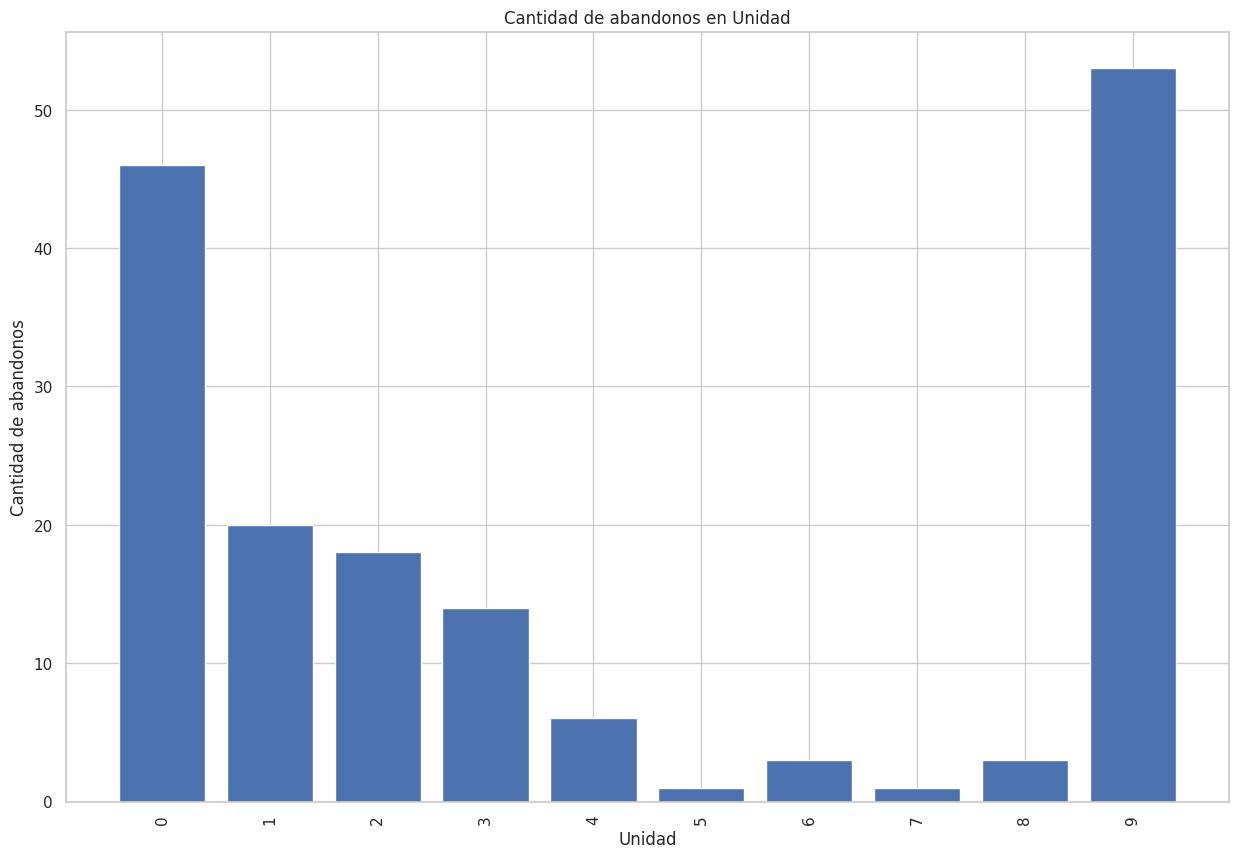

In [199]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(cantidad_alumnos_por_unidad_que_dejaron.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_abandonos in x_sorted]
items_y = [cantidad_de_abandonos for unidad, cantidad_de_abandonos in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de abandonos')
ax.set_title('Cantidad de abandonos en Unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


El grupo de alumnos que nunca entregó nada, vamos a unirlo al segmento de gente que no se registró nunca en el sistema. Serán todos interpretados como personas que no comenzaron la cursada 

#### WIP tiene sentido poner en la misma bolsa los que no se registraron de los que no entregaron nada? Hay algún evento que nos sirva acá? Era alguien que podriamos haber salvado o no? 
##### Si se inscribieron y no se registraron, no los contamos y los sacamos. 

### Segmento 1: "No entregaron nada"

In [200]:
alumnos_que_no_comenzaron_la_cursada = alumnos_por_unidad_que_dejaron[0]

segmento_1 = alumnos_que_no_comenzaron_la_cursada
segmento_1_ids = [alumno.id for alumno in alumnos_que_no_comenzaron_la_cursada]

len(segmento_1)

46

### Segmento 2: "Dejaron en la primera parte de la materia"

El primer parcial fue después de la unidad 4. Si dejaron de entregar hasta la unidad 4, lo vamos a considerar como que dejaron en la primera parte de la materia. 

In [201]:
alumnos_que_dejaron_en_la_primera_parte_de_la_materia = alumnos_por_unidad_que_dejaron[1] + alumnos_por_unidad_que_dejaron[2] + alumnos_por_unidad_que_dejaron[3] + alumnos_por_unidad_que_dejaron[4]

segmento_2 = alumnos_que_dejaron_en_la_primera_parte_de_la_materia

segmento_2_ids = [alumno.id for alumno in alumnos_que_dejaron_en_la_primera_parte_de_la_materia]


len(segmento_2)


58

### Segmento 3: "Dejaron en la segunda parte de la materia"
El primer parcial fue después de la unidad 4. Si entregaron unidades posteriores a la unidad 4, lo vamos a considerar como que realizaron toda la primera parte de la materia. Sin embargo, si no entregaron la última unidad (Unidad 9) vamos a considerar que dejaron en la segunda parte de la materia.

In [202]:
alumnos_que_dejaron_en_la_segunda_parte_de_la_materia = alumnos_por_unidad_que_dejaron[5] + alumnos_por_unidad_que_dejaron[6] + alumnos_por_unidad_que_dejaron[7] + alumnos_por_unidad_que_dejaron[8]

segmento_3 = alumnos_que_dejaron_en_la_segunda_parte_de_la_materia

segmento_3_ids = [alumno.id for alumno in alumnos_que_dejaron_en_la_segunda_parte_de_la_materia]

len(segmento_3)

8

### Segmento 4: "Entregaron todo"

In [203]:
alumnos_que_entregaron_todo = alumnos_por_unidad_que_dejaron[9]

segmento_4 = alumnos_que_entregaron_todo

segmento_4_ids = [alumno.id for alumno in alumnos_que_entregaron_todo]

len(segmento_4)

53

Deberiamos validar que las personas que entregaron todas las unidades y no que la última fue la unidad 9

In [204]:
 def entrego_todas_las_unidades(alumno):
    return set(entregas_por_persona_y_unidad.get(alumno.id, {}).keys()) == set({1,2,3,4,5,6,7,8,9})
    
all([entrego_todas_las_unidades(alumno) for alumno in alumnos_que_entregaron_todo])

True

Entonces el segmento "Entregaron todo" efectivamente, entregó todo.

## Vamos a armar Dataframes con todos los features que fuimos recolectando

In [205]:
# Dataframe de Ejercicios

l = []

all_ejercicios = all_exercises

for ejercicio in all_ejercicios:
    unit_submission = ejercicio.unit_submission
    alumno = unit_submission.student_record
    estudios = alumno.studies
    l.append((ejercicio.id, unit_submission.id, ejercicio.name))

df_exercises = pd.DataFrame(l, columns=['EjercicioID', 'UnitSubmissionID', 'NombreEjercicio'])
df_exercises

,EjercicioID,UnitSubmissionID,NombreEjercicio
0,25,16,rebotes.py
1,26,16,hipoteca.py
2,27,16,esfera.py
3,28,16,geringoso.py
4,29,17,rebotes.py
...,...,...,...
2950,3040,927,lote.py
2951,3041,927,torre_control.py
2952,3042,927,canguros_buenos.py
2953,3043,928,mareas_a_mano.py


In [206]:
# Dataframe de UnitSubimissions

l = []

for unit_submission in all_unit_submissions:
    l.append((unit_submission.id, unit_submission.student_record_id, unit_submission.unit, unit_submission.datetime, unit_submission.accepts_pair_review))

df_unit_submission = pd.DataFrame(l, columns=['UnitSubmissionID', 'Alumno', 'Unidad', 'FechaEntrega', 'AceptaPairReview'])
df_unit_submission

,UnitSubmissionID,Alumno,Unidad,FechaEntrega,AceptaPairReview
0,16,390,1,2022-03-09 16:52:51.340012+00:00,False
1,17,388,1,2022-03-09 17:20:38.676259+00:00,False
2,18,387,1,2022-03-09 22:45:09.486379+00:00,False
3,19,247,1,2022-03-10 12:54:50.324251+00:00,True
4,20,234,1,2022-03-10 20:08:20.512730+00:00,False
...,...,...,...,...,...
883,925,216,6,2022-06-01 17:16:42.812746+00:00,False
884,926,248,9,2022-06-02 07:12:58.163663+00:00,False
885,927,226,9,2022-06-02 21:09:02.528814+00:00,False
886,928,397,8,2022-06-04 15:49:01.419799+00:00,False


In [207]:
# Dataframe de StudentRecord

l = []

student_records = StudentRecord.objects.all()

for student_record in student_records:
    estudios = student_record.studies
    trabajo = student_record.job
    l.append((student_record.id, student_record.gender, student_record.country, student_record.state, student_record.city, estudios.university, estudios.career, estudios.study_level, estudios.programming_skills, estudios.python_skills, estudios.university_location, trabajo.business_name, trabajo.position))

df_student_record = pd.DataFrame(l, columns=['Alumno', 'Genero', 'Pais', 'Estado', 'Ciudad', 'EstudiosUniversidad', 'EstudiosCarrera', 'EstudiosNivel', 'EstudiosNivelProgramacion', 'EstudiosNivelPython', 'EstudiosLocacion', 'TrabajoEmpresa', 'TrabajoRol'])
df_student_record

,Alumno,Genero,Pais,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,230,3,Argentina,Santa Fe,Rosario,Instituto de Inmunología Clínica y Experimenta...,,Grado (universitario),3.0,3.0,,,
1,226,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2,215,3,Argentina,Jujuy,Humahuaca,Unju,,Grado (universitario),1.0,1.0,,,
3,220,3,Argentina,CABA,CABA,UNGS,,Maestría,2.0,1.0,,,
4,241,3,Argentina,Buenos Aires,Mar Del Plata,INTEMA,,Grado (universitario),4.0,2.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,380,3,Argentina,,,,Licenciatura en Biotecnología,,NaN,NaN,,,
188,399,3,,,,,,,NaN,NaN,,,
189,384,3,,,,,,,NaN,NaN,,,
190,392,3,,,,,,,NaN,NaN,,,


In [208]:
# Dataframe de Correction

l = []

corrections = Correction.objects.all()

for correction in corrections:
    l.append((correction.id, correction.exercise.id, correction.reviewer.email, correction.solves_exercise, correction.code_presentation, correction.works, correction.tests, correction.grade, correction.done, correction.correction_time_in_minutes, correction.published))

df_corrections = pd.DataFrame(l, columns=['CorrectionID', 'EjercicioID', 'Corrector', 'ResuelveEjercicio', 'PresentacionCodigo', 'Funciona', 'Tests', 'Evaluacion', 'Corregido', 'TiempoDeCorreccion', 'Publicado'])
df_corrections

,CorrectionID,EjercicioID,Corrector,ResuelveEjercicio,PresentacionCodigo,Funciona,Tests,Evaluacion,Corregido,TiempoDeCorreccion,Publicado
0,921,936,ivanpedron@gmail.com,1.0,4.0,3.0,1.0,4.0,True,5.0,True
1,1343,1377,dalban@unsam.edu.ar,1.0,1.0,1.0,1.0,1.0,False,0.0,False
2,25,30,matiaslopez@gmail.com,1.0,1.0,1.0,1.0,1.0,False,1.0,False
3,1186,1210,ivanpedron@gmail.com,1.0,5.0,3.0,3.0,5.0,True,6.0,True
4,1178,1202,ivanpedron@gmail.com,1.0,5.0,3.0,3.0,5.0,True,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2297,2229,2585,dalban@unsam.edu.ar,1.0,5.0,1.0,3.0,3.0,True,50.0,False
2298,2221,2575,dalban@unsam.edu.ar,1.0,4.0,1.0,3.0,2.0,True,60.0,False
2299,2214,2568,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,4.0,True,40.0,False
2300,2210,2564,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,5.0,True,10.0,False


In [209]:
# Dataframe de PairReviewCorrection

l = []

pair_reviews = PairReviewCorrection.objects.all()

for pair_review in pair_reviews:
    l.append((pair_review.id, pair_review.exercise.id, pair_review.reviewer.email, pair_review.correction_datetime, pair_review.is_anonymous_reviewer, pair_review.done, pair_review.published))

df_pair_reviews = pd.DataFrame(l, columns=['PairReviewID', 'EjercicioID', 'Corrector', 'FechaPairReview', 'PaiReviewAnonimo', 'Corregido', 'Publicado'])
df_pair_reviews

,PairReviewID,EjercicioID,Corrector,FechaPairReview,PaiReviewAnonimo,Corregido,Publicado
0,166,2275,clarapalu17@gmail.com,2022-05-11 16:21:38.539829+00:00,True,True,True
1,110,1236,fa_caviglia@hotmail.com,2022-06-01 15:05:55.629501+00:00,True,True,False
2,30,514,clarapalu17@gmail.com,2022-03-30 14:09:02.437626+00:00,True,True,True
3,29,509,mercedesfraire@gmail.com,2022-03-28 21:36:47.188231+00:00,True,True,True
4,44,1045,navarro.gabriel2001@gmail.com,2022-04-06 02:02:58.789904+00:00,True,True,True
...,...,...,...,...,...,...,...
90,141,1958,fedemorales93@gmail.com,2022-06-01 13:55:54.590458+00:00,True,True,False
91,148,2099,hanisch.priscila@gmail.com,2022-05-01 20:56:29.670602+00:00,True,False,False
92,153,1978,hanisch.priscila@gmail.com,2022-05-01 20:57:27.394117+00:00,True,False,False
93,163,2200,ortizrocca@agro.uba.ar,2022-05-07 16:02:58.418603+00:00,True,False,False


In [210]:
# Dataframe de AuthomaticCorrections

l = []

authomatic_corrections = all_authomatic_corrections 

for authomatic_correction in authomatic_corrections:
    l.append((authomatic_correction.id, authomatic_correction.exercise.id, authomatic_correction.executed_instruction, authomatic_correction.is_original, authomatic_correction.correct_tests_percentage, authomatic_correction.worked, authomatic_correction.correction_datetime, authomatic_correction.published))

df_authomatic_corrections = pd.DataFrame(l, columns=['AuthomaticCorrectionID', 'EjercicioID', 'InstruccionEjecutada', 'EsOriginal', 'PorcetajeDeTests', 'Funciona', 'FechaDeCorreccionAutomatica', 'Publicado'])
df_authomatic_corrections

,AuthomaticCorrectionID,EjercicioID,InstruccionEjecutada,EsOriginal,PorcetajeDeTests,Funciona,FechaDeCorreccionAutomatica,Publicado
0,1468,1950,"<p>Para evaluar la función insertar, la llamam...",True,37.0,True,2022-05-26 14:10:48.988673+00:00,True
1,1384,2060,"<p>Para evaluar la función insertar, la llamam...",True,0.0,False,2022-05-26 14:10:48.987384+00:00,True
2,1703,2360,<p>Para evaluar la función vida_en_segundos la...,True,0.0,False,2022-05-26 14:11:07.849442+00:00,True
3,727,886,<p>Para evaluar la función costo_camion la lla...,True,0.0,True,2022-05-10 15:24:19.796152+00:00,True
4,728,887,<p>Para evaluar la función hacer_informe la ll...,True,0.0,True,2022-05-10 15:24:19.796170+00:00,True
...,...,...,...,...,...,...,...,...
1020,1439,2559,"<p>Para evaluar la función insertar, la llamam...",True,100.0,True,2022-05-26 14:10:48.988230+00:00,True
1021,1590,2589,<p>Para evaluar la función parse_csv la llamam...,True,60.0,True,2022-05-26 14:10:59.215738+00:00,True
1022,1592,2590,<p>Para evaluar la función leer_camion la llam...,True,0.0,False,2022-05-26 14:10:59.215770+00:00,True
1023,1593,2590,<p>Para evaluar la función leer_precios la lla...,True,0.0,False,2022-05-26 14:10:59.215786+00:00,True


In [211]:
# Dataframe de SelfEvaluation
l = []

self_evaluations = all_self_evaluations

for self_evaluation in self_evaluations:
    l.append((self_evaluation.id, self_evaluation.unit_submission.student_record.id, self_evaluation.unit_submission.unit, self_evaluation.unit_submission.id, self_evaluation.content_learning, self_evaluation.exercises_autograde, self_evaluation.dedication_in_hours, self_evaluation.dedication_evaluation))

df_self_evaluations = pd.DataFrame(l, columns=['SelfEvaluationID', 'Alumno', 'Unidad', 'UnitSubmissionID', 'AprendizajeDelContenido', 'Autoevaluacion', 'DedicacionEnHoras', 'EvaluacionDedicacion'])
df_self_evaluations

,SelfEvaluationID,Alumno,Unidad,UnitSubmissionID,AprendizajeDelContenido,Autoevaluacion,DedicacionEnHoras,EvaluacionDedicacion
0,9,390,1,16,4,2,10,1
1,10,388,1,17,4,3,14,1
2,11,387,1,18,4,4,8,1
3,12,247,1,19,4,4,8,1
4,13,234,1,20,3,3,5,1
...,...,...,...,...,...,...,...,...
636,657,373,9,921,3,3,8,1
637,658,393,9,922,4,4,10,1
638,659,396,9,923,2,2,24,1
639,660,248,9,924,3,3,12,2


In [212]:
# Dataframe de ExerciseSelfEvaluation
l = []

exercise_self_evaluations = all_exercise_self_evaluations

for exercise_self_evaluation in exercise_self_evaluations:
    self_evaluation = exercise_self_evaluation.self_evaluation
    l.append((exercise_self_evaluation.id, exercise_self_evaluation.exercise_name, exercise_self_evaluation.grade, self_evaluation.id))

df_exercise_self_evaluations = pd.DataFrame(l, columns=['ExerciseSelfEvaluationID', 'NombreEjercicio', 'EvaluacionEjercicio', 'SelfEvaluationID'])
df_exercise_self_evaluations

,ExerciseSelfEvaluationID,NombreEjercicio,EvaluacionEjercicio,SelfEvaluationID
0,1226,solucion_de_errores.py,6,271
1,1227,costo_camion.py,6,271
2,1228,tabla_informe.py,6,271
3,1229,tablamult.py,6,271
4,1230,arboles.py,5,271
...,...,...,...,...
2906,2996,fileparse.py,6,661
2907,2997,informe_funciones.py,6,661
2908,2998,costo_camion.py,6,661
2909,2999,bbin.py,6,661


In [213]:
# JOIN Unit Submission - StudentRecord - Jobs - Studies

df_unit_submission_en_profundidad = pd.merge(
    df_unit_submission,
    df_student_record,
    how="inner",
    on="Alumno"
)

df_unit_submission_en_profundidad

,UnitSubmissionID,Alumno,Unidad,FechaEntrega,AceptaPairReview,Genero,Pais,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,16,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
1,17,388,1,2022-03-09 17:20:38.676259+00:00,False,3,Argentina,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
2,18,387,1,2022-03-09 22:45:09.486379+00:00,False,3,,,,,,,NaN,NaN,,,
3,159,387,2,2022-03-21 21:27:22.424808+00:00,False,3,,,,,,,NaN,NaN,,,
4,266,387,3,2022-03-30 04:29:00.972606+00:00,False,3,,,,,,,NaN,NaN,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,799,239,7,2022-05-25 13:38:25.251574+00:00,False,3,Argentina,Córdoba,Alta Gracia,Instituto de Biodiversidad y Biología Experime...,,Grado (universitario),NaN,2.0,,,
884,908,239,8,2022-06-01 15:01:11.871519+00:00,False,3,Argentina,Córdoba,Alta Gracia,Instituto de Biodiversidad y Biología Experime...,,Grado (universitario),NaN,2.0,,,
885,508,214,3,2022-04-13 18:12:34.646782+00:00,False,3,argentina,Córdoba,Córdoba,Universidad Nacional de Córdoba,,Grado (universitario),2.0,1.0,,,
886,509,214,2,2022-04-13 18:56:49.842805+00:00,True,3,argentina,Córdoba,Córdoba,Universidad Nacional de Córdoba,,Grado (universitario),2.0,1.0,,,


In [214]:
# JOIN Exercises - Unit Submission - StudentRecord - Jobs - Studies

df_ejercicios_en_profundidad = pd.merge(
    df_exercises,
    df_unit_submission_en_profundidad,
    how="inner",
    on="UnitSubmissionID"
)

df_ejercicios_en_profundidad

,EjercicioID,UnitSubmissionID,NombreEjercicio,Alumno,Unidad,FechaEntrega,AceptaPairReview,Genero,Pais,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,25,16,rebotes.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
1,26,16,hipoteca.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
2,27,16,esfera.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
3,28,16,geringoso.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
4,29,17,rebotes.py,388,1,2022-03-09 17:20:38.676259+00:00,False,3,Argentina,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,3040,927,lote.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2951,3041,927,torre_control.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2952,3042,927,canguros_buenos.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2953,3043,928,mareas_a_mano.py,397,8,2022-06-04 15:49:01.419799+00:00,False,3,-,-,-,,,,NaN,NaN,,,


In [215]:
# JOIN Correction - Exercises - Unit Submission - StudentRecord - Jobs - Studies

df_correcciones_en_profundidad = pd.merge(
    df_corrections,
    df_ejercicios_en_profundidad,
    how="inner",
    on="EjercicioID"
)

df_correcciones_en_profundidad

,CorrectionID,EjercicioID,Corrector,ResuelveEjercicio,PresentacionCodigo,Funciona,Tests,Evaluacion,Corregido,TiempoDeCorreccion,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,921,936,ivanpedron@gmail.com,1.0,4.0,3.0,1.0,4.0,True,5.0,...,Buenos Aires,General San Martín,UNSAM/CNEA,,Grado (universitario),4.0,4.0,,,
1,1343,1377,dalban@unsam.edu.ar,1.0,1.0,1.0,1.0,1.0,False,0.0,...,CABA,CABA,Servicio Meteorológico Nacional,,Grado (universitario),3.0,2.0,,Servicio Meteorológico Nacional. Centro de pro...,
2,25,30,matiaslopez@gmail.com,1.0,1.0,1.0,1.0,1.0,False,1.0,...,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
3,1178,1202,ivanpedron@gmail.com,1.0,5.0,3.0,3.0,5.0,True,5.0,...,,,,,,NaN,NaN,,,
4,101,106,ivanpedron@gmail.com,1.0,5.0,3.0,1.0,5.0,True,4.0,...,Santa Cruz,Comandante Luis Piedrabuena,Colegio provincial de educación secundaria N°1,,Grado (universitario),4.0,1.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,2229,2585,dalban@unsam.edu.ar,1.0,5.0,1.0,3.0,3.0,True,50.0,...,,,,,,NaN,NaN,,,
2240,2221,2575,dalban@unsam.edu.ar,1.0,4.0,1.0,3.0,2.0,True,60.0,...,Buenos Aires,Vicente López,UNSAM,,Escuela,2.0,1.0,,,
2241,2214,2568,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,4.0,True,40.0,...,Buenos aires,Matanza,Universidad nacional de San Martín,Ingeniería Biomédica,Escuela,3.0,2.0,,,
2242,2210,2564,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,5.0,True,10.0,...,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,CNEA - CONICET,,Doctorado,2.0,1.0,,,


In [216]:
# JOIN PairReviewCorrection - Exercises - Unit Submission - StudentRecord - Jobs - Studies

df_pair_review_en_profundidad = pd.merge(
    df_pair_reviews,
    df_ejercicios_en_profundidad,
    how="inner",
    on="EjercicioID"
)

df_pair_review_en_profundidad

,PairReviewID,EjercicioID,Corrector,FechaPairReview,PaiReviewAnonimo,Corregido,Publicado,UnitSubmissionID,NombreEjercicio,Alumno,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,166,2275,clarapalu17@gmail.com,2022-05-11 16:21:38.539829+00:00,True,True,True,668,random_walk.py,231,...,Santa Fe,Rosario,CONICET,,Grado (universitario),2.0,2.0,,,
1,173,2275,fedemorales93@gmail.com,2022-05-07 16:03:31.041245+00:00,True,False,False,668,random_walk.py,231,...,Santa Fe,Rosario,CONICET,,Grado (universitario),2.0,2.0,,,
2,110,1236,fa_caviglia@hotmail.com,2022-06-01 15:05:55.629501+00:00,True,True,False,342,propaga.py,377,...,,,,Doctorado en Calidad e Innovación Industrial,,NaN,NaN,,,
3,123,1236,fermag.and@gmail.com,2022-04-13 02:08:42.329139+00:00,True,True,True,342,propaga.py,377,...,,,,Doctorado en Calidad e Innovación Industrial,,NaN,NaN,,,
4,30,514,clarapalu17@gmail.com,2022-03-30 14:09:02.437626+00:00,True,True,True,155,informe.py,393,...,,,,,,NaN,NaN,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,136,1781,navarro.gabriel2001@gmail.com,2022-04-25 23:18:58.408386+00:00,True,True,True,538,figuritas.py,231,...,Santa Fe,Rosario,CONICET,,Grado (universitario),2.0,2.0,,,
87,126,1286,dari_89_julian@hotmail.com,2022-04-10 06:36:10.523952+00:00,True,True,True,356,propaga.py,368,...,Buenos Aires,La Matanza,Universidad Nacional de Hurlingham,,Doctorado,4.0,4.0,,,
88,113,1286,navarro.gabriel2001@gmail.com,2022-04-12 19:47:12.186858+00:00,True,True,True,356,propaga.py,368,...,Buenos Aires,La Matanza,Universidad Nacional de Hurlingham,,Doctorado,4.0,4.0,,,
89,152,1958,a_bas_vas@yahoo.com.ar,2022-05-31 21:25:42.342532+00:00,True,True,False,587,costo_camion.py,288,...,CABA,CABA,MACN-CONICET,,Posdoctorado,3.0,2.0,,,


In [217]:
# JOIN AuthomaticCorrections - Exercises - Unit Submission - StudentRecord - Jobs - Studies

df_authomatic_corrections_en_profundidad = pd.merge(
    df_authomatic_corrections,
    df_ejercicios_en_profundidad,
    how="inner",
    on="EjercicioID"
)

df_authomatic_corrections_en_profundidad

,AuthomaticCorrectionID,EjercicioID,InstruccionEjecutada,EsOriginal,PorcetajeDeTests,Funciona,FechaDeCorreccionAutomatica,Publicado,UnitSubmissionID,NombreEjercicio,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,1468,1950,"<p>Para evaluar la función insertar, la llamam...",True,37.0,True,2022-05-26 14:10:48.988673+00:00,True,585,bbin.py,...,Buenos Aires,Villa Bosch,SAP,,Grado (universitario),2.0,1.0,,SAP. Go-to-Market Master Data Specialist,
1,1384,2060,"<p>Para evaluar la función insertar, la llamam...",True,0.0,False,2022-05-26 14:10:48.987384+00:00,True,612,bbin.py,...,CABA,Capital Federal,UNSAM,Ing. Industrial con pedido de pase. Lic. Cienc...,Grado incompleto / pase a Lic. Ciencia de datos,4.0,4.0,,,
2,1703,2360,<p>Para evaluar la función vida_en_segundos la...,True,0.0,False,2022-05-26 14:11:07.849442+00:00,True,696,vida.py,...,Buenos Aires,Villa Bosch,SAP,,Grado (universitario),2.0,1.0,,SAP. Go-to-Market Master Data Specialist,
3,727,886,<p>Para evaluar la función costo_camion la lla...,True,0.0,True,2022-05-10 15:24:19.796152+00:00,True,249,costo_camion.py,...,Buenos Aires,San Martin,UNSAM,,Grado (universitario),4.0,1.0,,Swiss Medical,
4,728,887,<p>Para evaluar la función hacer_informe la ll...,True,0.0,True,2022-05-10 15:24:19.796170+00:00,True,249,tabla_informe.py,...,Buenos Aires,San Martin,UNSAM,,Grado (universitario),4.0,1.0,,Swiss Medical,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1439,2559,"<p>Para evaluar la función insertar, la llamam...",True,100.0,True,2022-05-26 14:10:48.988230+00:00,True,752,bbin.py,...,Buenos Aires,Bahía Blanca,Universidad Nacional del Sur,,Grado (universitario),4.0,1.0,,,
1021,1590,2589,<p>Para evaluar la función parse_csv la llamam...,True,60.0,True,2022-05-26 14:10:59.215738+00:00,True,763,fileparse.py,...,,,,,,NaN,NaN,,,
1022,1592,2590,<p>Para evaluar la función leer_camion la llam...,True,0.0,False,2022-05-26 14:10:59.215770+00:00,True,763,informe_final.py,...,,,,,,NaN,NaN,,,
1023,1593,2590,<p>Para evaluar la función leer_precios la lla...,True,0.0,False,2022-05-26 14:10:59.215786+00:00,True,763,informe_final.py,...,,,,,,NaN,NaN,,,


In [218]:
# JOIN SelfEvaluation - Unit Submission - StudentRecord - Jobs - Studies

df_self_evaluation_en_profundidad = pd.merge(
    df_self_evaluations,
    df_unit_submission_en_profundidad,
    how="inner",
    on="UnitSubmissionID"
)

df_self_evaluation_en_profundidad

,SelfEvaluationID,Alumno_x,Unidad_x,UnitSubmissionID,AprendizajeDelContenido,Autoevaluacion,DedicacionEnHoras,EvaluacionDedicacion,Alumno_y,Unidad_y,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,9,390,1,16,4,2,10,1,390,1,...,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
1,10,388,1,17,4,3,14,1,388,1,...,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
2,11,387,1,18,4,4,8,1,387,1,...,,,,,,NaN,NaN,,,
3,12,247,1,19,4,4,8,1,247,1,...,Salta,Salta,INENCO - Universidad Nacional de Salta,,Grado (universitario),5.0,3.0,,,
4,13,234,1,20,3,3,5,1,234,1,...,Corrientes,Corrientes Capital,Becario Doctoral de CONICET - INTA Concordia (...,,Grado (universitario),2.0,2.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,657,373,9,921,3,3,8,1,373,9,...,,,,Ingeniería Biomedica,,NaN,NaN,,,
637,658,393,9,922,4,4,10,1,393,9,...,,,,,,NaN,NaN,,,
638,659,396,9,923,2,2,24,1,396,9,...,,,,,,NaN,NaN,,,
639,660,248,9,924,3,3,12,2,248,9,...,Buenos Aires,San Martín,Universidad de Buenos Aires,,Grado (universitario),2.0,2.0,,,


In [219]:
# JOIN ExerciseSelfEvaluation - SelfEvaluation - Unit Submission - StudentRecord - Jobs - Studies

df_exercise_self_evaluation_en_profundidad = pd.merge(
    df_exercise_self_evaluations,
    df_self_evaluation_en_profundidad,
    how="inner",
    on="SelfEvaluationID"
)

df_exercise_self_evaluation_en_profundidad

,ExerciseSelfEvaluationID,NombreEjercicio,EvaluacionEjercicio,SelfEvaluationID,Alumno_x,Unidad_x,UnitSubmissionID,AprendizajeDelContenido,Autoevaluacion,DedicacionEnHoras,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,1226,solucion_de_errores.py,6,271,356,3,306,3,3,13,...,Buenos Aires,San Martín,UNSAM,Ingeniería Electrónica,Escuela,3.0,2.0,,,
1,1227,costo_camion.py,6,271,356,3,306,3,3,13,...,Buenos Aires,San Martín,UNSAM,Ingeniería Electrónica,Escuela,3.0,2.0,,,
2,1228,tabla_informe.py,6,271,356,3,306,3,3,13,...,Buenos Aires,San Martín,UNSAM,Ingeniería Electrónica,Escuela,3.0,2.0,,,
3,1229,tablamult.py,6,271,356,3,306,3,3,13,...,Buenos Aires,San Martín,UNSAM,Ingeniería Electrónica,Escuela,3.0,2.0,,,
4,1230,arboles.py,5,271,356,3,306,3,3,13,...,Buenos Aires,San Martín,UNSAM,Ingeniería Electrónica,Escuela,3.0,2.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,2996,fileparse.py,6,661,216,6,925,2,3,20,...,Corrientes,Corrientes,Centro de Ecología Aplicada del Litoral (Conse...,,Grado (universitario),4.0,2.0,,,
2907,2997,informe_funciones.py,6,661,216,6,925,2,3,20,...,Corrientes,Corrientes,Centro de Ecología Aplicada del Litoral (Conse...,,Grado (universitario),4.0,2.0,,,
2908,2998,costo_camion.py,6,661,216,6,925,2,3,20,...,Corrientes,Corrientes,Centro de Ecología Aplicada del Litoral (Conse...,,Grado (universitario),4.0,2.0,,,
2909,2999,bbin.py,6,661,216,6,925,2,3,20,...,Corrientes,Corrientes,Centro de Ecología Aplicada del Litoral (Conse...,,Grado (universitario),4.0,2.0,,,


In [220]:
from pathlib import Path  
filepath = Path('exercises_unit_submission_student_record.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_ejercicios_en_profundidad.to_csv(filepath)  

filepath = Path('corrections_exercises_unit_submission_student_record.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_correcciones_en_profundidad.to_csv(filepath) 

filepath = Path('pair_review_exercises_unit_submission_student_record.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_pair_review_en_profundidad.to_csv(filepath) 

filepath = Path('authomatic_corrections_exercises_unit_submission_student_record.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_authomatic_corrections_en_profundidad.to_csv(filepath) 

filepath = Path('exercise_self_evaluation_self_evaluation_unit_submission_student_record.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_exercise_self_evaluation_en_profundidad.to_csv(filepath) 

## Entregas por unidad

/tmp/ipykernel_14345/3598808986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencia_unidades.index, y=frecuencia_unidades.values, palette='muted')


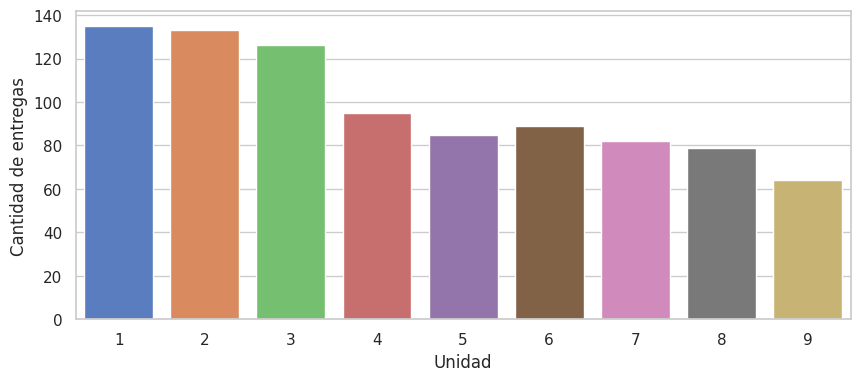

In [221]:
plt.subplots(figsize=(10,4))

frecuencia_unidades = df_unit_submission_en_profundidad['Unidad'].value_counts()
sns.barplot(x=frecuencia_unidades.index, y=frecuencia_unidades.values, palette='muted')

plt.xlabel("Unidad")
plt.ylabel("Cantidad de entregas")


plt.show()

Vamos a graficar lo mismo para cada uno de nuestros segmentos

### Entregas por unidad por grupo


In [222]:
# Segmento 1
import numpy

filtered_df = df_unit_submission_en_profundidad[df_unit_submission_en_profundidad['Alumno'].isin(segmento_1_ids)]

print(filtered_df)

Empty DataFrame
Columns: [UnitSubmissionID, Alumno, Unidad, FechaEntrega, AceptaPairReview, Genero, Pais, Estado, Ciudad, EstudiosUniversidad, EstudiosCarrera, EstudiosNivel, EstudiosNivelProgramacion, EstudiosNivelPython, EstudiosLocacion, TrabajoEmpresa, TrabajoRol]
Index: []


Para el Segmento 1 tiene sentido porque es el segmento que no entregó nada. 

/tmp/ipykernel_14345/1038237932.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencia_unidades_segmento_2.index, y=frecuencia_unidades_segmento_2.values, palette='muted')


<Axes: xlabel='None'>

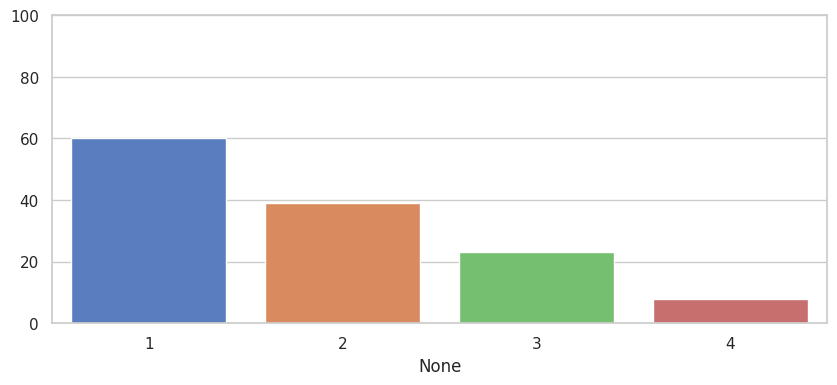

In [223]:
# Segmento 2
import numpy

plt.subplots(figsize=(10,4))
plt.ylim(0,100)

filtered_df = df_unit_submission_en_profundidad[df_unit_submission_en_profundidad['Alumno'].isin(segmento_2_ids)]

frecuencia_unidades_segmento_2 = filtered_df['Unidad'].value_counts()
sns.barplot(x=frecuencia_unidades_segmento_2.index, y=frecuencia_unidades_segmento_2.values, palette='muted')

/tmp/ipykernel_14345/2495692889.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencia_unidades_segmento_3.index, y=frecuencia_unidades_segmento_3.values, palette='muted')


<Axes: xlabel='None'>

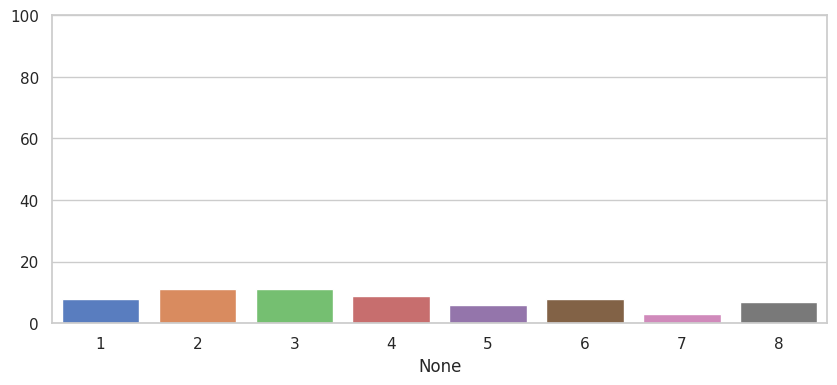

In [224]:
# Segmento 3
import numpy

plt.subplots(figsize=(10,4))
plt.ylim(0,100)

filtered_df = df_unit_submission_en_profundidad[df_unit_submission_en_profundidad['Alumno'].isin(segmento_3_ids)]

frecuencia_unidades_segmento_3 = filtered_df['Unidad'].value_counts()
sns.barplot(x=frecuencia_unidades_segmento_3.index, y=frecuencia_unidades_segmento_3.values, palette='muted')

/tmp/ipykernel_14345/2542738329.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencia_unidades_segmento_4.index, y=frecuencia_unidades_segmento_4.values, palette='muted')


<Axes: xlabel='None'>

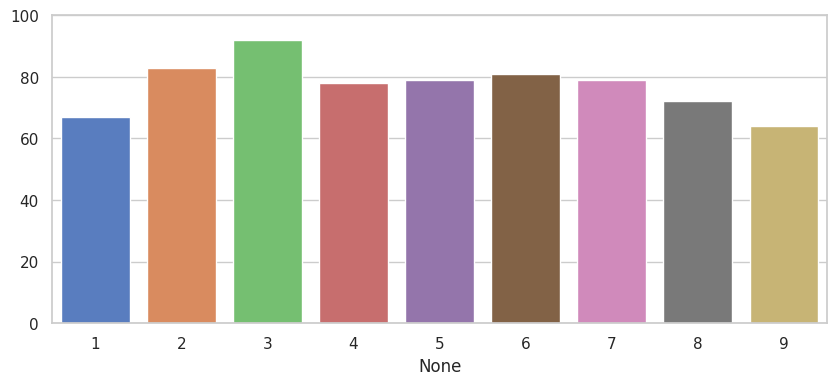

In [225]:
# Segmento 4
import numpy

plt.subplots(figsize=(10,4))
plt.ylim(0,100)

filtered_df = df_unit_submission_en_profundidad[df_unit_submission_en_profundidad['Alumno'].isin(segmento_4_ids)]

frecuencia_unidades_segmento_4 = filtered_df['Unidad'].value_counts()

sns.barplot(x=frecuencia_unidades_segmento_4.index, y=frecuencia_unidades_segmento_4.values, palette='muted')


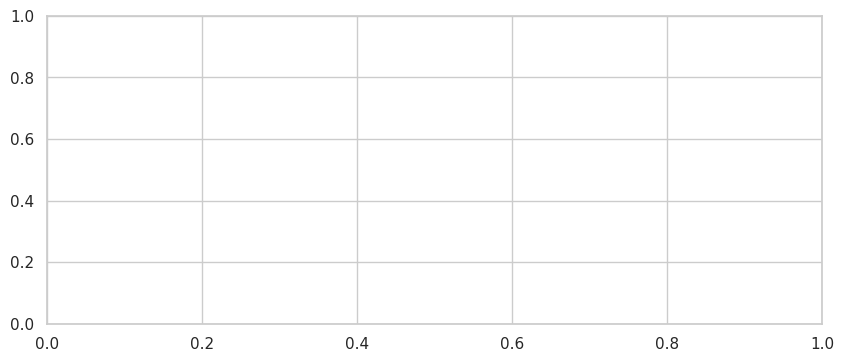

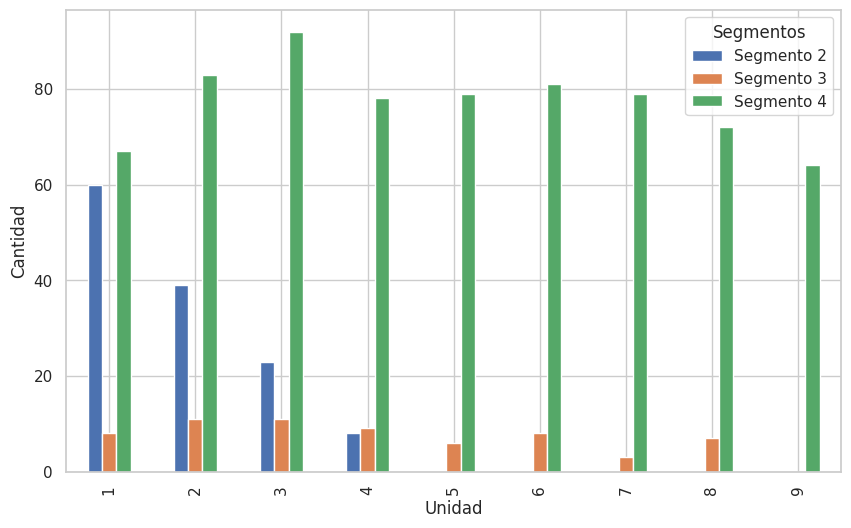

In [226]:
plt.subplots(figsize=(10,4))


# Crear un DataFrame vacío con todas las unidades como índice
unidades_completas = frecuencia_unidades_segmento_4.index
df = pd.DataFrame(index=unidades_completas)

# Añadir los datos de cada segmento, alineando por el índice
df['Segmento 2'] = frecuencia_unidades_segmento_2.reindex(unidades_completas, fill_value=0)
df['Segmento 3'] = frecuencia_unidades_segmento_3.reindex(unidades_completas, fill_value=0)
df['Segmento 4'] = frecuencia_unidades_segmento_4.reindex(unidades_completas, fill_value=0)

# Ordenar el DataFrame por el índice (unidades) para asegurarse de que estén en orden
df.sort_index(inplace=True)

# Crear el gráfico de barras agrupadas
ax = df.plot(kind='bar', figsize=(10, 6))

# Configurar el título y etiquetas
ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad')

# Mostrar la leyenda
ax.legend(title='Segmentos')

# Mostrar el gráfico
plt.show()

### Quiero ver en que Unidad dejaron dependiendo de la segmentación

Vamos a probar ver a partir de las entregas cuando la gente dejó. Se va a interpretar como dejar en la última unidad entregada. Se pueden llegar a revisar estos casos con posteriores cruces de datos con eventos para tratar de determinar la última interacción con el sistema como día en que se dejó.

La unidad 0 se va a usar para interpretar a todos aquellos que no entregaron nunca.

In [227]:
todas_las_entregas = all_unit_submissions

entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in entregas_por_persona_y_unidad.keys():
        if entrega.unit in entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].append(entrega)
        else:
            entregas_por_persona_y_unidad[entrega.student_record_id].update({entrega.unit: [entrega]})
    else:
        entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: [entrega]}
        
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>],
  4: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 4>],
  5: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 5>],
  6: [<UnitSubmission: rdl

In [228]:
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>],
  4: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 4>],
  5: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 5>],
  6: [<UnitSubmission: rdl

In [229]:
def unidad_en_la_que_dejo(alumno):
    return max(entregas_por_persona_y_unidad.get(alumno.id, {}).keys(), default=0)
    

In [230]:
alumnos_por_unidad_que_dejaron = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno in alumnos:
    unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
    alumnos_por_unidad_que_dejaron[unidad_en_que_se_dejo] += 1
    
alumnos_por_unidad_que_dejaron

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

In [231]:
alumnos_por_unidad_que_dejaron_segmento_2 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno in alumnos:
    if alumno in alumnos_que_dejaron_en_la_primera_parte_de_la_materia: 
        unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
        alumnos_por_unidad_que_dejaron_segmento_2[unidad_en_que_se_dejo] += 1
    
alumnos_por_unidad_que_dejaron_segmento_2

{0: 0, 1: 20, 2: 18, 3: 14, 4: 6, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

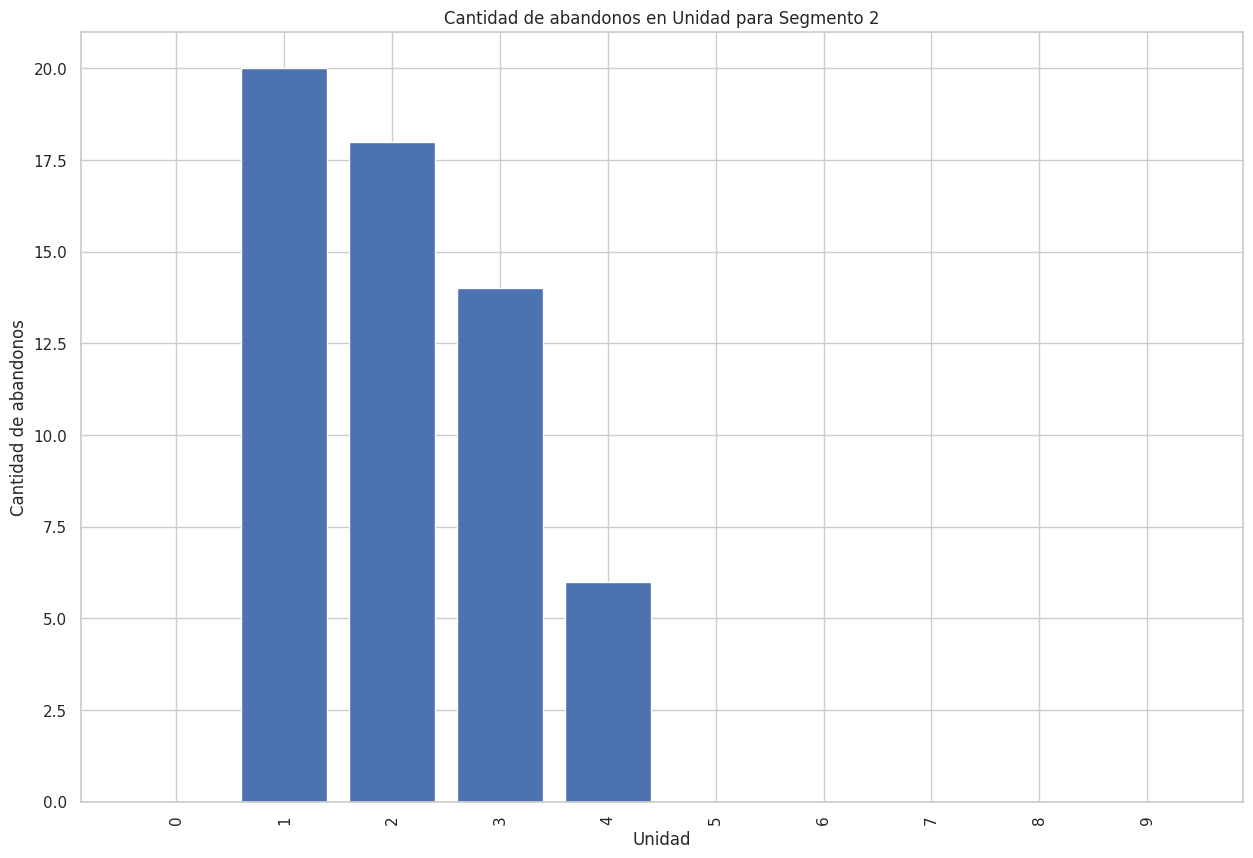

In [232]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(alumnos_por_unidad_que_dejaron_segmento_2.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_abandonos in x_sorted]
items_y = [cantidad_de_abandonos for unidad, cantidad_de_abandonos in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de abandonos')
ax.set_title('Cantidad de abandonos en Unidad para Segmento 2')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


In [233]:
alumnos_por_unidad_que_dejaron_segmento_3 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno in alumnos:
    if alumno in alumnos_que_dejaron_en_la_segunda_parte_de_la_materia: 
        unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
        alumnos_por_unidad_que_dejaron_segmento_3[unidad_en_que_se_dejo] += 1
    
alumnos_por_unidad_que_dejaron_segmento_3

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 3, 7: 1, 8: 3, 9: 0}

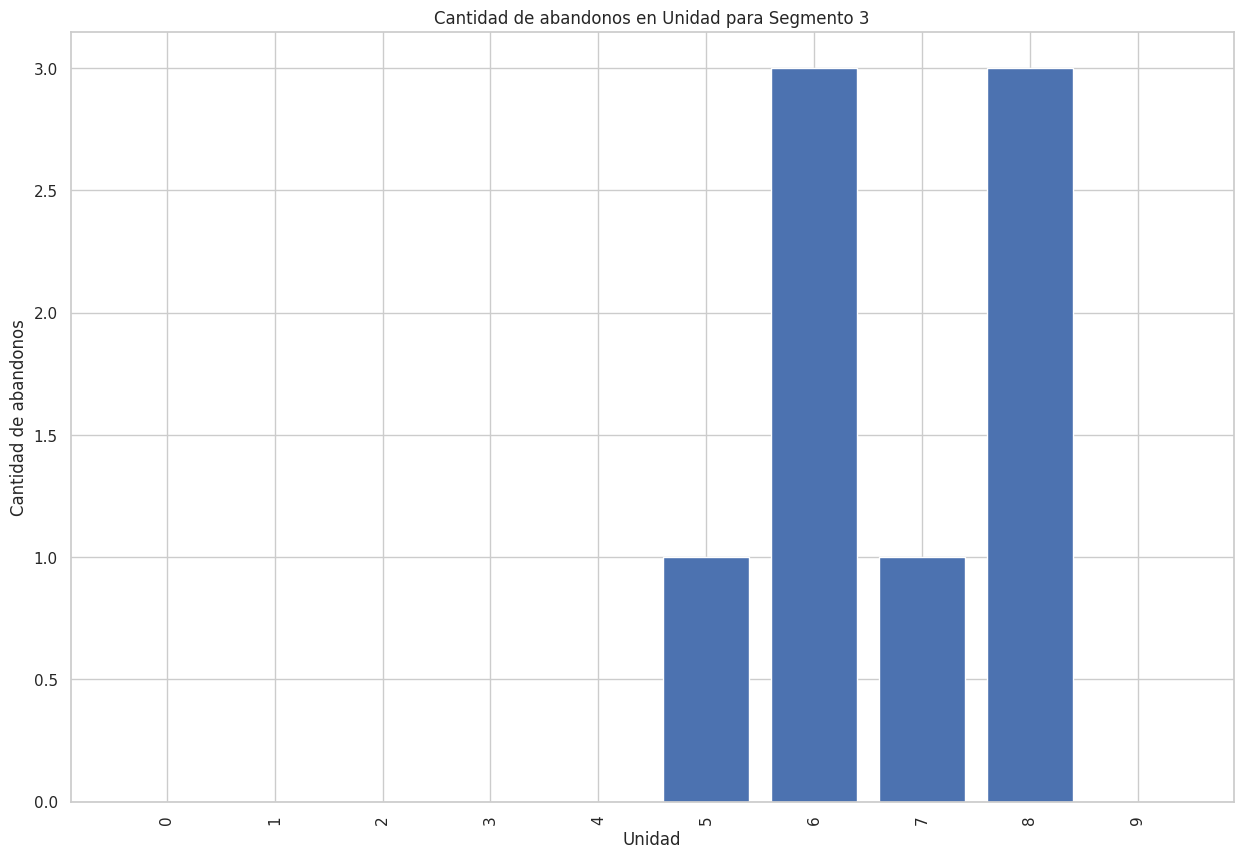

In [234]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(alumnos_por_unidad_que_dejaron_segmento_3.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_abandonos in x_sorted]
items_y = [cantidad_de_abandonos for unidad, cantidad_de_abandonos in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de abandonos')
ax.set_title('Cantidad de abandonos en Unidad para Segmento 3')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


## Reentregas por unidad

Hagamos el mismo análisis pero no tomemos todas las entregas. Tomemos solamente la última entrega de cada unidad, para interpretar "hasta este momento estuve con la unidad".

In [235]:
### ESTO PUEDE LLEGAR A NECESITAR SUBIRSE Y USARSE EN OTROS LUGARES

todas_las_entregas = all_unit_submissions

entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in entregas_por_persona_y_unidad.keys():
        if entrega.unit in entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].append(entrega)
        else:
            entregas_por_persona_y_unidad[entrega.student_record_id].update({entrega.unit: [entrega]})
    else:
        entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: [entrega]}
        
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>],
  4: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 4>],
  5: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 5>],
  6: [<UnitSubmission: rdl

In [236]:
cantidad_de_reentregas_por_persona_por_unidad = {}

for persona, entregas_por_unidad in entregas_por_persona_y_unidad.items():
    cantidad_de_reentregas_por_persona_por_unidad.update({persona: {}})
    for unidad, entregas in entregas_por_unidad.items():
        if len(entregas) > 1:
            cantidad_de_reentregas_por_persona_por_unidad[persona][unidad] = len(entregas) - 1
        else:
            cantidad_de_reentregas_por_persona_por_unidad[persona][unidad] = 0
    
cantidad_de_reentregas_por_persona_por_unidad

{390: {1: 0},
 388: {1: 0},
 387: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 247: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 234: {1: 0, 2: 0, 3: 0},
 268: {1: 0, 2: 0, 3: 0},
 380: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 7: 1, 8: 0, 9: 0, 6: 0},
 368: {1: 0, 2: 0, 3: 1, 4: 2, 5: 0, 6: 0},
 340: {1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 0, 7: 0, 8: 0, 9: 1},
 343: {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 218: {1: 0, 2: 0, 3: 0},
 283: {1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1},
 227: {1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0},
 353: {1: 0, 2: 0, 3: 0},
 339: {1: 1, 2: 1, 3: 2, 4: 1},
 292: {1: 0, 2: 0, 3: 0},
 393: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0},
 355: {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0},
 230: {1: 0, 2: 0, 3: 0, 4: 1, 6: 0, 8: 0, 9: 0, 5: 0, 7: 0},
 248: {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1},
 287: {1: 0, 2: 0, 3: 0, 4: 0},
 264: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 8: 1, 7: 

### Conviene hacer con el promedio aca? 

In [237]:
# Segmento 2
reentregas_por_unidad_segmento_2 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno, reentregas_por_unidad in cantidad_de_reentregas_por_persona_por_unidad.items():
    if alumno in [alumn.id for alumn in alumnos_que_dejaron_en_la_primera_parte_de_la_materia]: 
        for unidad in range(0,10):
            reentregas_por_unidad_segmento_2[unidad] += reentregas_por_unidad.get(unidad, 0)
        
    
reentregas_por_unidad_segmento_2

{0: 0, 1: 5, 2: 4, 3: 3, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

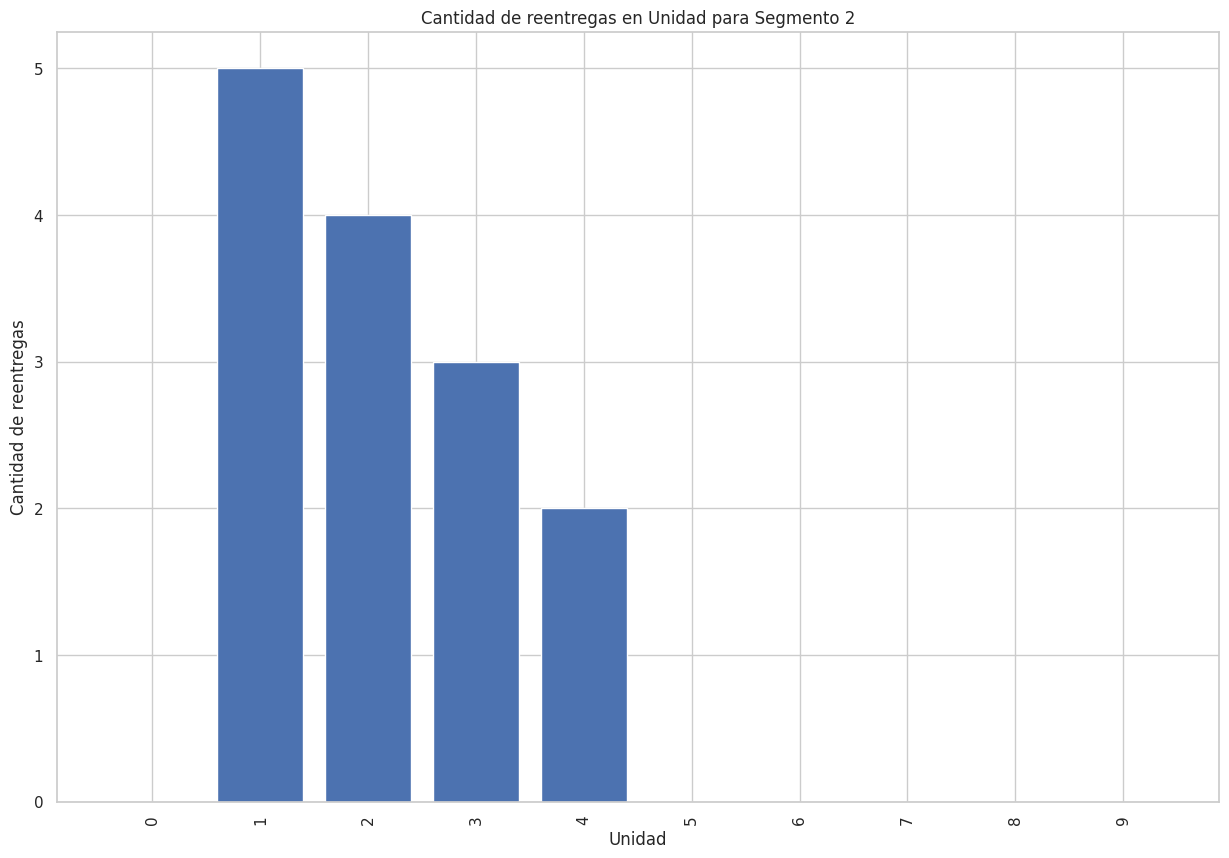

In [238]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(reentregas_por_unidad_segmento_2.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_reentregas in x_sorted]
items_y = [cantidad_de_reentregas for unidad, cantidad_de_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas en Unidad para Segmento 2')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


In [239]:
# Segmento 3
reentregas_por_unidad_segmento_3 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno, reentregas_por_unidad in cantidad_de_reentregas_por_persona_por_unidad.items():
    if alumno in [alumn.id for alumn in alumnos_que_dejaron_en_la_segunda_parte_de_la_materia]: 
        for unidad in range(0,10):
            reentregas_por_unidad_segmento_3[unidad] += reentregas_por_unidad.get(unidad, 0)
        
    
reentregas_por_unidad_segmento_3

{0: 0, 1: 0, 2: 3, 3: 4, 4: 2, 5: 0, 6: 2, 7: 0, 8: 4, 9: 0}

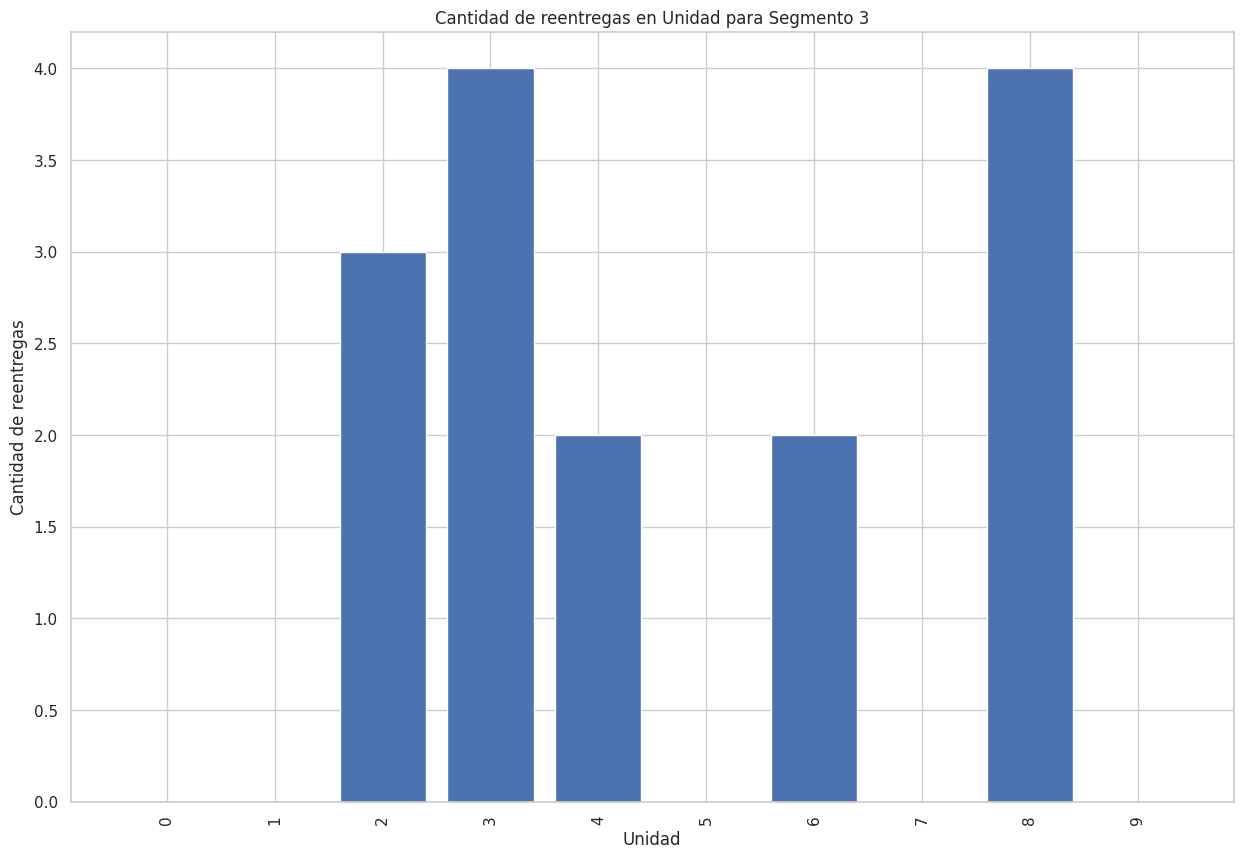

In [240]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(reentregas_por_unidad_segmento_3.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_reentregas in x_sorted]
items_y = [cantidad_de_reentregas for unidad, cantidad_de_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas en Unidad para Segmento 3')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

In [241]:
# Segmento 4
reentregas_por_unidad_segmento_4 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno, reentregas_por_unidad in cantidad_de_reentregas_por_persona_por_unidad.items():
    if alumno in [alumn.id for alumn in alumnos_que_entregaron_todo]: 
        for unidad in range(0,10):
            reentregas_por_unidad_segmento_4[unidad] += reentregas_por_unidad.get(unidad, 0)
        
    
reentregas_por_unidad_segmento_4

{0: 0, 1: 14, 2: 30, 3: 39, 4: 25, 5: 26, 6: 28, 7: 26, 8: 19, 9: 11}

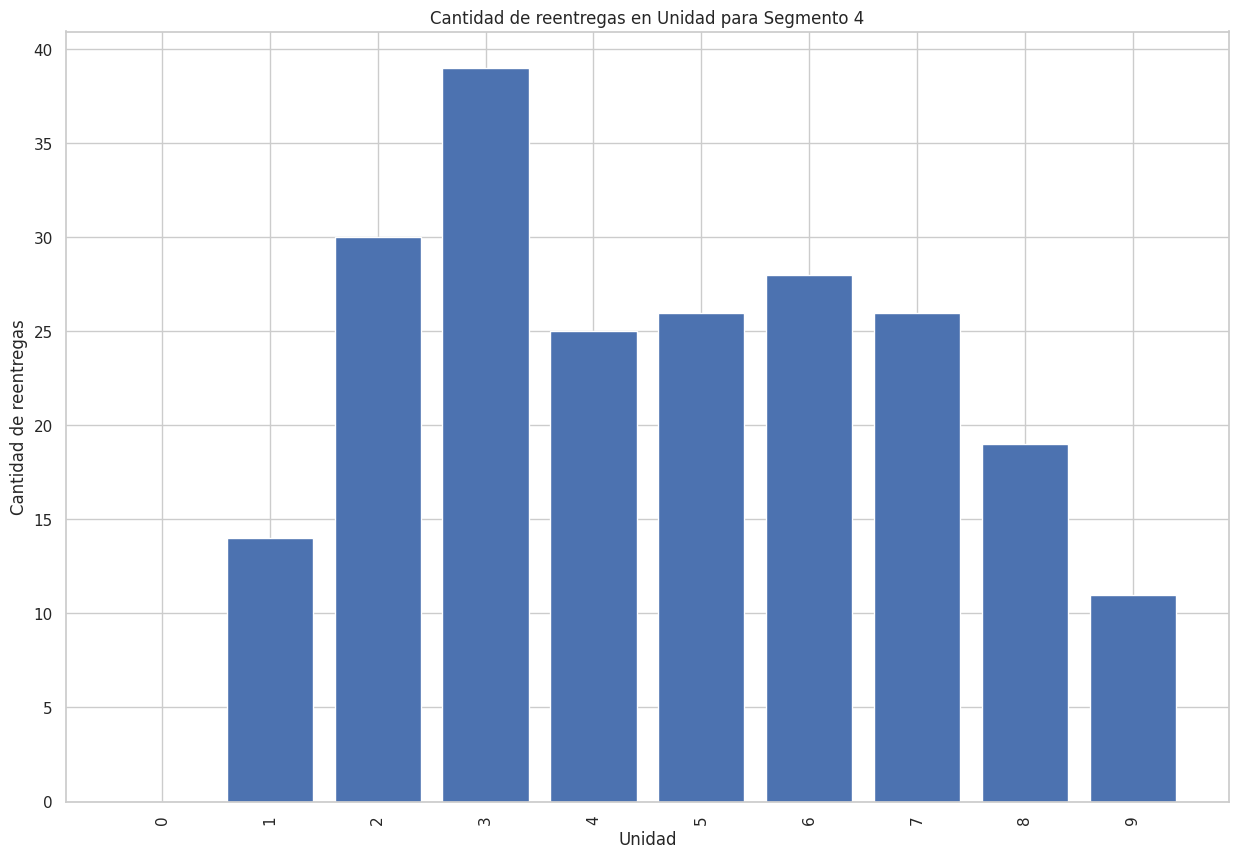

In [242]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(reentregas_por_unidad_segmento_4.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_reentregas in x_sorted]
items_y = [cantidad_de_reentregas for unidad, cantidad_de_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas en Unidad para Segmento 4')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Vamos a ver la cantidad de reentregas en total por grupo. 

### DEBERIAMOS PODER MOSTRAR TODAS LAS REENTREGAS POR GRUPO EN CONJUNTO PARA PODER COMPARAR CORRECTAMENTE. ADEMAS SON DE DISTINTOS TAMAÑOS LOS GRUPOS, COMO NORMALIZAMOS? 

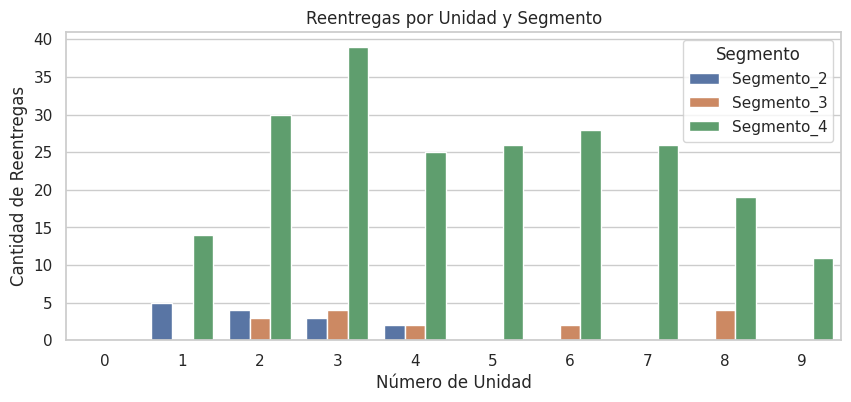

In [243]:
plt.subplots(figsize=(10,4))

# Crear un DataFrame
df = pd.DataFrame({
    'Unidad': list(reentregas_por_unidad_segmento_2.keys()),
    'Segmento_2': list(reentregas_por_unidad_segmento_2.values()),
    'Segmento_3': list(reentregas_por_unidad_segmento_3.values()),
    'Segmento_4': list(reentregas_por_unidad_segmento_4.values())
})

# Derretir el DataFrame para tener una columna para los segmentos
df_melted = pd.melt(df, id_vars='Unidad', var_name='Segmento', value_name='Reentregas')

# Graficar con Seaborn
sns.barplot(x='Unidad', y='Reentregas', hue='Segmento', data=df_melted)
plt.xlabel('Número de Unidad')
plt.ylabel('Cantidad de Reentregas')
plt.title('Reentregas por Unidad y Segmento')

plt.show()

En niveles absolutos, hay mas reentregas de gente que terminó. Lo que puede implicar que si uno reentrega es porque está queriendo terminar la materia. 

Por otro lado, los segmentos no tienen la misma cantidad de personas. Los unicos que son comparables en tamaño son el segmento 2 y el segmento 4. 

### Voy a probar hacer el mismo gráfico con el promedio respecto a la cantidad de personas en el segmento

Algo que te puede pasar también es que tengas una persona q reentrega mucho que no se si mete ruido o ayuda al gráfico. Por ahi se puede hacer promedio hasta sobre la cantidad de personas en el segmento que reentregaron en esa unidad

### Revisar

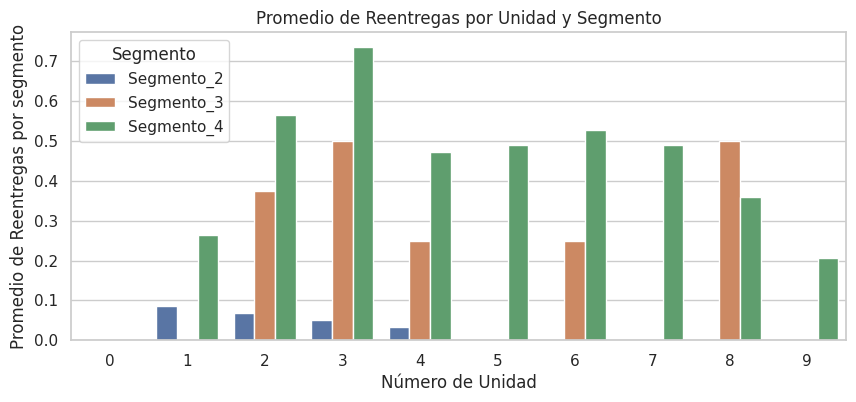

In [244]:
plt.subplots(figsize=(10,4))

# Crear un DataFrame
df = pd.DataFrame({
    'Unidad': list(reentregas_por_unidad_segmento_2.keys()),
    'Segmento_2': [reentrega/len(alumnos_que_dejaron_en_la_primera_parte_de_la_materia) for reentrega in list(reentregas_por_unidad_segmento_2.values())],
    'Segmento_3': [reentrega/len(alumnos_que_dejaron_en_la_segunda_parte_de_la_materia) for reentrega in list(reentregas_por_unidad_segmento_3.values())],
    'Segmento_4': [reentrega/len(alumnos_que_entregaron_todo) for reentrega in list(reentregas_por_unidad_segmento_4.values())]
})

# Derretir el DataFrame para tener una columna para los segmentos
df_melted = pd.melt(df, id_vars='Unidad', var_name='Segmento', value_name='Reentregas')

# Graficar con Seaborn
sns.barplot(x='Unidad', y='Reentregas', hue='Segmento', data=df_melted)
plt.xlabel('Número de Unidad')
plt.ylabel('Promedio de Reentregas por segmento')
plt.title('Promedio de Reentregas por Unidad y Segmento')

plt.show()

De acá aparecen dos cosas curiosas. Una es que si reentregaron en la primera unidad, tenes más chances de que terminen dejando que terminen la materia. Lo que seria interesante es ver si los que reentregaron en la primera unidad y no reentregaron después es porque terminan dejando. 

Otra cosa interesante es lo que sucedió en la unidad 8, donde algunos terminaron dejando y fueron más los que reentregaron. Otro dato interesante del segmento 3 que son pocas personas es la cantidad de reentregas para las unidades 2 y 3. Si lo salvas ahi, alcanza para que termine la materia? 

### Historia de las personas y sus entregas

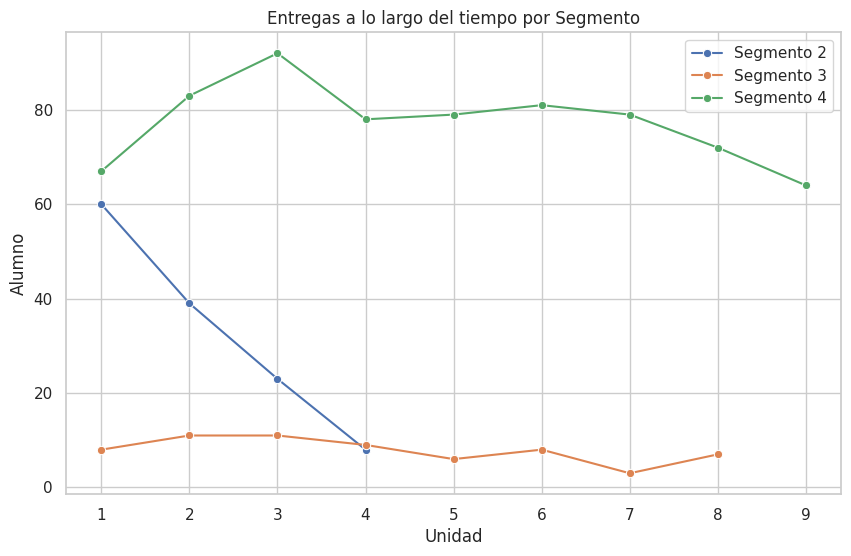

In [245]:
# Filtrar el DataFrame por segmentos
df_segmento_2 = df_unit_submission[df_unit_submission['Alumno'].isin(segmento_2_ids)]
df_segmento_3 = df_unit_submission[df_unit_submission['Alumno'].isin(segmento_3_ids)]
df_segmento_4 = df_unit_submission[df_unit_submission['Alumno'].isin(segmento_4_ids)]

# Calcular la suma de entregas por segmento en cada unidad
df_segmento_2_counts = df_segmento_2.groupby('Unidad').size().reset_index(name='Entregas')
df_segmento_3_counts = df_segmento_3.groupby('Unidad').size().reset_index(name='Entregas')
df_segmento_4_counts = df_segmento_4.groupby('Unidad').size().reset_index(name='Entregas')

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Unidad', y='Entregas', data=df_segmento_2_counts, marker='o', label='Segmento 2')
sns.lineplot(x='Unidad', y='Entregas', data=df_segmento_3_counts, marker='o', label='Segmento 3')
sns.lineplot(x='Unidad', y='Entregas', data=df_segmento_4_counts, marker='o', label='Segmento 4')

plt.xlabel('Unidad')
plt.ylabel('Alumno')
plt.title('Entregas a lo largo del tiempo por Segmento')
plt.legend()
plt.show()

Si reentregar significa que volvi a hacer una entrega de una misma unidad y si dejar significa es cuando entrego una unidad y no entrego ninguna posterior, como identifico a todos aquellos que reentregaron e inmediatamente después dejaron? 

In [246]:
def reentrego_unidad_el_alumno(unidad, alumno):
    return len(entregas_por_persona_y_unidad.get(alumno.id, {}).get(unidad, [])) > 1

In [247]:
def alumnos_que_dejaron_despues_de_reentregar(alumnos):
    alumnos_que_dejaron_despues_de_reentregar = []

    for alumno in alumnos:
        if reentrego_unidad_el_alumno(unidad_en_la_que_dejo(alumno), alumno):
            alumnos_que_dejaron_despues_de_reentregar.append(alumno)
            
    return alumnos_que_dejaron_despues_de_reentregar

In [248]:
print("Alumnos en Segmento 2: " + str(alumnos_que_dejaron_despues_de_reentregar(segmento_2)) + "\n\n")
print("Alumnos en Segmento 3: " + str(alumnos_que_dejaron_despues_de_reentregar(segmento_3)) + "\n\n")
print("Alumnos en Segmento 4: " + str(alumnos_que_dejaron_despues_de_reentregar(segmento_4)) + "\n\n")

Alumnos en Segmento 2: [<StudentRecord: valen.svp@gmail.com>, <StudentRecord: claudiom.ale22@gmail.com>, <StudentRecord: lcorrea@estudiantes.unsam.edu.ar>, <StudentRecord: biasoli.fabrizio@gmail.com>, <StudentRecord: hiturbe@estudiantes.unsam.edu.ar>]


Alumnos en Segmento 3: [<StudentRecord: pablo.ceballos.08@gmail.com>, <StudentRecord: juliandimitri9@gmail.com>]


Alumnos en Segmento 4: [<StudentRecord: paocacchiarelli@gmail.com>, <StudentRecord: clarapalu17@gmail.com>, <StudentRecord: leilaguzman95@gmail.com>, <StudentRecord: loreta.magallanes@unc.edu.ar>, <StudentRecord: juanorlowski@gmail.com>, <StudentRecord: jesica.formoso@gmail.com>, <StudentRecord: maurogajardo19@hotmail.com>, <StudentRecord: lcodesal@estudiantes.unsam.edu.ar>, <StudentRecord: gimarcus@gmail.com>, <StudentRecord: mica.campo@hotmail.com>]




Por ahora no parece muy interesante. La el segmento 4 va a tomar como que la unidad que dejaron es la última unidad y nos va a mostrar solamente a quienes reentregaron. No aporta valor. 

Para el caso del segmento 2, en todos los casos siempre son pocos así que no da tanta información. 

Y para la primera unidad, son solamente 5 personas las que dejaron después de reentregar. Podemos ver en que unidad dejaron.


In [249]:
alumnos_que_dejaron_despues_de_reentregar_segmento_2 = alumnos_que_dejaron_despues_de_reentregar(segmento_2)

for alumno in alumnos_que_dejaron_despues_de_reentregar_segmento_2:
    print(alumno, unidad_en_la_que_dejo(alumno))

valen.svp@gmail.com 1
claudiom.ale22@gmail.com 1
lcorrea@estudiantes.unsam.edu.ar 2
biasoli.fabrizio@gmail.com 4
hiturbe@estudiantes.unsam.edu.ar 4


Podemos ver que de los 5, 2 reentregaron la primera unidad y dejaron. Y 2 de ellos dejaron post parcial (tal vez les fue mal ahi?). Un caso aparentemente raro fue la persona que dejo despues de la segunda unidad. 

### Tiene sentido tratar de explotar por acá? Muy poco dato respecto de los +50 que dejaron en la primera unidad.

Puede llegar a tener sentido saber si alguien que reentrego en la primera parte de la materia, termino dejando en la primera parte de la materia (segmento 2). Lo mismo para la segunda parte de la materia (segmento 3). Del segmento 4 puede ser interesante saber si gente que no reentrego termino entregando todo. 

In [250]:
def alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades(alumnos, unidades_en_que_dejaron, unidades_que_reentregaron):
    alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades = []

    for alumno in alumnos:
        if any([reentrego_unidad_el_alumno(unidad, alumno) for unidad in unidades_que_reentregaron]):
            if unidad_en_la_que_dejo(alumno) in unidades_en_que_dejaron:
                alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades.append(alumno)
            
    return alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades

In [251]:
# Segmento 2

alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades(segmento_2, 
                                                                          unidades_en_que_dejaron=[1, 2, 3, 4],
                                                                          unidades_que_reentregaron=[1, 2, 3, 4])

[<StudentRecord: valen.svp@gmail.com>,
 <StudentRecord: claudiom.ale22@gmail.com>,
 <StudentRecord: trodriguez@inti.gob.ar>,
 <StudentRecord: lcorrea@estudiantes.unsam.edu.ar>,
 <StudentRecord: elianavazquez93@gmail.com>,
 <StudentRecord: biasoli.fabrizio@gmail.com>,
 <StudentRecord: hiturbe@estudiantes.unsam.edu.ar>]

El resultado son 7 (2 más de los que encontramos que reentregaron en inmediatamente después dejaron). 

Son 7 de los 58 que dejaron en la primera parte de la materia. 

### Vale la pena seguir metiendose por aca?


In [252]:
# Segmento 3

alumnos_que_dejaron_en_las_unidades_despues_de_reentregar_en_las_unidades(segmento_3,
                                                                          unidades_en_que_dejaron=[5, 6, 7, 8],
                                                                          unidades_que_reentregaron=[5, 6, 7, 8])

[<StudentRecord: noelfederman@gmail.com>,
 <StudentRecord: pablo.ceballos.08@gmail.com>,
 <StudentRecord: juliandimitri9@gmail.com>]

Nos pasa algo parecido con el segmento 2. 2 de las 3 personas reentregaron algo. Este segmento igual es complicado porque siempre tiene pocas personas. Pero 3 de 8 reentregaron y no terminaron la segunda parte de la materia.

In [253]:
# Segmento 4
# Del segmento 4 puede ser interesante saber si gente que no reentrego termino entregando todo.

alumnos = segmento_4

alumnos_que_terminaron_y_no_reentregaron = []

for alumno in alumnos:
    if all([not reentrego_unidad_el_alumno(unidad, alumno) for unidad in [1, 2, 3, 4, 5, 6, 7, 8, 9]]):
        alumnos_que_terminaron_y_no_reentregaron.append(alumno)

alumnos_que_terminaron_y_no_reentregaron

[<StudentRecord: fedemorales93@gmail.com>,
 <StudentRecord: rdledesma1995@gmail.com>,
 <StudentRecord: fermag.and@gmail.com>,
 <StudentRecord: navarro.gabriel2001@gmail.com>,
 <StudentRecord: sofi.ferradans@gmail.com>,
 <StudentRecord: nicolas.clauser@gmail.com>,
 <StudentRecord: juan.manu2699@gmail.com>]

Tan solo 7 personas de las 53 que entregaron todas las unidades NO reentregaron algo. No pareciera que pudieramos decir nada de esto? 

Veamos cuantas personas en total no reentregaron nunca, a pesar de haber dejado y sepamos en qué unidad dejaron.

In [254]:
def alumnos_que_no_reentregaron(alumnos):

    alumnos_que_no_reentregaron = []

    for alumno in alumnos:
        if all([not reentrego_unidad_el_alumno(unidad, alumno) for unidad in [1, 2, 3, 4, 5, 6, 7, 8, 9]]):
            alumnos_que_no_reentregaron.append((alumno, unidad_en_la_que_dejo(alumno)))

    return alumnos_que_no_reentregaron

In [255]:
alumnos_que_no_reentregaron(segmento_2 + segmento_3 + segmento_4)

[(<StudentRecord: macarenamarello@gmail.com>, 1),
 (<StudentRecord: alejandroarata@gmail.com>, 1),
 (<StudentRecord: florenciamartinezh@gmail.com>, 1),
 (<StudentRecord: reta.paulo@gmail.com>, 1),
 (<StudentRecord: nicolaskellenbach@hotmail.com>, 1),
 (<StudentRecord: ansarce@gmail.com>, 1),
 (<StudentRecord: gonzalez.an90@gmail.com>, 1),
 (<StudentRecord: simongomezcarrillo@live.com>, 1),
 (<StudentRecord: evangelistamelinapaula@gmail.com>, 1),
 (<StudentRecord: jm.siekan@gmail.com>, 1),
 (<StudentRecord: simoniniflorencia@gmail.com>, 1),
 (<StudentRecord: guerralara@agro.uba.ar>, 1),
 (<StudentRecord: cintia.ueducativo@gmail.com>, 1),
 (<StudentRecord: alvarezng97@gmail.com>, 1),
 (<StudentRecord: fdcabrini@gmail.com>, 1),
 (<StudentRecord: aperez@estudiantes.unsam.edu.ar>, 1),
 (<StudentRecord: otromailmas@gmail.com>, 1),
 (<StudentRecord: unmail@gmail.com>, 1),
 (<StudentRecord: silvanaisabelmartinez@gmail.com>, 2),
 (<StudentRecord: ignaciotumas@unc.edu.ar>, 2),
 (<StudentRecord: 

In [256]:
len(alumnos_que_no_reentregaron(segmento_2 + segmento_3 + segmento_4))

60

In [257]:
# Inicializar un diccionario para contar cuántas personas dejaron en cada unidad
diccionario_unidad_en_la_que_dejaron = {}

# Recorrer la lista de tuplas
for estudiante, unidad in alumnos_que_no_reentregaron(segmento_2 + segmento_3 + segmento_4):
    # Verificar si la unidad ya está en el diccionario
    if unidad in diccionario_unidad_en_la_que_dejaron:
        # Si está, incrementar el contador
        diccionario_unidad_en_la_que_dejaron[unidad] += 1
    else:
        # Si no está, agregar la unidad al diccionario con un contador de 1
        diccionario_unidad_en_la_que_dejaron[unidad] = 1

# Mostrar el diccionario resultante
print(diccionario_unidad_en_la_que_dejaron)

{1: 18, 2: 16, 3: 14, 4: 3, 5: 1, 6: 1, 9: 7}


In [258]:
cantidad_alumnos_por_unidad_que_dejaron

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

## Parece que encontramos algo! 

La clave parece estar en la gente que no reentrega nunca. La cantidad de abandonos en general tiene una proporción muy alta de gente que no reentrego nunca. Más que nada al principio de la materia. 

Cuál es el patrón de reentrega? Por qué la gente reentrega? Porque vuelve a mandar algo que hizo? Por que le faltaron ejercicios y por eso lo contamos como reentrega? 

### Reentregas a partir de Ejercicios

Bajo la definición de reentrega como más de una entrega de una unidad en particular, no necesariamente estamos viendo a la gente que reentregó algún ejercicio particular. 

Necesitamos bajar la granularidad a las entregas de los ejercicios 

In [259]:
df_ejercicios_en_profundidad

,EjercicioID,UnitSubmissionID,NombreEjercicio,Alumno,Unidad,FechaEntrega,AceptaPairReview,Genero,Pais,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,25,16,rebotes.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
1,26,16,hipoteca.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
2,27,16,esfera.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
3,28,16,geringoso.py,390,1,2022-03-09 16:52:51.340012+00:00,False,3,ARGENTINA,CABA,Buenos Aires,IFIBYNE,,Doctorado,3.0,2.0,,,
4,29,17,rebotes.py,388,1,2022-03-09 17:20:38.676259+00:00,False,3,Argentina,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,3040,927,lote.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2951,3041,927,torre_control.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2952,3042,927,canguros_buenos.py,226,9,2022-06-02 21:09:02.528814+00:00,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,
2953,3043,928,mareas_a_mano.py,397,8,2022-06-04 15:49:01.419799+00:00,False,3,-,-,-,,,,NaN,NaN,,,


In [260]:
# Segmento 2
import numpy

filtered_df = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_2_ids)]

result = filtered_df.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Counts')

result

,Alumno,NombreEjercicio,Unidad,Counts
0,214,buscar_precios.py,2,1
1,214,camion_commandline.py,2,1
2,214,costo_camion.py,2,1
3,214,diccionario_geringoso.py,2,1
4,214,geringoso.py,1,1
...,...,...,...,...
425,403,costo_camion.py,3,1
426,403,diccionario_geringoso.py,2,1
427,403,esfera.py,1,1
428,403,geringoso.py,1,1


/tmp/ipykernel_14345/2199702042.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)


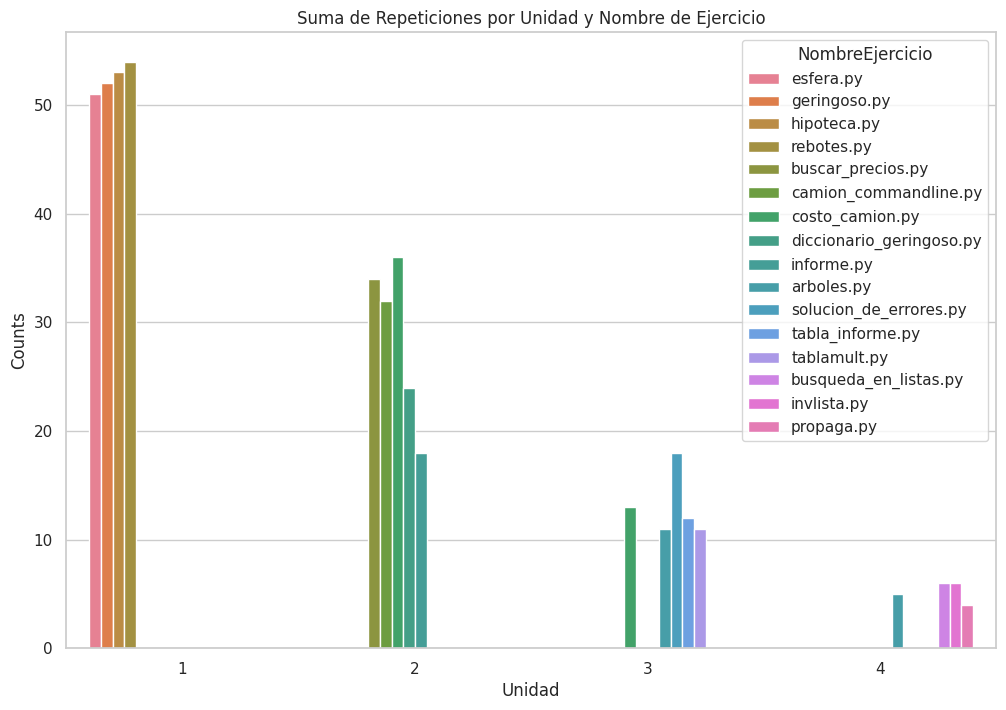

In [261]:
agg_result = result.groupby(['Unidad', 'NombreEjercicio']).agg({'Counts': 'sum'}).reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)
plt.title('Suma de Repeticiones por Unidad y Nombre de Ejercicio')
plt.show()

In [262]:
# Segmento 3
import numpy

filtered_df = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_3_ids)]

result = filtered_df.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Counts')

result

,Alumno,NombreEjercicio,Unidad,Counts
0,216,arboles.py,3,1
1,216,arboles.py,4,1
2,216,bbin.py,6,1
3,216,buscar_precios.py,2,1
4,216,busqueda_en_listas.py,4,1
...,...,...,...,...
177,397,solucion_de_errores.py,3,1
178,397,tabla_informe.py,3,1
179,397,tablamult.py,3,1
180,397,termometro.py,5,1


/tmp/ipykernel_14345/2199702042.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)


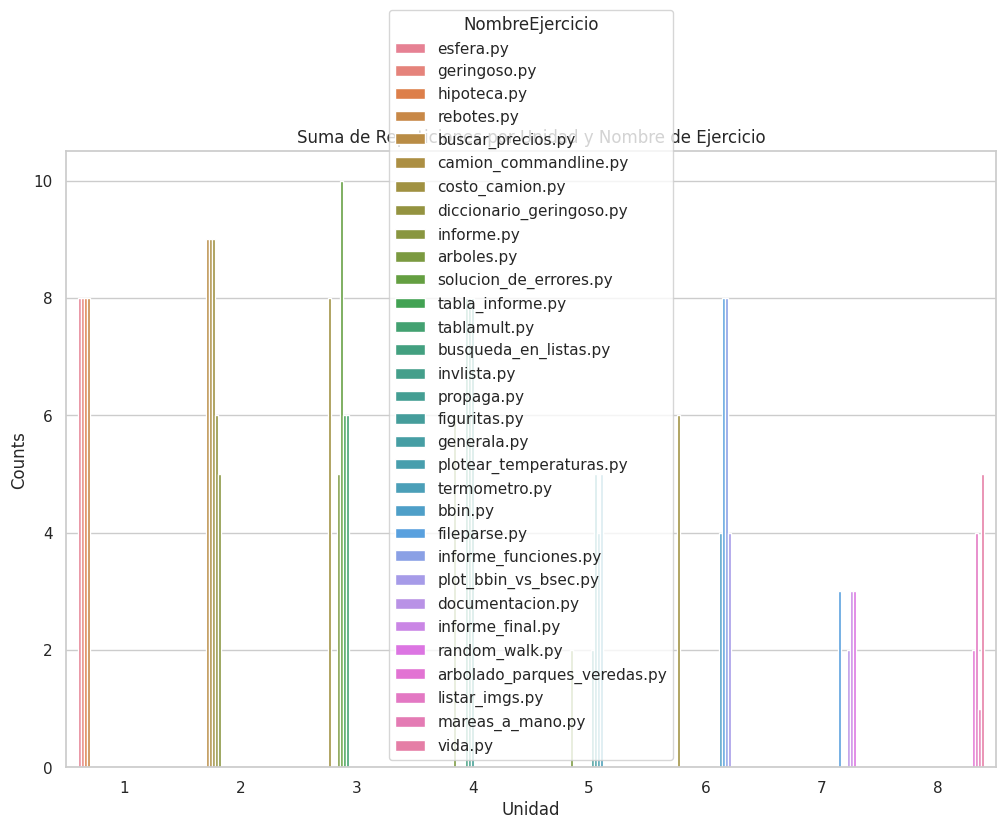

In [263]:
agg_result = result.groupby(['Unidad', 'NombreEjercicio']).agg({'Counts': 'sum'}).reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)
plt.title('Suma de Repeticiones por Unidad y Nombre de Ejercicio')
plt.show()

In [264]:
# Segmento 4
import numpy

filtered_df = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_4_ids)]

result = filtered_df.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Counts')

result

,Alumno,NombreEjercicio,Unidad,Counts
0,222,arbolado_parques_veredas.py,8,1
1,222,arboles.py,3,1
2,222,arboles.py,4,1
3,222,arboles.py,5,1
4,222,bbin.py,6,2
...,...,...,...,...
2084,402,tabla_informe.py,3,1
2085,402,tablamult.py,3,1
2086,402,termometro.py,5,1
2087,402,torre_control.py,9,1


/tmp/ipykernel_14345/2199702042.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)


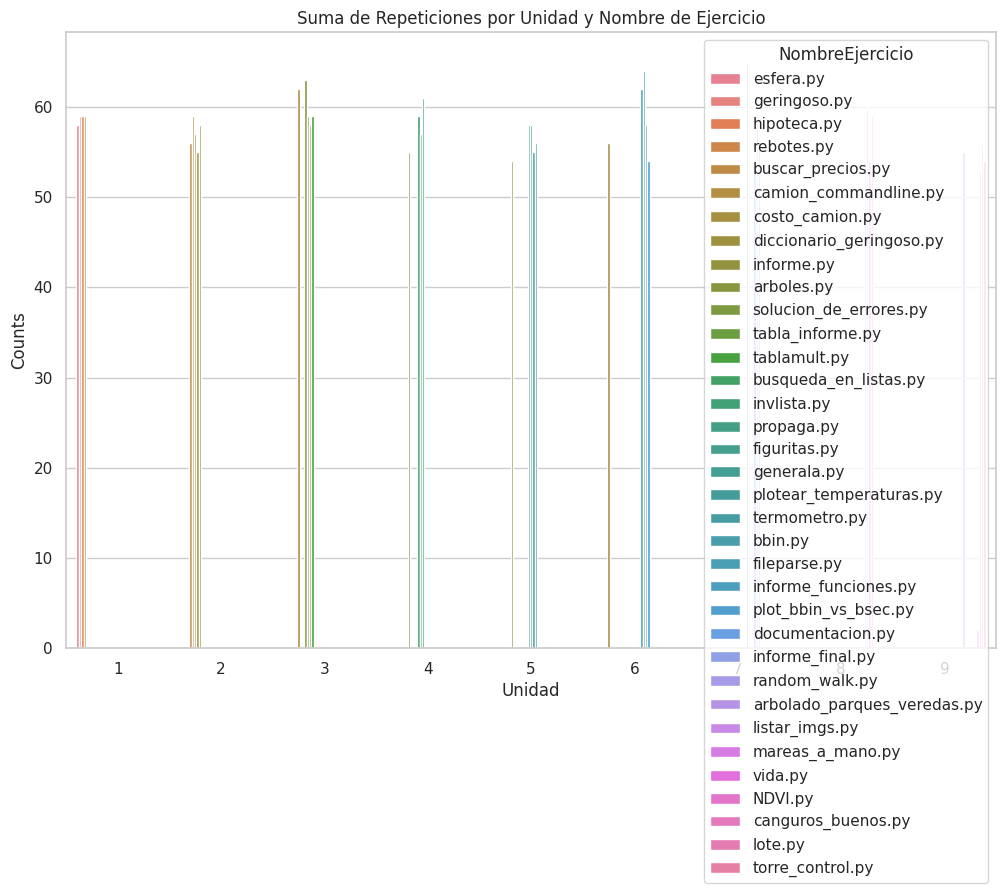

In [265]:
agg_result = result.groupby(['Unidad', 'NombreEjercicio']).agg({'Counts': 'sum'}).reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='Unidad', y='Counts', hue='NombreEjercicio', data=agg_result, ci=None)
plt.title('Suma de Repeticiones por Unidad y Nombre de Ejercicio')
plt.show()

Lo que quiero armarme es un dataframe solamente con los alumnos que reentregaron algun ejercicio. 

In [266]:
import pandas as pd

# Supongamos que df_ejercicios_en_profundidad es tu DataFrame

# Contar el número de filas para cada combinación de nombreEjercicio, Unidad y Alumno
conteo_filas = df_ejercicios_en_profundidad.groupby(['NombreEjercicio', 'Unidad', 'Alumno']).size().reset_index(name='conteo')

df_reentregas_de_ejercicios_por_alumno = conteo_filas[conteo_filas['conteo'] > 1][['NombreEjercicio', 'Unidad', 'Alumno']]

# Ahora df_resultado contiene solo las filas para los alumnos que cumplen con tu criterio
df_reentregas_de_ejercicios_por_alumno

,NombreEjercicio,Unidad,Alumno
20,arbolado_parques_veredas.py,8,283
35,arbolado_parques_veredas.py,8,355
68,arboles.py,3,242
77,arboles.py,3,282
79,arboles.py,3,284
...,...,...,...
2674,vida.py,8,326
2677,vida.py,8,351
2688,vida.py,8,377
2689,vida.py,8,379


In [267]:
# Agregar una columna 'Reentrega' que indica si es una reentrega o no
df_ejercicios_en_profundidad['Reentrega'] = df_ejercicios_en_profundidad.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).cumcount()

# Contar la cantidad de reentregas por cada combinación de Alumno y nombreEjercicio
conteo_reentregas = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Reentrega'] > 0].groupby(['Alumno', 'Unidad', 'NombreEjercicio']).size().reset_index(name='cantidad_reentregas')

# Ahora conteo_reentregas contiene la cantidad de reentregas por cada alumno y ejercicio
conteo_reentregas

,Alumno,Unidad,NombreEjercicio,cantidad_reentregas
0,222,6,bbin.py,1
1,222,7,fileparse.py,1
2,226,9,canguros_buenos.py,1
3,226,9,informe_final.py,1
4,226,9,lote.py,1
...,...,...,...,...
234,396,1,rebotes.py,1
235,396,3,solucion_de_errores.py,1
236,397,8,vida.py,1
237,402,2,informe.py,1


In [268]:
lista_alumnos_que_reentregaron = conteo_reentregas['Alumno'].unique()
lista_alumnos_que_reentregaron

array([222, 226, 227, 232, 238, 239, 242, 246, 248, 253, 261, 264, 273,
       274, 278, 282, 283, 284, 288, 289, 296, 305, 306, 310, 314, 320,
       326, 339, 340, 346, 351, 355, 362, 365, 367, 368, 372, 373, 374,
       375, 377, 379, 380, 381, 385, 392, 393, 396, 397, 402])

In [269]:
# Crear diccionario para almacenar la cuenta de alumnos por segmento
cuenta_por_segmento = {}

# Contar alumnos en segmento_1
cuenta_por_segmento['segmento_1'] = len(set(segmento_1_ids).intersection(lista_alumnos_que_reentregaron))

# Contar alumnos en segmento_2
cuenta_por_segmento['segmento_2'] = len(set(segmento_2_ids).intersection(lista_alumnos_que_reentregaron))

# Contar alumnos en segmento_3
cuenta_por_segmento['segmento_3'] = len(set(segmento_3_ids).intersection(lista_alumnos_que_reentregaron))

# Contar alumnos en segmento_4
cuenta_por_segmento['segmento_4'] = len(set(segmento_4_ids).intersection(lista_alumnos_que_reentregaron))

# Ahora cuenta_por_segmento contiene la cuenta de alumnos por cada segmento
cuenta_por_segmento


{'segmento_1': 0, 'segmento_2': 4, 'segmento_3': 5, 'segmento_4': 41}

In [270]:
cantidad_alumnos_por_unidad_que_dejaron

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

### PRIMERA GRAN CONCLUSION

Naturalmente, la gente en el segmento_1 (que no entregó nada), no tiene reentregas.

La gente del segmento_2 (hasta unidad 4) son 58 personas. De las cuales 4 solamente reentregaron ejercicios. 

La gente del segmento_3 (que no terminaron todas las unidades) son 8. De las cuales 5 reentregaron ejercicios.

La gente del segmento_4 (que entregaron todo) son 53. De las cuales 41 reentregaron ejercicios.  

Entonces, las probabilidades de que dejen si no reentregaron ejercicios son:

In [271]:
# Segmento 2
1 - cuenta_por_segmento['segmento_2'] / 58

0.9310344827586207

In [272]:
# Segmento 3
1 - cuenta_por_segmento['segmento_3'] / 8

0.375

In [273]:
# Segmento 4
1 - cuenta_por_segmento['segmento_4'] / 53

0.2264150943396226

In [274]:
lista_alumnos_que_reentregaron

array([222, 226, 227, 232, 238, 239, 242, 246, 248, 253, 261, 264, 273,
       274, 278, 282, 283, 284, 288, 289, 296, 305, 306, 310, 314, 320,
       326, 339, 340, 346, 351, 355, 362, 365, 367, 368, 372, 373, 374,
       375, 377, 379, 380, 381, 385, 392, 393, 396, 397, 402])

In [275]:
reentregantes_de_segmento_2 = StudentRecord.objects.filter(id__in=set(segmento_2_ids).intersection(lista_alumnos_que_reentregaron))

In [276]:
reentregantes_de_segmento_3 = StudentRecord.objects.filter(id__in=set(segmento_3_ids).intersection(lista_alumnos_que_reentregaron))

In [277]:
for reentregante in reentregantes_de_segmento_2: 
    unit_submissions = all_unit_submissions.filter(student_record=reentregante)
    print(f'Email: {reentregante.email}: \n')
    print(f'Unidades: {[(unit_submission.unit, unit_submission.datetime) for unit_submission in unit_submissions]}\n')
    print(f'Ejercicios: {all_exercises.filter(unit_submission__in=unit_submissions)}\n\n\n\n')
    
# Fecha de entrega de la Unidad 1 es el 16/03 (17/03 00:00hs GMT-3)
# valen.svp@gmail.com: Mismos ejercicios, con un dia de diferencia. Hay que profundizar
# gonzalez.an90@gmail.com: Mismos ejercicios, practicamente en el mismo momento. Revisar si es el mismo archivo siempre porque entrego lo mismo y descartar.
# jm.siekan@gmail.com: Mismo escenario al anterior.
# biasoli.fabrizio@gmail.com: No hizo la 3 pero despues entregó post primer parcial. Todas las reentregas son en ese post parcial. REVISAR, POR QUE DEJO? REVISAR EJERCICIOS
# lcorrea@estudiantes.unsam.edu.ar: Solamente reentrego el ejercicio buscar_precios.py de la unidad 2. La reentrega fue más cerca en tiempo. Hay que ver si son distintos archivos. Hizo dos Unit Submissions para entregar todos los ejercicios una sola vez en la unidad 1.
# hiturbe@estudiantes.unsam.edu.ar: Entrego todo a tiempo, y reentrego sobre la fecha final que tenian para reentregar. La unidad 3 y 4 hizo varias entregas el mismo dia justo antes de que termine el plazo.

Email: valen.svp@gmail.com: 

Unidades: [(1, datetime.datetime(2022, 3, 16, 13, 16, 0, 287168, tzinfo=<UTC>)), (1, datetime.datetime(2022, 3, 17, 22, 57, 17, 920016, tzinfo=<UTC>))]

Ejercicios: <QuerySet [<Exercise: Ejercicio rebotes.py de valen.svp@gmail.com>, <Exercise: Ejercicio hipoteca.py de valen.svp@gmail.com>, <Exercise: Ejercicio rebotes.py de valen.svp@gmail.com>, <Exercise: Ejercicio hipoteca.py de valen.svp@gmail.com>]>




Email: biasoli.fabrizio@gmail.com: 

Unidades: [(1, datetime.datetime(2022, 3, 16, 15, 18, 8, 675905, tzinfo=<UTC>)), (2, datetime.datetime(2022, 3, 23, 17, 17, 26, 619342, tzinfo=<UTC>)), (4, datetime.datetime(2022, 4, 6, 12, 7, 5, 935296, tzinfo=<UTC>)), (2, datetime.datetime(2022, 4, 13, 21, 16, 4, 201345, tzinfo=<UTC>)), (3, datetime.datetime(2022, 4, 13, 21, 33, 36, 203686, tzinfo=<UTC>)), (4, datetime.datetime(2022, 4, 14, 13, 7, 19, 75882, tzinfo=<UTC>))]

Ejercicios: <QuerySet [<Exercise: Ejercicio rebotes.py de biasoli.fabrizio@gmail.com>, <Exe

In [278]:
def reporte_para(email):
    student_record = StudentRecord.objects.get(email=email)
    
    unit_submissions = all_unit_submissions.filter(student_record=student_record)
    
    print(f'Unidad en la que dejo: {unidad_en_la_que_dejo(student_record)}')
    print('\n\n\n')

    
    exercises = all_exercises.filter(unit_submission__in=unit_submissions)
    for exercise in exercises:
        print(f'Exercise id: {exercise.id}\n')
        print(f'Unidad: {exercise.unit()}')
        print(f'{exercise.solution}\n')

    print('\n\n\n')

    print("Autoevaluacion\n")                                        
    self_evaluations = all_self_evaluations.filter(unit_submission__in=unit_submissions)
    for self_evaluation in self_evaluations:
        print(f'ID: {self_evaluation.id}')
        print(f'Unidad: {self_evaluation.unit_submission.unit}')
        print(f'Content_learning: {self_evaluation.readable_content_learning()}')
        print(f'Exercises Autograde: {self_evaluation.readable_exercises_autograde()}')
        print(f'Dedication In Hours: {self_evaluation.dedication_in_hours}')
        print(f'Dedidation Evaluation: {self_evaluation.readable_dedication_evaluation()}')
        print(f'Comment: {self_evaluation.comment}')
        print('\n')

    print('\n\n\n')

    print('Correcciones Automaticas HACER')

    print('\n\n\n')

    print('Correcciones Docentes:')
    corrections = Correction.objects.filter(exercise__in=exercises, done=True)
    print(corrections)
    for correction in corrections:
        print(f'Reviewer: {correction.reviewer}')
        print(f'Solves Exercise: {correction.readable_solves_exercise()}')
        print(f'Code Presentation: {correction.code_presentation}')
        print(f'Works: {correction.readable_works()}')
        print(f'Tests: {correction.readable_tests()}')
        print(f'Grade: {correction.grade}')
        print(f'Comment for author: {correction.comment_for_author}')
        print(f'Comment for teachers: {correction.comment_for_teachers}')
        print(f'Dedidation in minutes: {correction.correction_time_in_minutes}')
        print('\n')

    print('\n\n\n')

    print('Code Evaluation - Correcciones Docentes:')
    code_evaluations = CodeEvaluation.objects.filter(correction__in=corrections)
    for code_evaluation in code_evaluations:
        print(f'Clarity: {code_evaluation.readable_clarity()}')
        print(f'Declarative: {code_evaluation.readable_declarative()}')
        print(f'Modular: {code_evaluation.readable_modular()}')
        print(f'Reusable: {code_evaluation.readable_reusable()}')
        print(f'Python: {code_evaluation.readable_python()}')
        print(f'Commented: {code_evaluation.readable_commented()}')
        print('\n')


    print('\n\n\n') 

    print(f'Unidad y si acepta pair review: {[(unit_submission, unit_submission.accepts_pair_review, unit_submission.pair_review_comment) for unit_submission in unit_submissions]}\n')

    print('Correcciones entre pares:')
    pair_reviews = PairReviewCorrection.objects.filter(exercise__in=exercises)
    for pair_review in pair_reviews:
        print(f'Pair Reviewer: {pair_review.reviewer}\n')
        print(f'Comment for Author: {pair_review.comment_for_author}\n')
        print(f'Correction Datetime: {pair_review.correction_datetime}\n')
        print(f'Is Anonymous Reviewer: {pair_review.is_anonymous_reviewer}\n')
        print(f'Done: {pair_review.done}\n')
        print(f'Published: {pair_review.published}\n')

    print('\n\n\n') 



In [279]:
# valen.svp@gmail.com: Mismos ejercicios, con un dia de diferencia. Hay que profundizar
reporte_para(email='valen.svp@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 


print("Hizo cambios en hipoteca.py. Sacó algunos ifs e hizo un poco mas legible el código. Puede que haya corregido un bug")                                        


Unidad en la que dejo: 1




Exercise id: 331

Unidad: 1
uploads/2022-03-16_131600.322672_val_rebotes.py

Exercise id: 332

Unidad: 1
uploads/2022-03-16_131600.384960_val_Bonus.py

Exercise id: 498

Unidad: 1
uploads/2022-03-17_225718.016521_val_rebotes.py

Exercise id: 499

Unidad: 1
uploads/2022-03-17_225718.106629_val_Bonus.py





Autoevaluacion

ID: 87
Unidad: 1
Content_learning: Me costó entender
Exercises Autograde: Me costaron mucho trabajo
Dedication In Hours: 9
Dedidation Evaluation: Me llevó más tiempo del que me hubiera gustado dedicarle
Comment: Me gustaría que haya una explicación en clase de los ejercicios para entender mejor






Correcciones Automaticas HACER




Correcciones Docentes:
<QuerySet []>




Code Evaluation - Correcciones Docentes:




Unidad y si acepta pair review: [(<UnitSubmission: valen.svp@gmail.com: Unidad 1>, False, ''), (<UnitSubmission: valen.svp@gmail.com: Unidad 1>, False, '')]

Correcciones entre pares:








Conclusiones



Hizo cambios en 

In [280]:
# gonzalez.an90@gmail.com: Mismos ejercicios, practicamente en el mismo momento. Revisar si es el mismo archivo siempre porque entrego lo mismo y descartar.
reporte_para(email='gonzalez.an90@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 
print("Entrego lo mismo con pocos minutos de diferencia. Bug de usabilidad?")                                        

print('\n\n\n')


Unidad en la que dejo: 1




Exercise id: 488

Unidad: 1
uploads/2022-03-17_015523.315334_gon_rebotes.py

Exercise id: 489

Unidad: 1
uploads/2022-03-17_015523.323560_gon_Esfera.py

Exercise id: 490

Unidad: 1
uploads/2022-03-17_015523.331834_gon_Geringoso.py





Autoevaluacion

ID: 126
Unidad: 1
Content_learning: Me costó entender
Exercises Autograde: Me costaron mucho trabajo
Dedication In Hours: 12
Dedidation Evaluation: Me pareció adecuado
Comment: Seria ideal contar videos explicativos.






Correcciones Automaticas HACER




Correcciones Docentes:
<QuerySet []>




Code Evaluation - Correcciones Docentes:




Unidad y si acepta pair review: [(<UnitSubmission: gonzalez.an90@gmail.com: Unidad 1>, True, '')]

Correcciones entre pares:








Conclusiones



Entrego lo mismo con pocos minutos de diferencia. Bug de usabilidad?






In [281]:
# jm.siekan@gmail.com: Mismo escenario al anterior.
reporte_para(email='jm.siekan@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Entrego lo mismo con pocos minutos de diferencia. Bug de usabilidad?")                                        

print('\n\n\n')


Unidad en la que dejo: 1




Exercise id: 338

Unidad: 1
uploads/2022-03-16_132138.936879_jm._esfera.py

Exercise id: 339

Unidad: 1
uploads/2022-03-16_132138.979595_jm._rebotes.py

Exercise id: 340

Unidad: 1
uploads/2022-03-16_132138.991211_jm._geringoso.py

Exercise id: 341

Unidad: 1
uploads/2022-03-16_132138.999446_jm._ejercicio_hipoteca.py





Autoevaluacion

ID: 89
Unidad: 1
Content_learning: Me costó entender
Exercises Autograde: Me costaron mucho trabajo
Dedication In Hours: 12
Dedidation Evaluation: Me pareció adecuado
Comment: Está muy bueno el contenido, estoy contento de poder participar. Me cuesta mucho, pero es así la programación. Perdón pero no tengo mucho tiempo para poder ayudar en la semana a los compañeros y aparte no tengo tanto conocimiento, me siento inseguro.






Correcciones Automaticas HACER




Correcciones Docentes:
<QuerySet []>




Code Evaluation - Correcciones Docentes:




Unidad y si acepta pair review: [(<UnitSubmission: jm.siekan@gmail.com: Unida

In [282]:
# biasoli.fabrizio@gmail.com: No hizo la 3 pero despues entregó post primer parcial. Todas las reentregas son en ese post parcial. REVISAR, POR QUE DEJO? REVISAR EJERCICIOS
reporte_para(email='biasoli.fabrizio@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Volvio a entregar correctamente. Esta persona podria haber seguido la materia y dejo. ")                                        

print('\n\n\n')

print('Aca la persona venia bastante bien. Hay un comentario raro en la correccion que habla sobre el año que viene. Ya se sabia que dejaba o era algo del ejercicio?')

Unidad en la que dejo: 4




Exercise id: 409

Unidad: 1
uploads/2022-03-16_151808.784435_bia_rebotes.py

Exercise id: 410

Unidad: 1
uploads/2022-03-16_151808.811745_bia_bonushipoteca.py

Exercise id: 411

Unidad: 1
uploads/2022-03-16_151808.836867_bia_Esfera.py

Exercise id: 412

Unidad: 1
uploads/2022-03-16_151808.861686_bia_Geringoso.py

Exercise id: 869

Unidad: 2
uploads/2022-03-23_171726.800850_bia_buscar_precios.py

Exercise id: 870

Unidad: 2
uploads/2022-03-23_171726.857143_bia_costo_camion.py

Exercise id: 871

Unidad: 2
uploads/2022-03-23_171726.938541_bia_camion_commandline.py

Exercise id: 1318

Unidad: 4
uploads/2022-04-06_120706.025654_bia_busqueda_en_listas.py

Exercise id: 1319

Unidad: 4
uploads/2022-04-06_120706.040476_bia_invlista.py

Exercise id: 1320

Unidad: 4
uploads/2022-04-06_120706.050620_bia_propaga.py

Exercise id: 1673

Unidad: 2
uploads/2022-04-13_211604.318168_bia_diccionario_geringoso.py

Exercise id: 1674

Unidad: 2
uploads/2022-04-13_211604.326402_bi

In [283]:
# lcorrea@estudiantes.unsam.edu.ar: Solamente reentrego el ejercicio buscar_precios.py de la unidad 2. La reentrega fue más cerca en tiempo. Hay que ver si son distintos archivos. Hizo dos Unit Submissions para entregar todos los ejercicios una sola vez en la unidad 1.

reporte_para(email='lcorrea@estudiantes.unsam.edu.ar')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Volvio a entregar correctamente. Esta persona podria haber seguido la materia y dejo. Las entregas parecen bastante buenas pero la autoevaluación es baja")                                        

print('\n\n\n')

print('Las entregas parecen bastante bien, la corrección docente le fue bien, pero las autoevaluaciones son medio bajas.')

Unidad en la que dejo: 2




Exercise id: 285

Unidad: 1
uploads/2022-03-16_060727.374969_lco_rebotes.py

Exercise id: 286

Unidad: 1
uploads/2022-03-16_060727.483299_lco_hipoteca.py

Exercise id: 287

Unidad: 1
uploads/2022-03-16_060727.633328_lco_esfera.py

Exercise id: 440

Unidad: 1
uploads/2022-03-16_155349.380456_lco_geringoso.py

Exercise id: 848

Unidad: 2
uploads/2022-03-23_165348.334999_lco_buscar_precio.py

Exercise id: 849

Unidad: 2
uploads/2022-03-23_165348.343772_lco_costo_camion.py

Exercise id: 858

Unidad: 2
uploads/2022-03-23_165752.534653_lco_buscar_precio.py





Autoevaluacion

ID: 74
Unidad: 1
Content_learning: Me costó entender
Exercises Autograde: Me costaron mucho trabajo
Dedication In Hours: 0
Dedidation Evaluation: Me pareció adecuado
Comment: Los resolví con un compañero.


ID: 207
Unidad: 2
Content_learning: Me costó entender
Exercises Autograde: Me costaron mucho trabajo
Dedication In Hours: 6
Dedidation Evaluation: Me llevó más tiempo del que me hubiera 

In [284]:
# hiturbe@estudiantes.unsam.edu.ar: Entrego todo a tiempo, y reentrego sobre la fecha final que tenian para reentregar. La unidad 3 y 4 hizo varias entregas el mismo dia justo antes de que termine el plazo.

reporte_para(email='hiturbe@estudiantes.unsam.edu.ar')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Volvio a entregar correctamente. Esta persona podria haber seguido la materia y dejo. Las entregas parecen bastante buenas pero la autoevaluación es baja")                                        

print('\n\n\n')

print('Parece que un poco le costó por los tiempos de resolución, pero a su vez parecía emocionado con la cursada. Las correcciones le daban bien')

Unidad en la que dejo: 4




Exercise id: 81

Unidad: 1
uploads/2022-03-12_175304.910181_hit_rebotes.py

Exercise id: 82

Unidad: 1
uploads/2022-03-12_175304.918388_hit_tablas.py

Exercise id: 83

Unidad: 1
uploads/2022-03-12_175304.926667_hit_esfera.py

Exercise id: 84

Unidad: 1
uploads/2022-03-12_175304.934905_hit_geringoso.py

Exercise id: 741

Unidad: 2
uploads/2022-03-23_153446.919127_hit_busca_precios.py

Exercise id: 742

Unidad: 2
uploads/2022-03-23_153446.927389_hit_costo_camion-2.9.py

Exercise id: 743

Unidad: 2
uploads/2022-03-23_153446.936184_hit_camion_commandline.py

Exercise id: 744

Unidad: 2
uploads/2022-03-23_153446.944107_hit_dic_geringoso.py

Exercise id: 745

Unidad: 2
uploads/2022-03-23_153446.952420_hit_informe.py

Exercise id: 1120

Unidad: 3
uploads/2022-03-30_162416.969618_hit_soluciones.py

Exercise id: 1121

Unidad: 3
uploads/2022-03-30_162416.977853_hit_costo_camion3.9.py

Exercise id: 1122

Unidad: 3
uploads/2022-03-30_162416.986239_hit_tabla_informe.py


### Conclusiones sobre reentregantes de Segmento 2

- 4 de los 6 reentregaron correctamente. Hay 2 de los 6 que tienen reentregas inmediatas. Puede ser problemas de usabilidad del sistema o saturación del sistema en ese momento?
- 2 de esos 4 se mostraron positivos en las autoevaluaciones. De los 6 reentregantes, 4 tuvieron marcaron dificultades en las autoevaluaciones. 
- Las correcciones docentes que estan (3/6) son positivas. 1/6 es una corrección "mala" y 2/6 no tienen correccion.
- 2/6 reentregaron las 4 unidades que están en el segmento 2. El resto se quedaron con reentregas entre la unidad 1 y 2.
- De esos 3/6 dejaron en la unidad 1. 1 en la unidad 2 y 2 en la unidad 4. 

### Analisis particular para reentregantes del segmento_3

In [285]:
for reentregante in reentregantes_de_segmento_3: 
    unit_submissions = all_unit_submissions.filter(student_record=reentregante)
    print(f'Email: {reentregante.email}: \n')
    print(f'Unidades: {[(unit_submission, unit_submission.datetime) for unit_submission in unit_submissions]}\n')
    print(f'Ejercicios: {all_exercises.filter(unit_submission__in=unit_submissions)}\n\n\n\n')

Email: laboratorio.iaa@gmail.com: 

Unidades: [(<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 1>, datetime.datetime(2022, 3, 16, 17, 13, 53, 871775, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 2>, datetime.datetime(2022, 3, 23, 16, 15, 0, 625759, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 3>, datetime.datetime(2022, 3, 30, 16, 47, 39, 598360, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 2>, datetime.datetime(2022, 4, 12, 20, 11, 42, 201883, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 3>, datetime.datetime(2022, 4, 13, 16, 38, 4, 579394, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 4>, datetime.datetime(2022, 4, 20, 5, 3, 53, 549671, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 5>, datetime.datetime(2022, 4, 20, 16, 58, 6, 960241, tzinfo=<UTC>)), (<UnitSubmission: laboratorio.iaa@gmail.com: Unidad 8>, datetime.datetime(2022, 5, 11, 16, 41, 2,

Ejercicios: <QuerySet [<Exercise: Ejercicio rebotes.py de juanrleotus@gmail.com>, <Exercise: Ejercicio hipoteca.py de juanrleotus@gmail.com>, <Exercise: Ejercicio esfera.py de juanrleotus@gmail.com>, <Exercise: Ejercicio geringoso.py de juanrleotus@gmail.com>, <Exercise: Ejercicio camion_commandline.py de juanrleotus@gmail.com>, <Exercise: Ejercicio diccionario_geringoso.py de juanrleotus@gmail.com>, <Exercise: Ejercicio costo_camion.py de juanrleotus@gmail.com>, <Exercise: Ejercicio buscar_precios.py de juanrleotus@gmail.com>, <Exercise: Ejercicio solucion_de_errores.py de juanrleotus@gmail.com>, <Exercise: Ejercicio busqueda_en_listas.py de juanrleotus@gmail.com>, <Exercise: Ejercicio invlista.py de juanrleotus@gmail.com>, <Exercise: Ejercicio propaga.py de juanrleotus@gmail.com>, <Exercise: Ejercicio arboles.py de juanrleotus@gmail.com>, <Exercise: Ejercicio propaga.py de juanrleotus@gmail.com>, <Exercise: Ejercicio invlista.py de juanrleotus@gmail.com>, <Exercise: Ejercicio busqued

In [286]:
# laboratorio.iaa@gmail.com
# noelfederman@gmail.com
# pablo.ceballos.08@gmail.com
# juanrleotus@gmail.com
# juliandimitri9@gmail.com

In [287]:
# laboratorio.iaa@gmail.com: 
reporte_para(email='laboratorio.iaa@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 


print("No entregó unidades 6 y 7. Entregó la 8 y no terminó. Reentregó correctamente un ejercicio de la unidad 3. Cuando reentregó la tercera unidad, entregó un ejercicio que le faltó de la unidad 2 ")                                        
print('\n\n') 
print("Le costaron algunas unidades y otras no. Parece como que se fue atrasando y puede ser el motivo por el que no aprobó")
print('\n\n')
print("Las correcciones docentes también muestran que le costó un poco. Aunque se le puso 3 de grade")

Unidad en la que dejo: 8




Exercise id: 475

Unidad: 1
uploads/2022-03-16_171353.898133_lab_rebotes.py

Exercise id: 476

Unidad: 1
uploads/2022-03-16_171353.906375_lab_hipoteca.py

Exercise id: 477

Unidad: 1
uploads/2022-03-16_171353.914774_lab_esfera.py

Exercise id: 478

Unidad: 1
uploads/2022-03-16_171353.923129_lab_geringoso.py

Exercise id: 783

Unidad: 2
uploads/2022-03-23_161500.781657_lab_buscar_precios.py

Exercise id: 784

Unidad: 2
uploads/2022-03-23_161500.829456_lab_costo_camion.py

Exercise id: 785

Unidad: 2
uploads/2022-03-23_161500.865411_lab_camion_commandline.py

Exercise id: 786

Unidad: 2
uploads/2022-03-23_161500.890359_lab_diccionario_geringoso.py

Exercise id: 1156

Unidad: 3
uploads/2022-03-30_164739.675769_lab_solucion_de_errores.py

Exercise id: 1157

Unidad: 3
uploads/2022-03-30_164739.717456_lab_costo_camion.py

Exercise id: 1158

Unidad: 3
uploads/2022-03-30_164739.725662_lab_tablamult.py

Exercise id: 1561

Unidad: 2
uploads/2022-04-12_201142.262784_l

In [288]:
# noelfederman@gmail.com
reporte_para(email='noelfederman@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Tiene reentrega accidental en la unidad 2, ya sea por bug de usabilidad o saturación.")
print("NO ES UN CASO DE REENTREGA")
print("No entregó la unidad 4 y terminó abandonando en la 7")
print("Las autoevaluaciones dan como que venia bien.")
print("La corrección docente también le dio bien")

Unidad en la que dejo: 7




Exercise id: 358

Unidad: 1
uploads/2022-03-16_134039.546816_noe_rebotes.py

Exercise id: 359

Unidad: 1
uploads/2022-03-16_134039.558634_noe_hipoteca.py

Exercise id: 360

Unidad: 1
uploads/2022-03-16_134039.567041_noe_esfera.py

Exercise id: 361

Unidad: 1
uploads/2022-03-16_134039.575324_noe_geringoso.py

Exercise id: 696

Unidad: 2
uploads/2022-03-23_145350.532170_noe_buscar_precio.py

Exercise id: 697

Unidad: 2
uploads/2022-03-23_145350.540524_noe_costo_camion.py

Exercise id: 699

Unidad: 2
uploads/2022-03-23_145350.556025_noe_camion_commandline.py

Exercise id: 701

Unidad: 2
uploads/2022-03-23_145350.572660_noe_informe.py

Exercise id: 978

Unidad: 3
uploads/2022-03-30_130316.518799_noe_solucion_de_errores.py

Exercise id: 979

Unidad: 3
uploads/2022-03-30_130316.593194_noe_costo_camion.py

Exercise id: 980

Unidad: 3
uploads/2022-03-30_130316.698374_noe_informe.py

Exercise id: 981

Unidad: 3
uploads/2022-03-30_130316.737840_noe_arboles.py

Exerci

In [289]:
# pablo.ceballos.08@gmail.com 
reporte_para(email='pablo.ceballos.08@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Tiene reentregas correctas en la unidad 2")
print("Tiene reentregas en el mismo dia de la unidad 6 con unas horas de diferencia en los que arregla cosas de un archivo particular")
print("Tiene reentregas incorrectas en la unidad 7 por saturacion o falla de usabilidad")
print("Le faltó entregar la unidad 5 y terminó dejando en la 8.")
print("Empezó a quedarse atrás con las unidades y las unidades necesitaban lo de la semana anterior. Pareciera que se recompuso pero le faltó una entrega y la última")
print("Las autoevaluaciones plantean que le está yendo bien.")
print("Las correcciones docentes también le da como que le fue bien.")

Unidad en la que dejo: 8




Exercise id: 296

Unidad: 1
uploads/2022-03-16_103823.372498_pab_rebotes.py

Exercise id: 297

Unidad: 1
uploads/2022-03-16_103823.380747_pab_hipoteca.py

Exercise id: 298

Unidad: 1
uploads/2022-03-16_103823.389035_pab_esfera.py

Exercise id: 299

Unidad: 1
uploads/2022-03-16_103823.397348_pab_geringoso.py

Exercise id: 613

Unidad: 2
uploads/2022-03-23_041902.839413_pab_buscar_precios.py

Exercise id: 614

Unidad: 2
uploads/2022-03-23_041902.864265_pab_costo_camion.py

Exercise id: 615

Unidad: 2
uploads/2022-03-23_041902.881491_pab_camion_commandline.py

Exercise id: 616

Unidad: 2
uploads/2022-03-23_041902.923309_pab_diccionario_geringoso.py

Exercise id: 944

Unidad: 3
uploads/2022-03-30_030653.592228_pab_solucion_de_errores.py

Exercise id: 945

Unidad: 3
uploads/2022-03-30_030653.622002_pab_ej3.9.py

Exercise id: 1623

Unidad: 3
uploads/2022-04-13_140142.228270_pab_solucion_de_errores.py

Exercise id: 1624

Unidad: 3
uploads/2022-04-13_140142.272833_

Clarity: Genial!
Declarative: Muy bien
Modular: Muy bien
Reusable: Muy bien
Python: Muy bien
Commented: Muy bien


Clarity: Genial!
Declarative: Muy bien
Modular: Muy bien
Reusable: Muy bien
Python: Genial!
Commented: Genial!


Clarity: Genial!
Declarative: Genial!
Modular: Genial!
Reusable: Genial!
Python: Genial!
Commented: Genial!






Unidad y si acepta pair review: [(<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 1>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 2>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 3>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 3>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 2>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 4>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 6>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 6>, False, ''), (<UnitSubmission: pablo.ceballos.08@gmail.com: Unidad 7>, False, 

In [290]:
# juanrleotus@gmail.com 
reporte_para(email='juanrleotus@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Le faltó entregar todo en la unidad 3 y la terminó entregando después")
print("Reentrego en la unidad 4. Subió archivos vacios y después los subio correctamente")
print("Las autoevaluaciones dan la sensación de que no le estaba siendo fácil.")
print("Tiene una corrección docente y le fue bien pero con grade 3. ")
print("Participó del pair review, los compañeros le marcaron varias cosas.")
print("Las correcciones docentes le fue bien también")

Unidad en la que dejo: 6




Exercise id: 53

Unidad: 1
uploads/2022-03-11_030209.050800_jua_rebotes.py

Exercise id: 54

Unidad: 1
uploads/2022-03-11_030209.062849_jua_hipoteca.py

Exercise id: 55

Unidad: 1
uploads/2022-03-11_030209.071168_jua_esfera.py

Exercise id: 56

Unidad: 1
uploads/2022-03-11_030209.079491_jua_geringoso.py

Exercise id: 667

Unidad: 2
uploads/2022-03-23_135715.025467_jua_camion_commandline.py

Exercise id: 668

Unidad: 2
uploads/2022-03-23_135715.052480_jua_diccionario_geringoso.py

Exercise id: 669

Unidad: 2
uploads/2022-03-23_135715.064581_jua_costo_camion.py

Exercise id: 670

Unidad: 2
uploads/2022-03-23_135715.072790_jua_buscar_precios.py

Exercise id: 1119

Unidad: 3
uploads/2022-03-30_162129.903473_jua_solucion_de_errores.py

Exercise id: 1284

Unidad: 4
uploads/2022-04-06_024901.250703_jua_busqueda_en_listas.py

Exercise id: 1285

Unidad: 4
uploads/2022-04-06_024901.361217_jua_invertir_lista.py

Exercise id: 1286

Unidad: 4
uploads/2022-04-06_024901.3

In [291]:
# juliandimitri9@gmail.com
reporte_para(email='juliandimitri9@gmail.com')

print('\n\n\n') 
print('Conclusiones')
print('\n\n') 

print("Solamente tiene reentregas incorrectas en la unidad 1 por falla de usabilidad o saturación")
print("Entrego todo hasta la unidad 8.")
print("En las autoevaluaciones arrancó bastante bien y se le complicó hasta el punto más bajo en la ultima unidad donde dijo que no entendió nada y que no hizo nada")
print("Hay algo para explotar aca?")
print("Las correcciones docentes le dieron bien!")


Unidad en la que dejo: 8




Exercise id: 454

Unidad: 1
uploads/2022-03-16_164127.658159_jul_rebotes.py

Exercise id: 456

Unidad: 1
uploads/2022-03-16_164127.691922_jul_hipoteca.py

Exercise id: 458

Unidad: 1
uploads/2022-03-16_164127.727818_jul_esfera.py

Exercise id: 460

Unidad: 1
uploads/2022-03-16_164127.744523_jul_geringoso.py

Exercise id: 564

Unidad: 2
uploads/2022-03-22_220032.924015_jul_buscar_precios.py

Exercise id: 565

Unidad: 2
uploads/2022-03-22_220032.936678_jul_costo_camion.py

Exercise id: 566

Unidad: 2
uploads/2022-03-22_220032.982813_jul_camion_commandline.py

Exercise id: 567

Unidad: 2
uploads/2022-03-22_220033.020006_jul_diccionario_geringoso.py

Exercise id: 568

Unidad: 2
uploads/2022-03-22_220033.028339_jul_informe.py

Exercise id: 992

Unidad: 3
uploads/2022-03-30_132526.765918_jul_solucion_de_errores.py

Exercise id: 993

Unidad: 3
uploads/2022-03-30_132526.776802_jul_costo_camion.py

Exercise id: 994

Unidad: 3
uploads/2022-03-30_132526.785127_jul_tab

### Conclusiones sobre reentregantes de Segmento 3

- Hay dos casos de reentrega incorrecta. 3/5 tuvieron reentregaron correctamente. 
- 3/5 les pasó que se atrasaron en un momento. 
- 3/5 mostraron cierta dificultad en algunas autoevaluaciones.
- Solo 1/5 dio más bajo en las correcciones docentes (con 3). 

In [292]:
# VA A HABER QUE REVISAR LOS ARCHIVOS DE TODOS PARA VER SI SON REENTREGAS O BUG

# PREGUNTAR

En una autoevaluacion aparece esto: 

"Me parece muy útil poder contar con dos plataformas para acceder al material de lectura y los ejercicios. Se podría revisar el tema de los videos complementarios, ya que los mismos están configurados como privados en youtube y no se puede acceder desde GH."

Habia otra forma de acceder a las cosas? Los datos de google analytics asi perdieron todo el valor no?

### Reentregas de segmento 4

In [293]:
# TENGO QUE BUSCAR A PARTIR DE LO SIGUIENTE CUALES DEL SEGMENTO 4 TIENEN FALSAS REENTREGAS
conteo_reentregas

,Alumno,Unidad,NombreEjercicio,cantidad_reentregas
0,222,6,bbin.py,1
1,222,7,fileparse.py,1
2,226,9,canguros_buenos.py,1
3,226,9,informe_final.py,1
4,226,9,lote.py,1
...,...,...,...,...
234,396,1,rebotes.py,1
235,396,3,solucion_de_errores.py,1
236,397,8,vida.py,1
237,402,2,informe.py,1


In [294]:
reentregantes_de_segmento_4 = StudentRecord.objects.filter(id__in=set(segmento_4_ids).intersection(lista_alumnos_que_reentregaron))
len(reentregantes_de_segmento_4)

41

In [295]:
reentregas_del_segmento_4 = conteo_reentregas[conteo_reentregas["Alumno"].isin(segmento_4_ids)]
reentregas_del_segmento_4

,Alumno,Unidad,NombreEjercicio,cantidad_reentregas
0,222,6,bbin.py,1
1,222,7,fileparse.py,1
2,226,9,canguros_buenos.py,1
3,226,9,informe_final.py,1
4,226,9,lote.py,1
...,...,...,...,...
233,396,1,hipoteca.py,1
234,396,1,rebotes.py,1
235,396,3,solucion_de_errores.py,1
237,402,2,informe.py,1


In [296]:
reentregas_del_segmento_4_que_se_reentregaron_una_vez = reentregas_del_segmento_4[reentregas_del_segmento_4['cantidad_reentregas'] == 1]
reentregas_del_segmento_4_que_se_reentregaron_una_vez

,Alumno,Unidad,NombreEjercicio,cantidad_reentregas
0,222,6,bbin.py,1
1,222,7,fileparse.py,1
2,226,9,canguros_buenos.py,1
3,226,9,informe_final.py,1
4,226,9,lote.py,1
...,...,...,...,...
232,396,1,esfera.py,1
233,396,1,hipoteca.py,1
234,396,1,rebotes.py,1
235,396,3,solucion_de_errores.py,1


### Conclusión

Si reentregas, tenes más posibilidades de llegar más lejos. 

Una pregunta interesante es, la gente que reentregó y llegó más lejos (segmento_3 y segmento_4), reentregaron cerca del inicio de la materia? Hay forma de "agarrar a tiempo a la gente que no reentrego"?

In [297]:
# Filtrar el DataFrame original para incluir solo las filas de los alumnos en lista_alumnos_sin_repeticiones
df_filtrado = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(lista_alumnos_que_reentregaron)]

# Ordenar el DataFrame filtrado por Alumno, Unidad y cualquier otra columna relevante
df_ordenado = df_filtrado.sort_values(by=['Alumno', 'Unidad'])

# Encontrar la mayor unidad para cada alumno
mayor_unidad_por_alumno = df_ordenado.groupby('Alumno')['Unidad'].max().reset_index(name='Mayor_Unidad')

# Ahora mayor_unidad_por_alumno contiene la mayor unidad para cada alumno en la lista sin repeticiones
mayor_unidad_por_alumno

,Alumno,Mayor_Unidad
0,222,9
1,226,9
2,227,9
3,232,9
4,238,9
5,239,9
6,242,9
7,246,1
8,248,9
9,253,8


In [298]:
# Contar la cantidad de ítems por unidad en el DataFrame mayor_unidad_por_alumno
conteo_por_unidad = mayor_unidad_por_alumno.groupby('Mayor_Unidad').size().reset_index(name='Cantidad_Items')

# Convertir el DataFrame a un diccionario
diccionario_unidades_cantidad = dict(zip(conteo_por_unidad['Mayor_Unidad'], conteo_por_unidad['Cantidad_Items']))

# Ahora diccionario_unidades_cantidad contiene la cantidad de ítems por unidad en el DataFrame mayor_unidad_por_alumno
diccionario_unidades_cantidad

{1: 1, 2: 1, 4: 2, 6: 1, 7: 1, 8: 3, 9: 41}

In [299]:
cantidad_alumnos_por_unidad_que_dejaron




# REENTREGARON FUERA DE TERMINO O EN EL MOMENTO? 

# REVISARRRRR

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

In [300]:
cantidad_de_ultimas_entregas_de_reentregantes_por_unidad = {0:0, 1: 3, 2: 1, 3:0, 4: 2, 5:0, 6: 1, 7: 1, 8: 3, 9: 44}
abandonos_por_unidad = {0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

## ARREGLAR

A medida que van pasando las unidades, empieza a ser más probable que los que dejaron en esa unidad sean los mismos que reentregaron. Excepto caso de la unidad 5, para todo el segmento_3 y segmento_4, se repiten todas las personas. 

Veamos los alumnos del segmento_3 y segmento_4, que unidades reentregaron

In [301]:
# Filtrar el DataFrame original para incluir solo las filas de los alumnos en segmento_3_ids
df_segmento_3 = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_3_ids)]

# Contar la cantidad de reentregas por Alumno, NombreEjercicio y Unidad
conteo_reentregas = df_segmento_3.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Cantidad_Reentregas')

# Restar 1 a la cantidad de reentregas para quitar la primera entrega
conteo_reentregas['Cantidad_Reentregas'] -= 1


# Agrupar por Unidad y sumar la cantidad de reentregas en cada unidad
conteo_reentregas_por_unidad = conteo_reentregas.groupby('Unidad')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Unidad')

conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad
0,1,0
1,2,4
2,3,6
3,4,4
4,5,0
5,6,7
6,7,0
7,8,3


In [302]:
# Calcular el porcentaje y agregar una nueva columna al DataFrame
conteo_reentregas_por_unidad['Porcentaje_Reentregas'] = (conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'] / conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'].sum()) * 100

# Mostrar el DataFrame resultante
conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad,Porcentaje_Reentregas
0,1,0,0.000000
1,2,4,16.666667
2,3,6,25.000000
3,4,4,16.666667
4,5,0,0.000000
5,6,7,29.166667
6,7,0,0.000000
7,8,3,12.500000


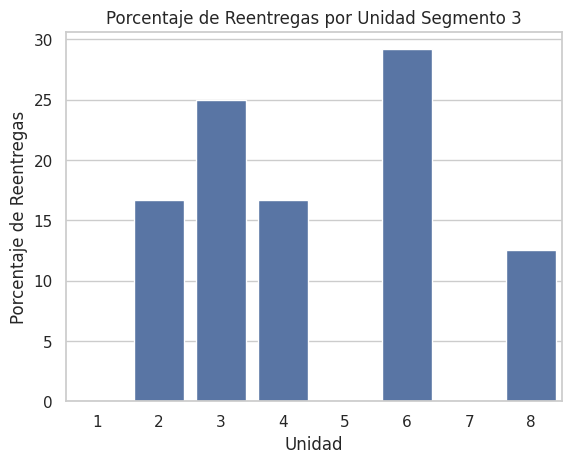

In [303]:
# Graficar con Seaborn
sns.barplot(x='Unidad', y='Porcentaje_Reentregas', data=conteo_reentregas_por_unidad)
plt.title('Porcentaje de Reentregas por Unidad Segmento 3')
plt.xlabel('Unidad')
plt.ylabel('Porcentaje de Reentregas')
plt.show()

In [304]:
conteo_reentregas_por_alumno = conteo_reentregas.groupby('Alumno')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Alumno')

conteo_reentregas_por_alumno

,Alumno,Total_Reentregas_Por_Alumno
0,216,0
1,252,0
2,253,3
3,261,2
4,281,0
5,305,13
6,368,5
7,397,1


### Detalle importante. 

Parece que en la gente que casi llega al final, se trabó en la unidad 8? 

In [305]:
# Filtrar el DataFrame original para incluir solo las filas de los alumnos en segmento_3_ids
df_segmento_4 = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_4_ids)]

# Contar la cantidad de reentregas por Alumno, NombreEjercicio y Unidad
conteo_reentregas = df_segmento_4.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Cantidad_Reentregas')

# Restar 1 a la cantidad de reentregas para quitar la primera entrega
conteo_reentregas['Cantidad_Reentregas'] -= 1

# Agrupar por Unidad y sumar la cantidad de reentregas en cada unidad
conteo_reentregas_por_unidad = conteo_reentregas.groupby('Unidad')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Unidad')

conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad
0,1,23
1,2,27
2,3,42
3,4,23
4,5,20
5,6,34
6,7,24
7,8,16
8,9,11


In [306]:
# Calcular el porcentaje y agregar una nueva columna al DataFrame
conteo_reentregas_por_unidad['Porcentaje_Reentregas'] = (conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'] / conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'].sum()) * 100

# Mostrar el DataFrame resultante
conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad,Porcentaje_Reentregas
0,1,23,10.454545
1,2,27,12.272727
2,3,42,19.090909
3,4,23,10.454545
4,5,20,9.090909
5,6,34,15.454545
6,7,24,10.909091
7,8,16,7.272727
8,9,11,5.000000


### Grafico importante! 

Si reentregas tenes chance de terminar... Y las reentregas fueron bastante distribuidas

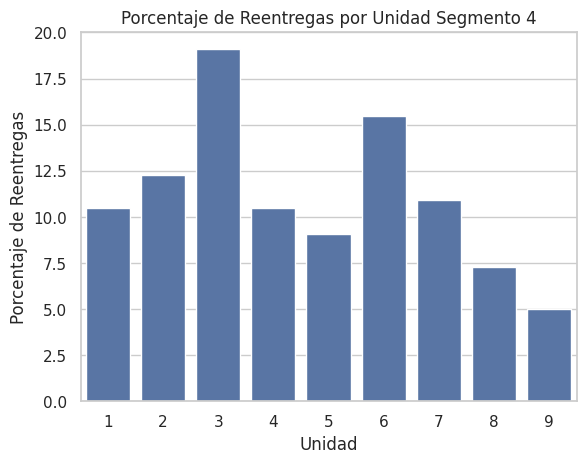

In [307]:
# Graficar con Seaborn
sns.barplot(x='Unidad', y='Porcentaje_Reentregas', data=conteo_reentregas_por_unidad)
plt.title('Porcentaje de Reentregas por Unidad Segmento 4')
plt.xlabel('Unidad')
plt.ylabel('Porcentaje de Reentregas')
plt.show()

In [308]:
conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad,Porcentaje_Reentregas
0,1,23,10.454545
1,2,27,12.272727
2,3,42,19.090909
3,4,23,10.454545
4,5,20,9.090909
5,6,34,15.454545
6,7,24,10.909091
7,8,16,7.272727
8,9,11,5.000000


In [309]:
conteo_reentregas_por_alumno = conteo_reentregas.groupby('Alumno')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Alumno')

conteo_reentregas_por_alumno

,Alumno,Total_Reentregas_Por_Alumno
0,222,2
1,226,4
2,227,5
3,230,0
4,231,0
5,232,3
6,238,1
7,239,4
8,240,0
9,241,0


In [310]:
# Filtrar el DataFrame original para incluir solo las filas de los alumnos en segmento_2_ids
df_segmento_2 = df_ejercicios_en_profundidad[df_ejercicios_en_profundidad['Alumno'].isin(segmento_2_ids)]

# Contar la cantidad de reentregas por Alumno, NombreEjercicio y Unidad
conteo_reentregas = df_segmento_2.groupby(['Alumno', 'NombreEjercicio', 'Unidad']).size().reset_index(name='Cantidad_Reentregas')

# Restar 1 a la cantidad de reentregas para quitar la primera entrega
conteo_reentregas['Cantidad_Reentregas'] -= 1

# Agrupar por Unidad y sumar la cantidad de reentregas en cada unidad
conteo_reentregas_por_unidad = conteo_reentregas.groupby('Unidad')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Unidad')

conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad
0,1,3
1,2,5
2,3,2
3,4,0


In [311]:
# Calcular el porcentaje y agregar una nueva columna al DataFrame
conteo_reentregas_por_unidad['Porcentaje_Reentregas'] = (conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'] / conteo_reentregas_por_unidad['Total_Reentregas_Por_Unidad'].sum()) * 100

# Mostrar el DataFrame resultante
conteo_reentregas_por_unidad

,Unidad,Total_Reentregas_Por_Unidad,Porcentaje_Reentregas
0,1,3,30.0
1,2,5,50.0
2,3,2,20.0
3,4,0,0.0


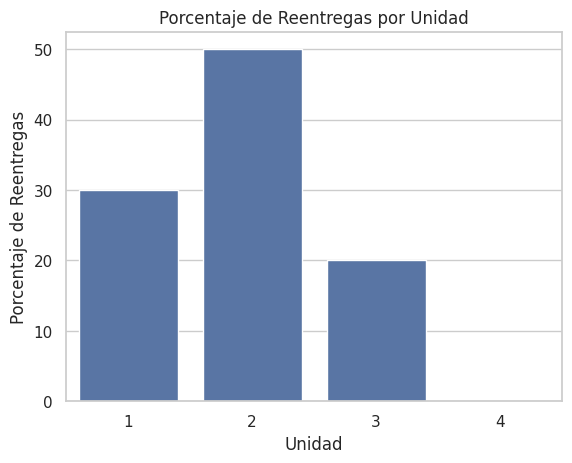

In [312]:
# Graficar con Seaborn
sns.barplot(x='Unidad', y='Porcentaje_Reentregas', data=conteo_reentregas_por_unidad)
plt.title('Porcentaje de Reentregas por Unidad')
plt.xlabel('Unidad')
plt.ylabel('Porcentaje de Reentregas')
plt.show()

In [313]:
conteo_reentregas_por_alumno = conteo_reentregas.groupby('Alumno')['Cantidad_Reentregas'].sum().reset_index(name='Total_Reentregas_Por_Alumno')

conteo_reentregas_por_alumno

# ESTO ESTA METIENDO FALOPA DE PERSONAS???? 

,Alumno,Total_Reentregas_Por_Alumno
0,214,0
1,217,0
2,218,0
3,223,0
4,228,0
5,234,0
6,235,0
7,236,0
8,243,0
9,244,0


### Conclusión

A medida que van pasando las unidades, hay que usar distintas estrategias. Porcentualmente, la gente que deja en la primera parte, reentregó más que los segmentos que avanzaron más en la materia. 
#### OJO (esto también pasa porque esta dividiendo el porcentaje entre 4 y no 8/9). Lo de arriba puede que sea mentira directamente. 



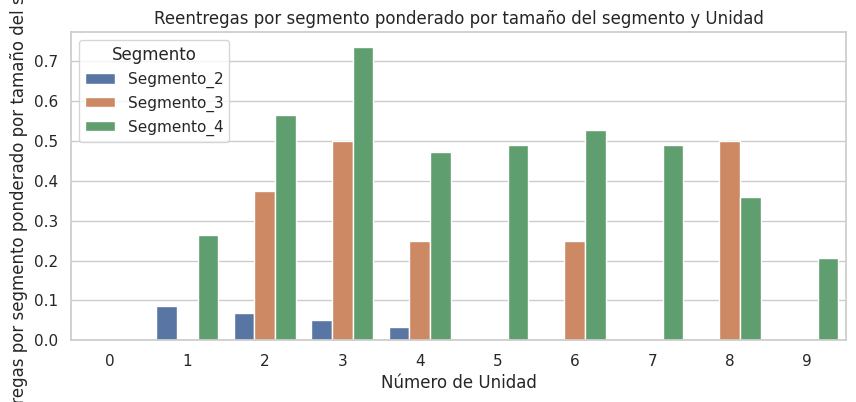

In [314]:
plt.subplots(figsize=(10,4))

# Crear un DataFrame
df = pd.DataFrame({
    'Unidad': list(reentregas_por_unidad_segmento_2.keys()),
    'Segmento_2': [reentrega/len(alumnos_que_dejaron_en_la_primera_parte_de_la_materia) for reentrega in list(reentregas_por_unidad_segmento_2.values())],
    'Segmento_3': [reentrega/len(alumnos_que_dejaron_en_la_segunda_parte_de_la_materia) for reentrega in list(reentregas_por_unidad_segmento_3.values())],
    'Segmento_4': [reentrega/len(alumnos_que_entregaron_todo) for reentrega in list(reentregas_por_unidad_segmento_4.values())]
})

# Derretir el DataFrame para tener una columna para los segmentos
df_melted = pd.melt(df, id_vars='Unidad', var_name='Segmento', value_name='Reentregas')

# Graficar con Seaborn
sns.barplot(x='Unidad', y='Reentregas', hue='Segmento', data=df_melted)
plt.xlabel('Número de Unidad')
plt.ylabel('Reentregas por segmento ponderado por tamaño del segmento')
plt.title('Reentregas por segmento ponderado por tamaño del segmento y Unidad')

plt.show()

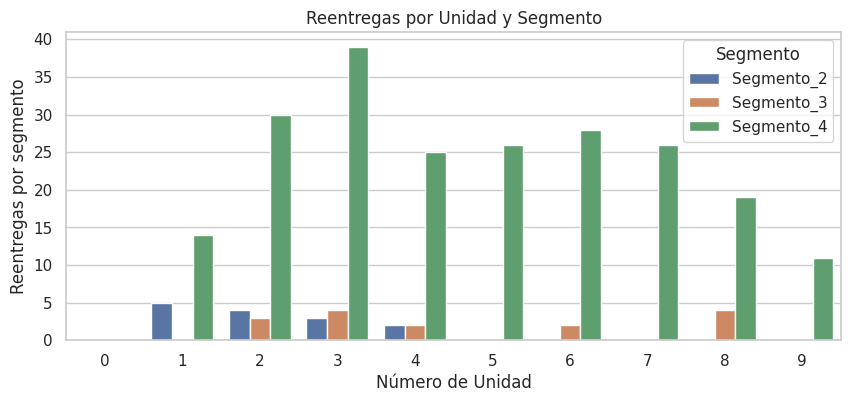

In [315]:
plt.subplots(figsize=(10,4))

# Crear un DataFrame
df = pd.DataFrame({
    'Unidad': list(reentregas_por_unidad_segmento_2.keys()),
    'Segmento_2': [reentrega for reentrega in list(reentregas_por_unidad_segmento_2.values())],
    'Segmento_3': [reentrega for reentrega in list(reentregas_por_unidad_segmento_3.values())],
    'Segmento_4': [reentrega for reentrega in list(reentregas_por_unidad_segmento_4.values())]
})

# Derretir el DataFrame para tener una columna para los segmentos
df_melted = pd.melt(df, id_vars='Unidad', var_name='Segmento', value_name='Reentregas')

# Graficar con Seaborn
sns.barplot(x='Unidad', y='Reentregas', hue='Segmento', data=df_melted)
plt.xlabel('Número de Unidad')
plt.ylabel('Reentregas por segmento')
plt.title('Reentregas por Unidad y Segmento')

plt.show()

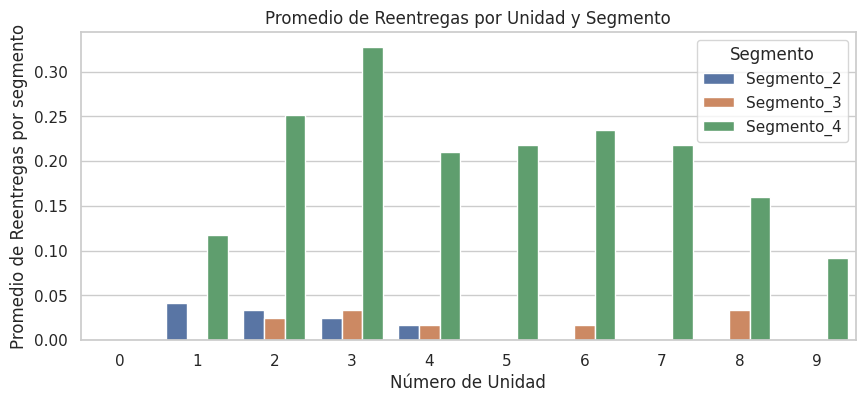

In [316]:
plt.subplots(figsize=(10,4))

todos_los_alumnos_de_segmentos_2_a_4 = alumnos_que_dejaron_en_la_primera_parte_de_la_materia + alumnos_que_dejaron_en_la_segunda_parte_de_la_materia + alumnos_que_entregaron_todo

# Crear un DataFrame
df = pd.DataFrame({
    'Unidad': list(reentregas_por_unidad_segmento_2.keys()),
    'Segmento_2': [reentrega/len(todos_los_alumnos_de_segmentos_2_a_4) for reentrega in list(reentregas_por_unidad_segmento_2.values())],
    'Segmento_3': [reentrega/len(todos_los_alumnos_de_segmentos_2_a_4) for reentrega in list(reentregas_por_unidad_segmento_3.values())],
    'Segmento_4': [reentrega/len(todos_los_alumnos_de_segmentos_2_a_4) for reentrega in list(reentregas_por_unidad_segmento_4.values())]
})

# Derretir el DataFrame para tener una columna para los segmentos
df_melted = pd.melt(df, id_vars='Unidad', var_name='Segmento', value_name='Reentregas')

# Graficar con Seaborn
sns.barplot(x='Unidad', y='Reentregas', hue='Segmento', data=df_melted)
plt.xlabel('Número de Unidad')
plt.ylabel('Promedio de Reentregas por segmento')
plt.title('Promedio de Reentregas por Unidad y Segmento')

plt.show()

#TAREA 
CSV para mati que tenga persona, unidad, ejercicio y fecha en la cual submiteo la unidad. 
A que segmento pertenece cada persona. 

Dataframe de exercises

In [317]:
df_ejercicios_en_profundidad.to_csv('ejercicios.csv', sep=';')

# Lista de objetos Archivo
#ejercicios = Exercise.objects.all() 

# Nombre del archivo CSV de salida
#nombre_archivo_csv = "ejercicios.csv"

# Crear y escribir en el archivo CSV
#with open(nombre_archivo_csv, mode='w', newline='') as archivo_csv:
#    writer = csv.writer(archivo_csv)
#    writer.writerow(["Archivo", "Unidad", "Persona", "Fecha"])  # Escribir encabezados
#    for ejercicio in ejercicios:
#        writer.writerow([ejercicio.name, ejercicio.unit(), ejercicio.student_record().email, ejercicio.delivery_date()])  # Escribir datos de cada archivo

 ### Fechas de Entrega

Esto no habla en ningún momento de reentregas todavia! 

In [318]:
from datetime import datetime 

# Estan puestos como un dia despues del dia culmine para entregar para evitar casos bordes de horas
fechas_de_entrega = {
    1: datetime.strptime("2022/03/18", '%Y/%m/%d'),
    2:  datetime.strptime("2022/03/25", '%Y/%m/%d'),
    3:  datetime.strptime("2022/04/01", '%Y/%m/%d'),
    4:  datetime.strptime("2022/04/15", '%Y/%m/%d'),
    5:  datetime.strptime("2022/04/22", '%Y/%m/%d'),
    6:  datetime.strptime("2022/04/29", '%Y/%m/%d'),
    7:  datetime.strptime("2022/05/06", '%Y/%m/%d'),
    8:  datetime.strptime("2022/05/13", '%Y/%m/%d'),
    9:  datetime.strptime("2022/06/02", '%Y/%m/%d')
}

In [319]:
# Convertir la columna 'timestamp_with_timezone' a tipo datetime
df_ejercicios_en_profundidad['FechaEntrega'] = pd.to_datetime(df_ejercicios_en_profundidad['FechaEntrega'])

# Eliminar la información de la zona horaria
df_ejercicios_en_profundidad['FechaEntrega'] = df_ejercicios_en_profundidad['FechaEntrega'].dt.tz_localize(None)

In [320]:
entregas_tardias_unidad_1 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 1) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[1])]
entregas_tardias_unidad_2 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 2) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[2])]
entregas_tardias_unidad_3 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 3) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[3])]
entregas_tardias_unidad_4 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 4) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[4])]
entregas_tardias_unidad_5 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 5) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[5])]
entregas_tardias_unidad_6 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 6) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[6])]
entregas_tardias_unidad_7 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 7) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[7])]
entregas_tardias_unidad_8 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 8) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[8])]
entregas_tardias_unidad_9 = df_ejercicios_en_profundidad[(df_ejercicios_en_profundidad['Unidad'] == 9) & (df_ejercicios_en_profundidad['FechaEntrega'] > fechas_de_entrega[9])]


entregas_tardias = pd.concat([entregas_tardias_unidad_1, entregas_tardias_unidad_2, entregas_tardias_unidad_3, entregas_tardias_unidad_4, entregas_tardias_unidad_5, entregas_tardias_unidad_6, entregas_tardias_unidad_7, entregas_tardias_unidad_8, entregas_tardias_unidad_9])
entregas_tardias

,EjercicioID,UnitSubmissionID,NombreEjercicio,Alumno,Unidad,FechaEntrega,AceptaPairReview,Genero,Pais,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol,Reentrega
569,624,181,rebotes.py,376,1,2022-03-23 10:12:01.073702,False,3,Argentina,,,,Ingeniería Industrial,,NaN,NaN,,,,0
570,625,181,hipoteca.py,376,1,2022-03-23 10:12:01.073702,False,3,Argentina,,,,Ingeniería Industrial,,NaN,NaN,,,,0
571,626,181,esfera.py,376,1,2022-03-23 10:12:01.073702,False,3,Argentina,,,,Ingeniería Industrial,,NaN,NaN,,,,0
572,627,181,geringoso.py,376,1,2022-03-23 10:12:01.073702,False,3,Argentina,,,,Ingeniería Industrial,,NaN,NaN,,,,0
843,895,251,rebotes.py,254,1,2022-03-28 04:45:16.440360,False,3,Argentina,Buenos Aires,Banfield,UTN Facultad Regional Buenos Aires,,Maestría,2.0,1.0,,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,3038,926,torre_control.py,248,9,2022-06-02 07:12:58.163663,False,3,Argentina,Buenos Aires,San Martín,Universidad de Buenos Aires,,Grado (universitario),2.0,2.0,,,,0
2949,3039,927,informe_final.py,226,9,2022-06-02 21:09:02.528814,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,,1
2950,3040,927,lote.py,226,9,2022-06-02 21:09:02.528814,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,,1
2951,3041,927,torre_control.py,226,9,2022-06-02 21:09:02.528814,False,3,Argentina,Santa Fe,Rosario,IICAR - CONICET/UNR,,Grado (universitario),2.0,2.0,,,,1


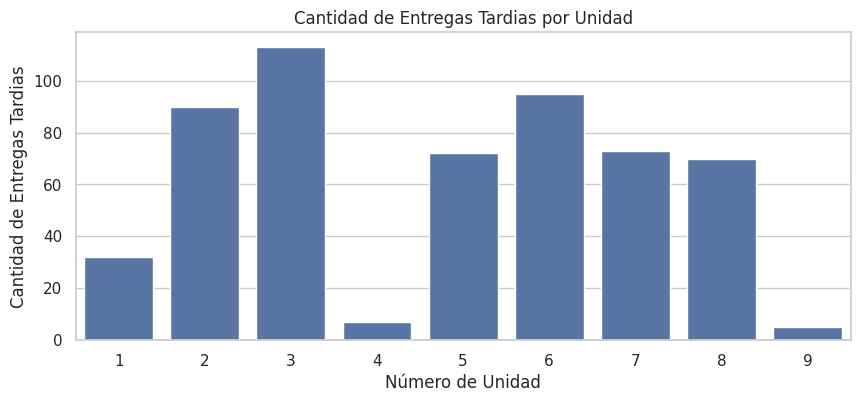

In [321]:
plt.subplots(figsize=(10,4))

# Graficar con Seaborn
sns.countplot(x='Unidad', data=entregas_tardias)
plt.xlabel('Número de Unidad')
plt.ylabel('Cantidad de Entregas Tardias')
plt.title('Cantidad de Entregas Tardias por Unidad')

plt.show()

### Correcciones automáticas



In [322]:
df_authomatic_corrections_en_profundidad.columns.tolist()
df_authomatic_corrections_en_profundidad['Unidad'].value_counts()

3    365
4    282
6    152
7    134
8     92
Name: Unidad, dtype: int64

In [323]:
df_authomatic_corrections_en_profundidad

,AuthomaticCorrectionID,EjercicioID,InstruccionEjecutada,EsOriginal,PorcetajeDeTests,Funciona,FechaDeCorreccionAutomatica,Publicado,UnitSubmissionID,NombreEjercicio,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,1468,1950,"<p>Para evaluar la función insertar, la llamam...",True,37.0,True,2022-05-26 14:10:48.988673+00:00,True,585,bbin.py,...,Buenos Aires,Villa Bosch,SAP,,Grado (universitario),2.0,1.0,,SAP. Go-to-Market Master Data Specialist,
1,1384,2060,"<p>Para evaluar la función insertar, la llamam...",True,0.0,False,2022-05-26 14:10:48.987384+00:00,True,612,bbin.py,...,CABA,Capital Federal,UNSAM,Ing. Industrial con pedido de pase. Lic. Cienc...,Grado incompleto / pase a Lic. Ciencia de datos,4.0,4.0,,,
2,1703,2360,<p>Para evaluar la función vida_en_segundos la...,True,0.0,False,2022-05-26 14:11:07.849442+00:00,True,696,vida.py,...,Buenos Aires,Villa Bosch,SAP,,Grado (universitario),2.0,1.0,,SAP. Go-to-Market Master Data Specialist,
3,727,886,<p>Para evaluar la función costo_camion la lla...,True,0.0,True,2022-05-10 15:24:19.796152+00:00,True,249,costo_camion.py,...,Buenos Aires,San Martin,UNSAM,,Grado (universitario),4.0,1.0,,Swiss Medical,
4,728,887,<p>Para evaluar la función hacer_informe la ll...,True,0.0,True,2022-05-10 15:24:19.796170+00:00,True,249,tabla_informe.py,...,Buenos Aires,San Martin,UNSAM,,Grado (universitario),4.0,1.0,,Swiss Medical,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1439,2559,"<p>Para evaluar la función insertar, la llamam...",True,100.0,True,2022-05-26 14:10:48.988230+00:00,True,752,bbin.py,...,Buenos Aires,Bahía Blanca,Universidad Nacional del Sur,,Grado (universitario),4.0,1.0,,,
1021,1590,2589,<p>Para evaluar la función parse_csv la llamam...,True,60.0,True,2022-05-26 14:10:59.215738+00:00,True,763,fileparse.py,...,,,,,,NaN,NaN,,,
1022,1592,2590,<p>Para evaluar la función leer_camion la llam...,True,0.0,False,2022-05-26 14:10:59.215770+00:00,True,763,informe_final.py,...,,,,,,NaN,NaN,,,
1023,1593,2590,<p>Para evaluar la función leer_precios la lla...,True,0.0,False,2022-05-26 14:10:59.215786+00:00,True,763,informe_final.py,...,,,,,,NaN,NaN,,,


/tmp/ipykernel_14345/1820751159.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_authomatic_corrections_en_profundidad, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')


<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

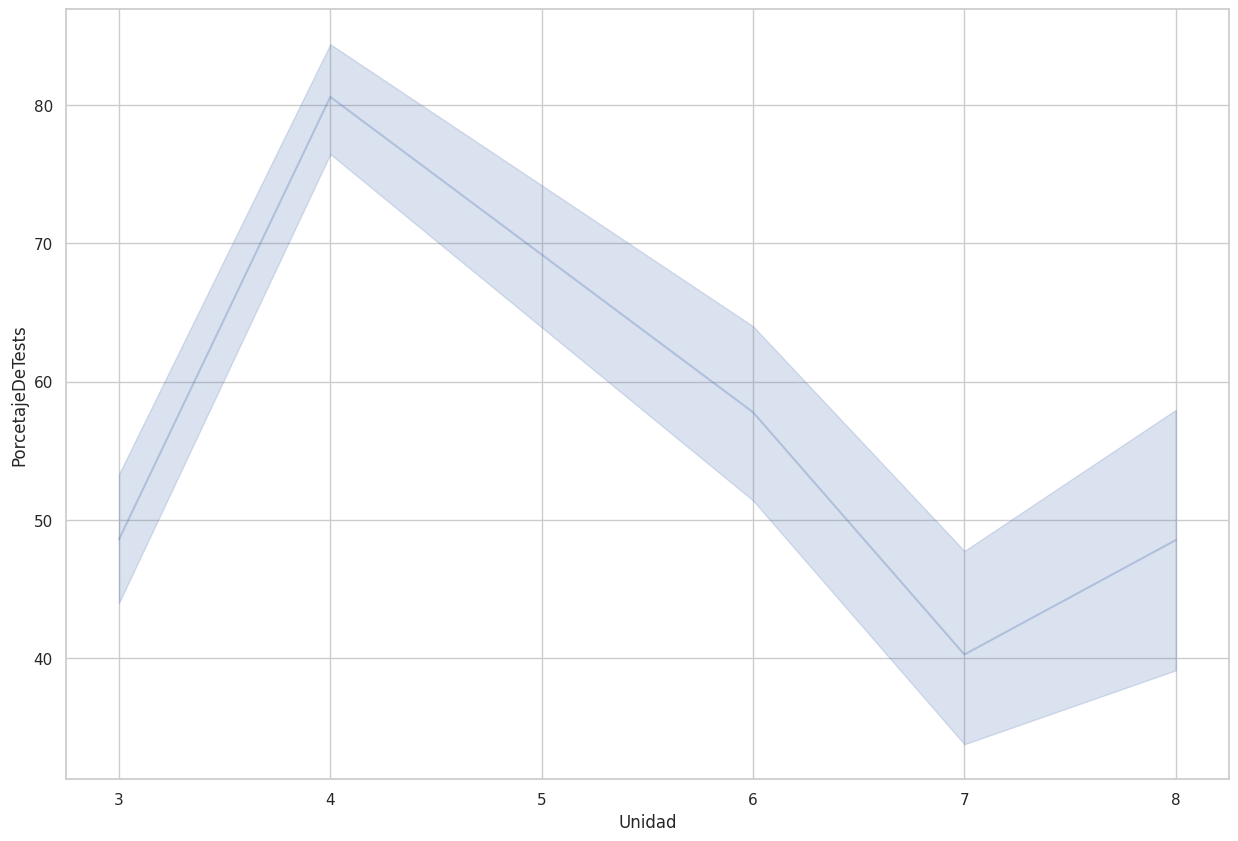

In [324]:
plt.subplots(figsize=(15,10))

sns.lineplot(data=df_authomatic_corrections_en_profundidad, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')

/tmp/ipykernel_14345/698341612.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_2, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')


<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

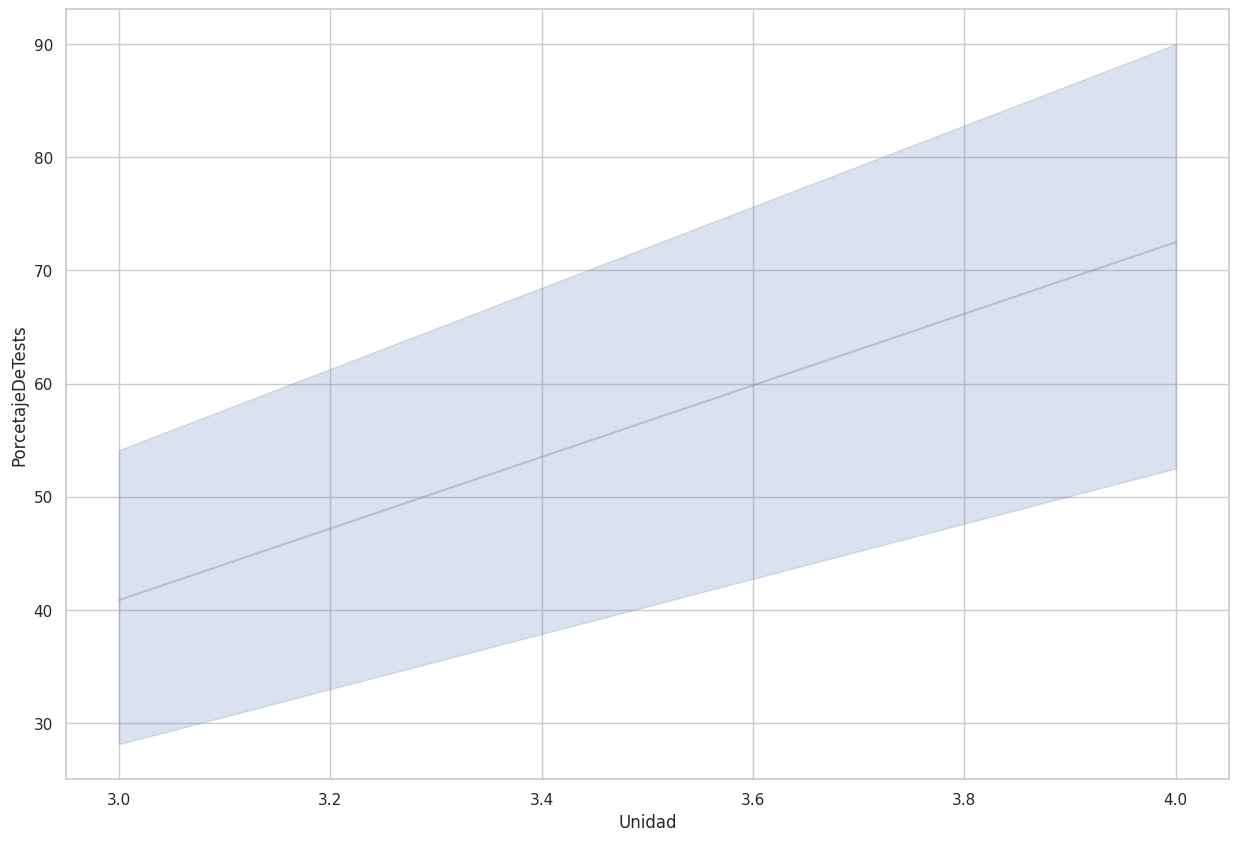

In [325]:
df_segmento_2 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_2_ids)]

plt.subplots(figsize=(15,10))

sns.lineplot(data=df_segmento_2, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')

/tmp/ipykernel_14345/4282682305.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_3, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')


<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

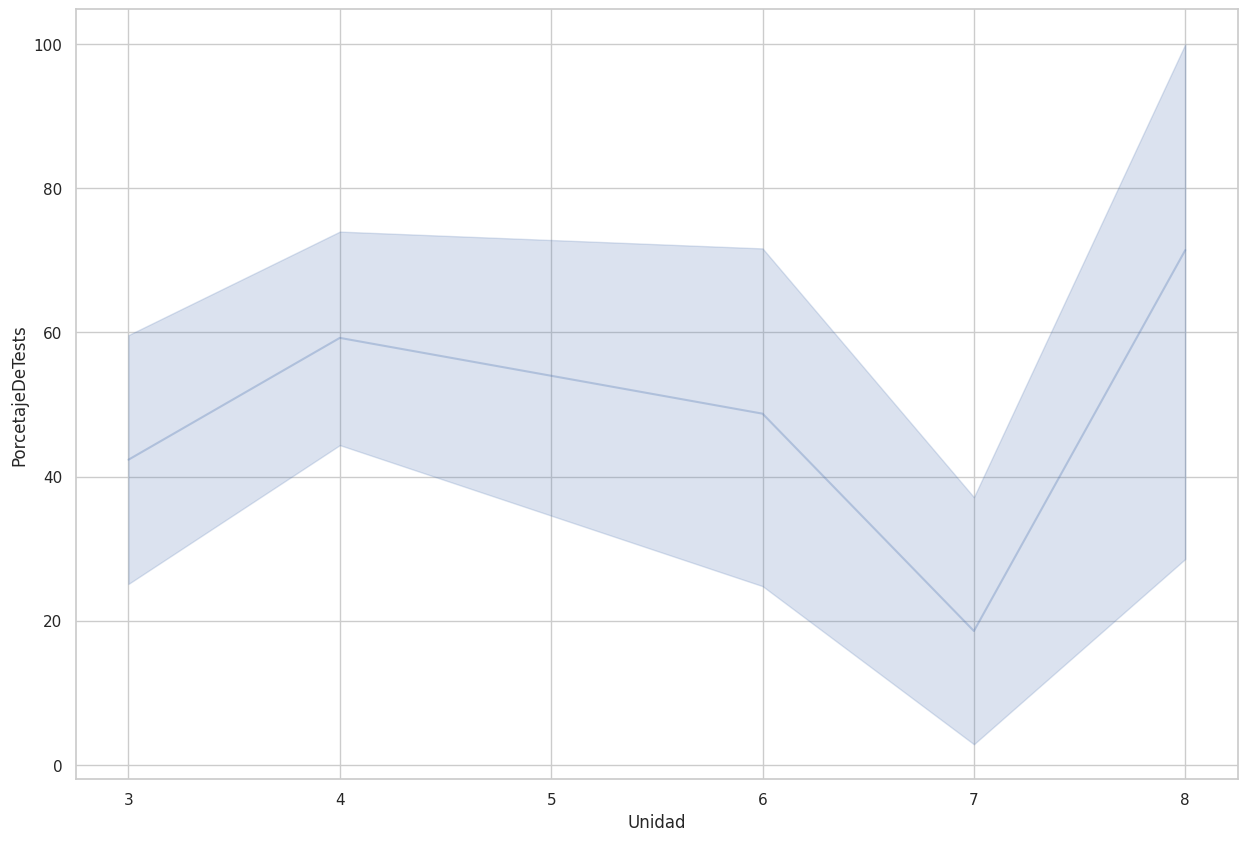

In [326]:
df_segmento_3 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_3_ids)]

plt.subplots(figsize=(15,10))

sns.lineplot(data=df_segmento_3, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')

/tmp/ipykernel_14345/1403505243.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_4, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')


<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

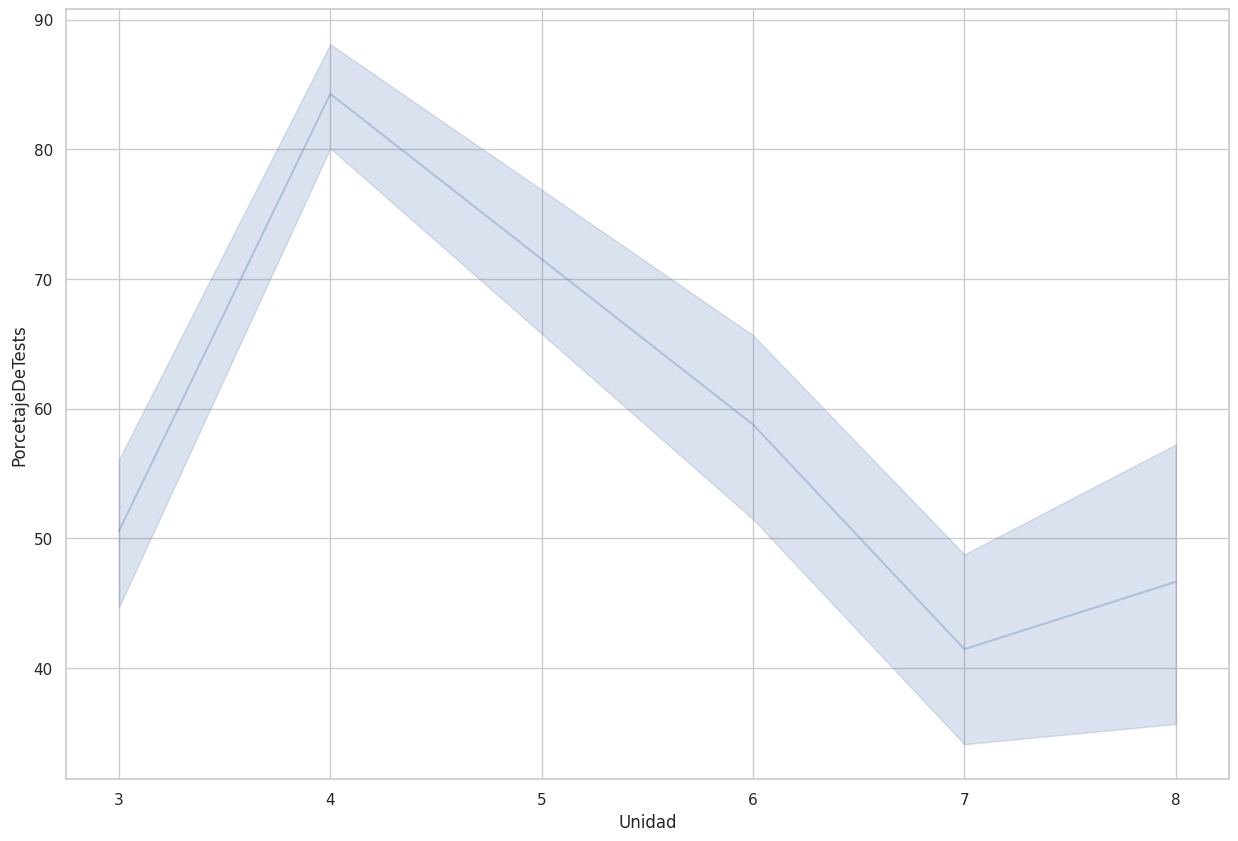

In [327]:
df_segmento_4 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_4_ids)]

plt.subplots(figsize=(15,10))

sns.lineplot(data=df_segmento_4, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted')

/tmp/ipykernel_14345/3482901424.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_2, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 2')
/tmp/ipykernel_14345/3482901424.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_3, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 3')
/tmp/ipykernel_14345/3482901424.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_segmento_4, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 4')


<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

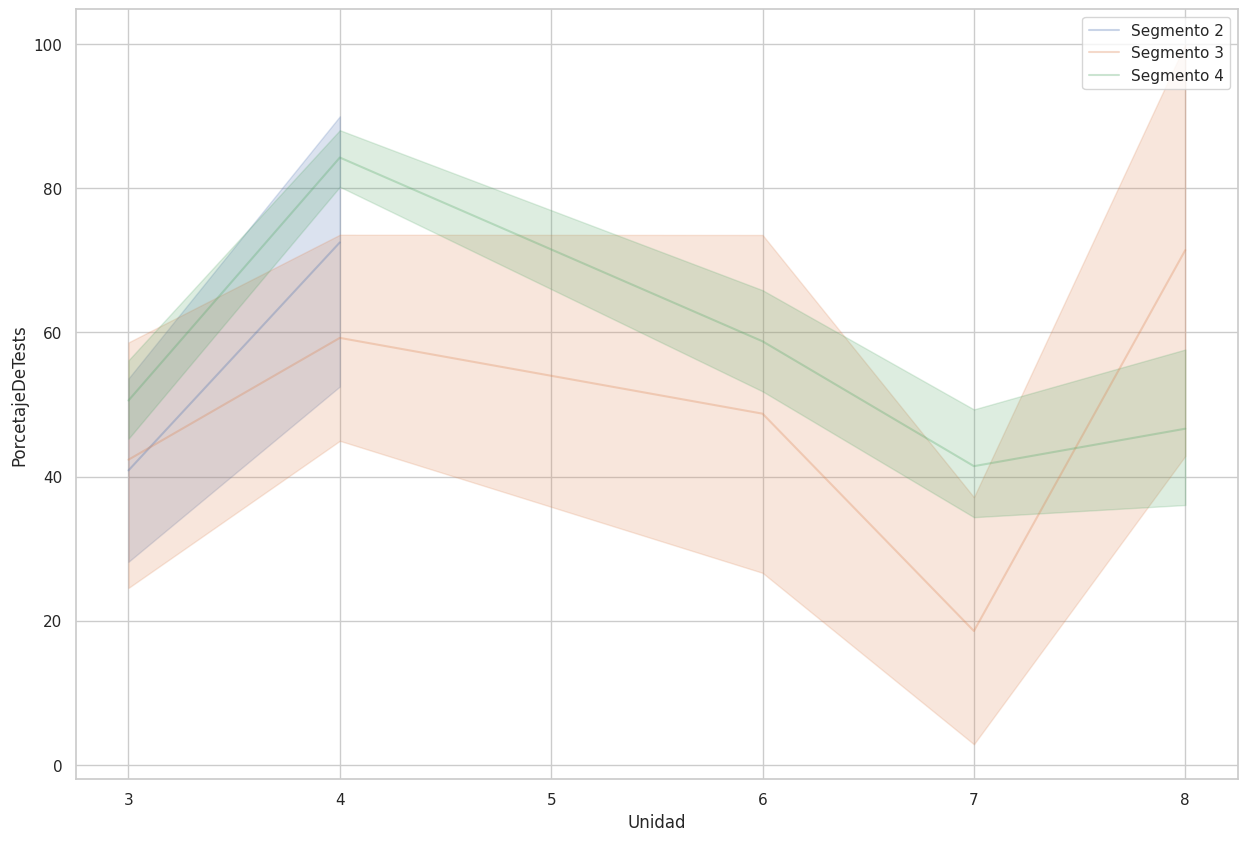

In [328]:
df_segmento_2 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_2_ids)]
df_segmento_3 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_3_ids)]
df_segmento_4 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_4_ids)]

plt.subplots(figsize=(15,10))

sns.lineplot(data=df_segmento_2, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 2')
sns.lineplot(data=df_segmento_3, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 3')
sns.lineplot(data=df_segmento_4, x='Unidad', y='PorcetajeDeTests', alpha=0.3, palette='muted', label='Segmento 4')

<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

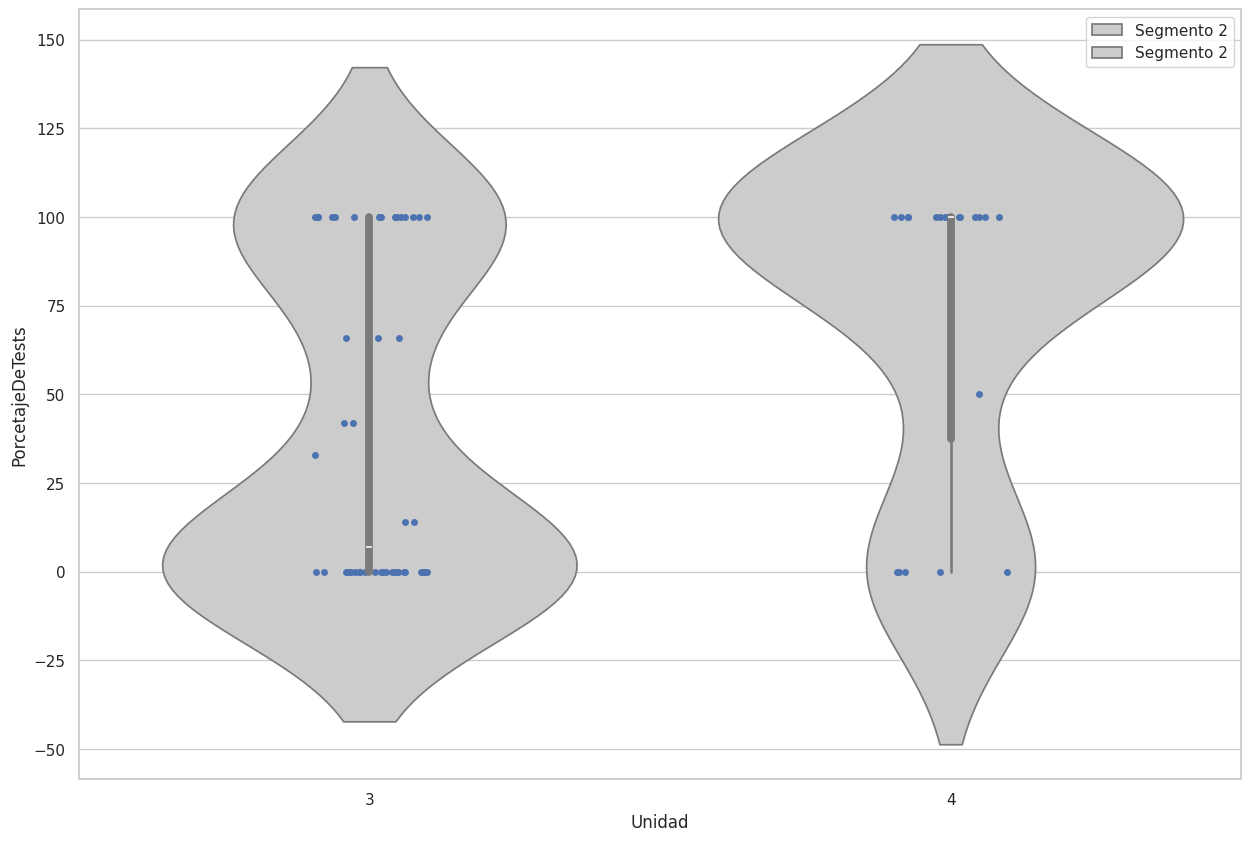

In [329]:
df_segmento_2 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_2_ids)]


plt.subplots(figsize=(15,10))

sns.violinplot(data=df_segmento_2, x='Unidad', y='PorcetajeDeTests', color='0.8', label='Segmento 2')
sns.stripplot(x="Unidad", y="PorcetajeDeTests", data=df_segmento_2, jitter=True, zorder=1)

<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

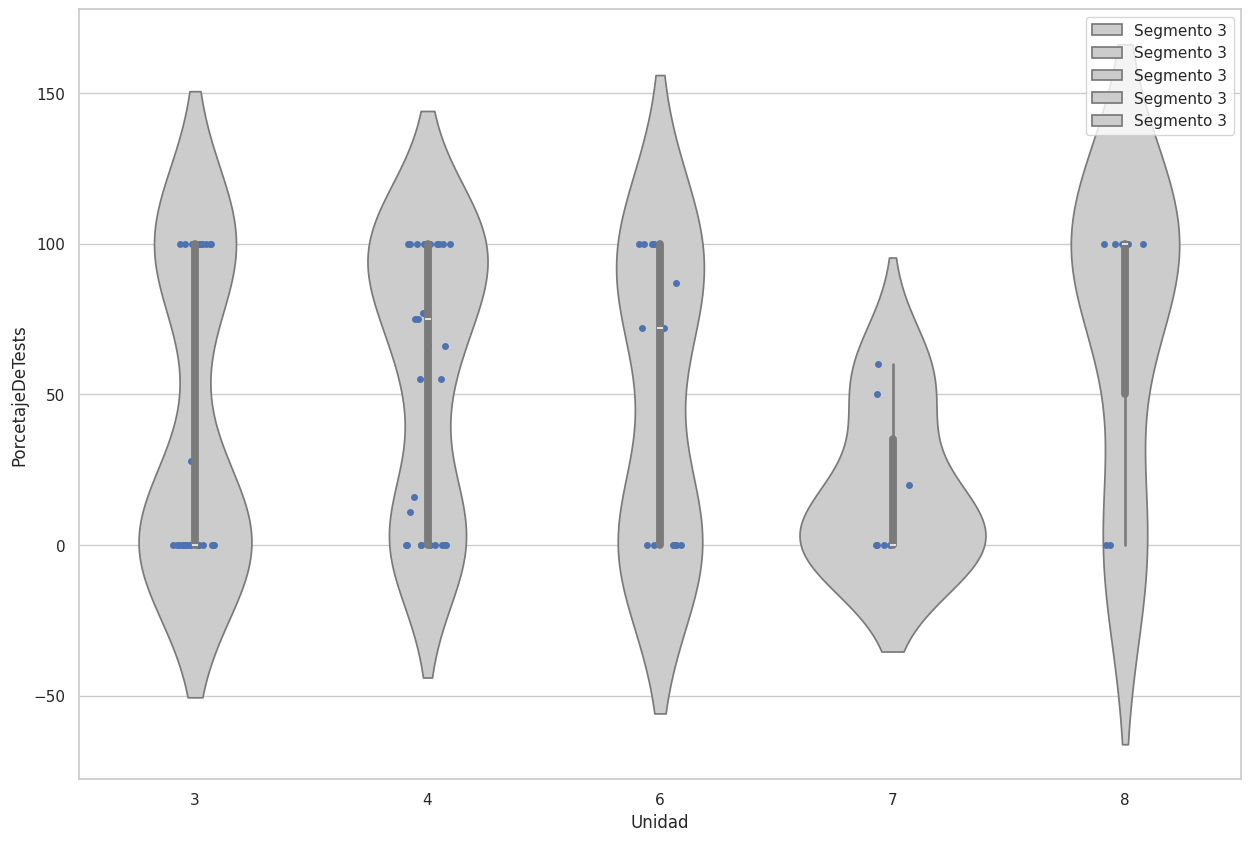

In [330]:
df_segmento_3 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_3_ids)]


plt.subplots(figsize=(15,10))

sns.violinplot(data=df_segmento_3, x='Unidad', y='PorcetajeDeTests', color='0.8', label='Segmento 3')
sns.stripplot(x="Unidad", y="PorcetajeDeTests", data=df_segmento_3, jitter=True, zorder=1)

<Axes: xlabel='Unidad', ylabel='PorcetajeDeTests'>

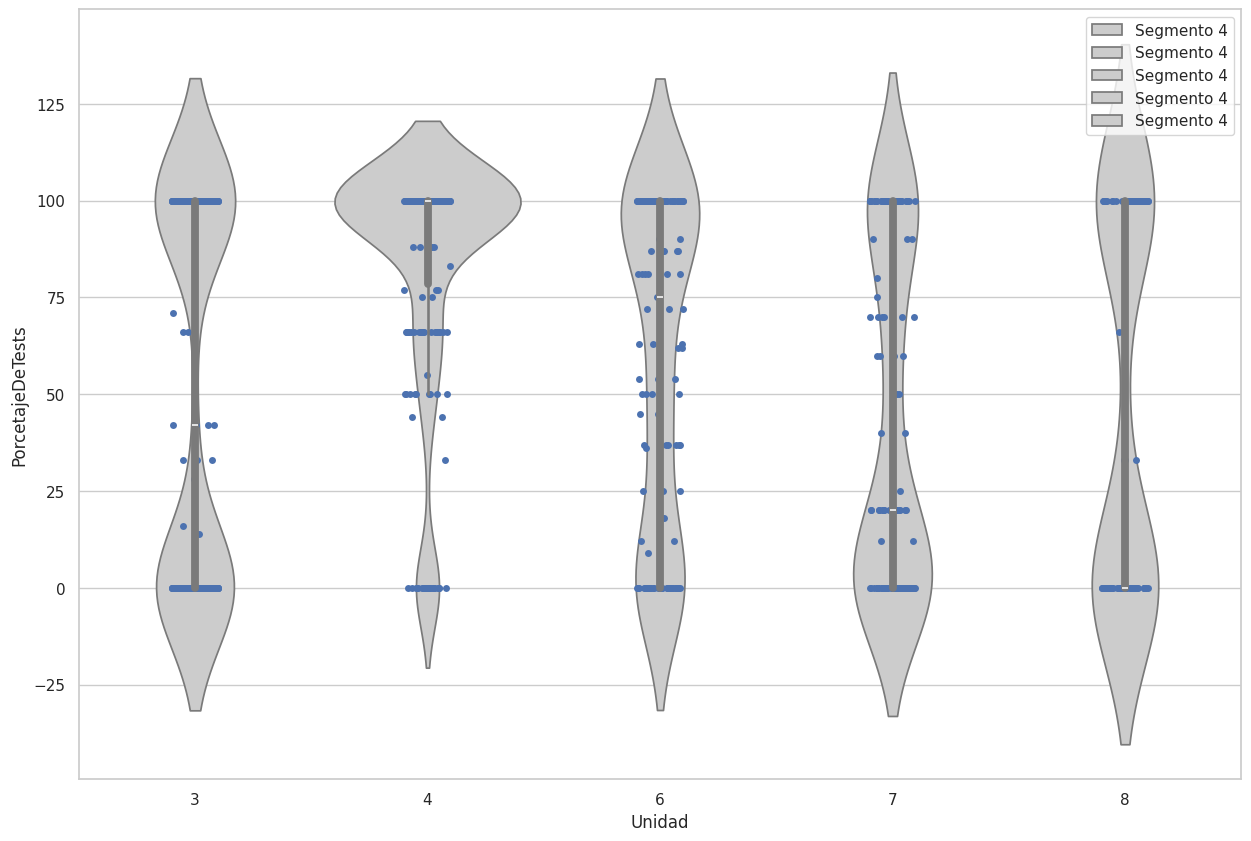

In [331]:
df_segmento_4 = df_authomatic_corrections_en_profundidad[df_authomatic_corrections_en_profundidad['Alumno'].isin(segmento_4_ids)]

plt.subplots(figsize=(15,10))

sns.violinplot(data=df_segmento_4, x='Unidad', y='PorcetajeDeTests', color='0.8', label='Segmento 4')
sns.stripplot(x="Unidad", y="PorcetajeDeTests", data=df_segmento_4, jitter=True, zorder=1)

# BUSCAR QUE PARAMETRO TOCAR PARA QUE CUANDO TENES MUCHOS PUNTOS NO SE VEA UNO SOLO.

In [332]:
# Si sacamos los 0s q pasa? Para todos los graficos 

# Que correlacion hay en los no anda o 0% con gente q deja en esa unidad? 

#Grafico que mando por whatsapp (plotting a three way)

#Eje y las unidades, eje x las fechas y para que cada semana la cantidad de personas que entregaron cada semana. Con eso tener la pelicula de cada unidad. 

In [333]:
print(f"Correcciones automaticas: {AuthomaticCorrection.objects.all().count()}")
print(f"Correcciones docentes: {Correction.objects.all().count()}")
print(f"Ejercicios entregados: {Exercise.objects.all().count()}")
print(f"Correcciones pair review: {PairReviewCorrection.objects.all().count()}")
print(f"Autoevaluaciones: {SelfEvaluation.objects.all().count()}")
print(f"Autoevaluaciones de ejercicios: {ExerciseSelfEvaluation.objects.all().count()}")

print(f"Unidades Entregadas: {UnitSubmission.objects.all().count()}")
print(f"Estudiantes: {StudentRecord.objects.all().count()}")
print(f"Cursos: {CourseRecord.objects.all().count()}")

Correcciones automaticas: 1050
Correcciones docentes: 2302
Ejercicios entregados: 3020
Correcciones pair review: 95
Autoevaluaciones: 653
Autoevaluaciones de ejercicios: 2965
Unidades Entregadas: 914
Estudiantes: 192
Cursos: 1


In [334]:
print(f"# Correcciones docentes corregidas y publicadas: {Correction.objects.filter(done=True, published=True).count()}")
print(f"# Correcciones docentes corregidas: {Correction.objects.filter(done=True).count()}")
print(f"# Pair Reviews corregidas: {PairReviewCorrection.objects.filter(done=True).count()}")

# Correcciones docentes corregidas y publicadas: 222
# Correcciones docentes corregidas: 253
# Pair Reviews corregidas: 80


## Correcciones Docentes

In [335]:
Group.objects.all()[0].user_set.all()

<QuerySet [<User: ivanpedron@gmail.com>, <User: dalban@unsam.edu.ar>]>

In [336]:
corrections = Correction.objects.all()
set([correction.reviewer.email for correction in corrections])

{'dalban@unsam.edu.ar',
 'ivanpedron@gmail.com',
 'manuelacerdeiro@gmail.com',
 'matiaslopez@gmail.com',
 'ofilevich@unsam.edu.ar',
 'rgrimson@unsam.edu.ar'}

In [337]:
User.objects.filter(groups__name='Correctores')

<QuerySet [<User: ivanpedron@gmail.com>, <User: dalban@unsam.edu.ar>]>

In [338]:
done_corrections = Correction.objects.filter(done=True)
set([correction.reviewer.email for correction in done_corrections])

{'dalban@unsam.edu.ar',
 'ivanpedron@gmail.com',
 'ofilevich@unsam.edu.ar',
 'rgrimson@unsam.edu.ar'}

In [339]:
# Solo usuarios que son staff (revisores), con o sin correcciones
reviewers = User.objects.filter(is_staff=True) \
    .annotate(total_corrections=Count('corrections')) \
    .values('email', 'total_corrections')

for r in reviewers:
    print(f"{r['email']}: {r['total_corrections']} correcciones")


manuelacerdeiro@gmail.com: 74 correcciones
rgrimson@unsam.edu.ar: 83 correcciones
german_nba11@hotmail.com: 0 correcciones
ofilevich@unsam.edu.ar: 450 correcciones
ivanpedron@gmail.com: 806 correcciones
dalban@unsam.edu.ar: 797 correcciones
wright.carolina@gmail.com: 0 correcciones
matiaslopez@gmail.com: 92 correcciones


In [340]:
from django.db.models import Q

# Usuarios staff (reviewers), con cantidad de correcciones marcadas como done=True
reviewers = User.objects.filter(is_staff=True) \
    .annotate(done_corrections=Count('corrections', filter=Q(corrections__done=True))) \
    .values('email', 'done_corrections')

for r in reviewers:
    print(f"{r['email']}: {r['done_corrections']} correcciones terminadas")


manuelacerdeiro@gmail.com: 0 correcciones terminadas
rgrimson@unsam.edu.ar: 2 correcciones terminadas
german_nba11@hotmail.com: 0 correcciones terminadas
ofilevich@unsam.edu.ar: 20 correcciones terminadas
ivanpedron@gmail.com: 165 correcciones terminadas
dalban@unsam.edu.ar: 66 correcciones terminadas
wright.carolina@gmail.com: 0 correcciones terminadas
matiaslopez@gmail.com: 0 correcciones terminadas


### Promedios resultado por segmento 

In [344]:
graded_corrections = Correction.objects.filter(done=True)


corrections_segment_2 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_2_ids)
corrections_segment_3 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_3_ids)
corrections_segment_4 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_4_ids)

print(f"Grade promedio para segmento 2: {sum([correction.grade for correction in corrections_segment_2])/len(corrections_segment_2)}")

print(f"Grade promedio para segmento 3: {sum([correction.grade for correction in corrections_segment_3])/len(corrections_segment_3)}")

print(f"Grade promedio para segmento 4: {sum([correction.grade for correction in corrections_segment_4])/len(corrections_segment_4)}")

Grade promedio para segmento 2: 3.8333333333333335
Grade promedio para segmento 3: 3.857142857142857
Grade promedio para segmento 4: 4.07177033492823


In [346]:
graded_corrections = Correction.objects.filter(done=True)


corrections_segment_2 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_2_ids)
corrections_segment_3 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_3_ids)
corrections_segment_4 = graded_corrections.filter(exercise__unit_submission__student_record__id__in=segmento_4_ids)

print(f"code_presentation promedio para segmento 2: {sum([correction.code_presentation for correction in corrections_segment_2])/len(corrections_segment_2)} y hay {len(corrections_segment_2)} correcciones")

print(f"code_presentation promedio para segmento 3: {sum([correction.code_presentation for correction in corrections_segment_3])/len(corrections_segment_3)} y hay {len(corrections_segment_3)} correcciones")

print(f"code_presentation promedio para segmento 4: {sum([correction.code_presentation for correction in corrections_segment_4])/len(corrections_segment_4)} y hay {len(corrections_segment_4)} correcciones")

code_presentation promedio para segmento 2: 4.0 y hay 30 correcciones
code_presentation promedio para segmento 3: 4.214285714285714 y hay 14 correcciones
code_presentation promedio para segmento 4: 4.143540669856459 y hay 209 correcciones


In [341]:
df_correcciones_en_profundidad

,CorrectionID,EjercicioID,Corrector,ResuelveEjercicio,PresentacionCodigo,Funciona,Tests,Evaluacion,Corregido,TiempoDeCorreccion,...,Estado,Ciudad,EstudiosUniversidad,EstudiosCarrera,EstudiosNivel,EstudiosNivelProgramacion,EstudiosNivelPython,EstudiosLocacion,TrabajoEmpresa,TrabajoRol
0,921,936,ivanpedron@gmail.com,1.0,4.0,3.0,1.0,4.0,True,5.0,...,Buenos Aires,General San Martín,UNSAM/CNEA,,Grado (universitario),4.0,4.0,,,
1,1343,1377,dalban@unsam.edu.ar,1.0,1.0,1.0,1.0,1.0,False,0.0,...,CABA,CABA,Servicio Meteorológico Nacional,,Grado (universitario),3.0,2.0,,Servicio Meteorológico Nacional. Centro de pro...,
2,25,30,matiaslopez@gmail.com,1.0,1.0,1.0,1.0,1.0,False,1.0,...,Buenos Aires,Buenos Aires,Universidad Nacional de Tres de Febrero,Ingenieria en Sonido,Pregrado (tecnicatura),2.0,2.0,,Eryx,Desarrollador
3,1178,1202,ivanpedron@gmail.com,1.0,5.0,3.0,3.0,5.0,True,5.0,...,,,,,,NaN,NaN,,,
4,101,106,ivanpedron@gmail.com,1.0,5.0,3.0,1.0,5.0,True,4.0,...,Santa Cruz,Comandante Luis Piedrabuena,Colegio provincial de educación secundaria N°1,,Grado (universitario),4.0,1.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,2229,2585,dalban@unsam.edu.ar,1.0,5.0,1.0,3.0,3.0,True,50.0,...,,,,,,NaN,NaN,,,
2240,2221,2575,dalban@unsam.edu.ar,1.0,4.0,1.0,3.0,2.0,True,60.0,...,Buenos Aires,Vicente López,UNSAM,,Escuela,2.0,1.0,,,
2241,2214,2568,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,4.0,True,40.0,...,Buenos aires,Matanza,Universidad nacional de San Martín,Ingeniería Biomédica,Escuela,3.0,2.0,,,
2242,2210,2564,dalban@unsam.edu.ar,1.0,5.0,3.0,3.0,5.0,True,10.0,...,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,CNEA - CONICET,,Doctorado,2.0,1.0,,,


In [352]:

filtered_df = df_correcciones_en_profundidad[(df_correcciones_en_profundidad['Alumno'].isin(segmento_2_ids)) 
                                             & (df_correcciones_en_profundidad['Corregido'])]

correcciones_unidades_segmento_2 = filtered_df['Unidad'].value_counts()


filtered_df = df_correcciones_en_profundidad[(df_correcciones_en_profundidad['Alumno'].isin(segmento_3_ids)) 
                                             & (df_correcciones_en_profundidad['Corregido'])]

correcciones_unidades_segmento_3 = filtered_df['Unidad'].value_counts()




filtered_df = df_correcciones_en_profundidad[(df_correcciones_en_profundidad['Alumno'].isin(segmento_4_ids)) 
                                             & (df_correcciones_en_profundidad['Corregido'])]

correcciones_unidades_segmento_4 = filtered_df['Unidad'].value_counts()


print(correcciones_unidades_segmento_2)
print(correcciones_unidades_segmento_4)

2    12
1    11
3     4
4     2
Name: Unidad, dtype: int64
7    32
9    31
6    30
5    28
8    21
3    19
2    18
1    14
4    12
Name: Unidad, dtype: int64


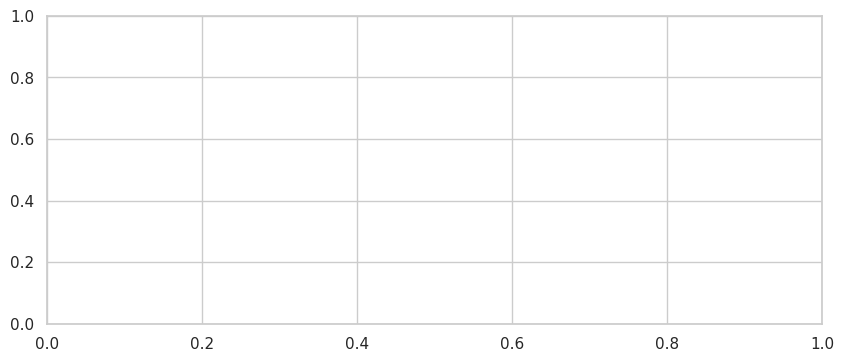

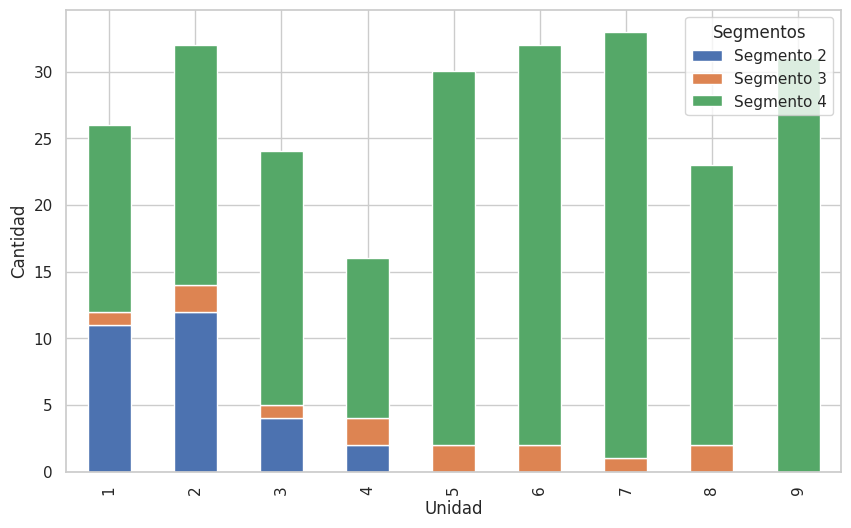

In [351]:
import matplotlib.pyplot as plt
import pandas as pd

plt.subplots(figsize=(10, 4))

# Crear un DataFrame vacío con todas las unidades como índice
unidades_completas = frecuencia_unidades_segmento_4.index
df = pd.DataFrame(index=unidades_completas)

# Añadir los datos de cada segmento, alineando por el índice
df['Segmento 2'] = correcciones_unidades_segmento_2.reindex(unidades_completas, fill_value=0)
df['Segmento 3'] = correcciones_unidades_segmento_3.reindex(unidades_completas, fill_value=0)
df['Segmento 4'] = correcciones_unidades_segmento_4.reindex(unidades_completas, fill_value=0)

# Ordenar el DataFrame por el índice (unidades)
df.sort_index(inplace=True)

# Crear el gráfico de barras apiladas
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y etiquetas
ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad')

# Mostrar la leyenda
ax.legend(title='Segmentos')

# Mostrar el gráfico
plt.show()
